In [41]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)


# Introduction
Based on data in folder 'data', analysis - plots - stats are ran for the opi-syn-circuit project. For in-depth explanation of the data acquisition and preprocessing read:
- matlab_instructions.txt
- Birdsong, Jongbloets et al. eLife 2019

In [1]:
#import packages
library(ggplot2)
library(reshape2)
library(cowplot)
require(cowplot)
library(plyr)
library(Skillings.Mack)
library(extrafont)
library(VennDiagram)
library(Cairo)
library(dunn.test)
library(scales)

#read required datasets
df=read.csv('data/effectdataset.csv')
df$X=NULL
cdf=read.csv('data/rawdataset.csv') # will be used for latency graphs
# make new column describing the part of the circuit measured.
cdf$X=NULL
cdf$circuit= paste(cdf$stimSource, cdf$recordLayer, cdf$cellType, sep='_')
apdf=read.csv('data/latencySpikePeak.csv')
apdf$X=NULL



#+++++++++++++++++++++++++
# Function to calculate the mean and the standard deviation
  # for each group
#+++++++++++++++++++++++++
# data : a data frame
# varname : the name of a column containing the variable
  #to be summariezed
# groupnames : vector of column names to be used as
  # grouping variables
data_meanSDSEM <- function(data, varname, groupnames){
  require(plyr)
  summary_func <- function(x, col){
    c(n = sum(!is.na(x[[col]])), mean = mean(x[[col]], na.rm=TRUE),
      sd = sd(x[[col]], na.rm=TRUE), sem = sd(x[[col]], na.rm=TRUE)/(sqrt(sum(!is.na(x[[col]])))) )
  }
  # , sem = sd/(sum(!is.na(x[[col]])))^2
  data_sum<-ddply(data, groupnames, .fun=summary_func,
                  varname)
  data_sum <- rename(data_sum, c("mean" = varname))
 return(data_sum)
}
#+++++++++++++++++++++++++++
#Function to append number of observations
give.n  <- function(x){
    return(c(y = -10, label = length(x)))
# for now it should print the number of observations at -5%;base of the graph
}
#+++++++++++++++++++++++++++      
#function to annotate asterisks to plot
pvalAnno <- function(pval,adjust){
			pval = pval*adjust
            if (!is.finite(pval)){
                pvalS = 'Error'
                fontsize = 11.17
                fontface = 1
            }
            else if(pval > 0.05){
				pvalS ='N.S.'
				fontsize = 11.17
				fontface = 1
			}
			else if(pval <= 0.05 & pval > 0.01){
				pvalS = '*'
				fontsize = 13.88
				fontface = 2
			}
			else if(pval <=0.01 & pval >0.001){
				pvalS = '**'
				fontsize = 13.88
				fontface = 2
			}
			else if(pval <=0.001){
				pvalS='***'
				fontsize = 13.88
				fontface = 2
			}
	return(c(pvalS, fontsize,fontface))
}


Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

Registering fonts with R
Loading required package: grid
Loading required package: futile.logger


# Figure 1d

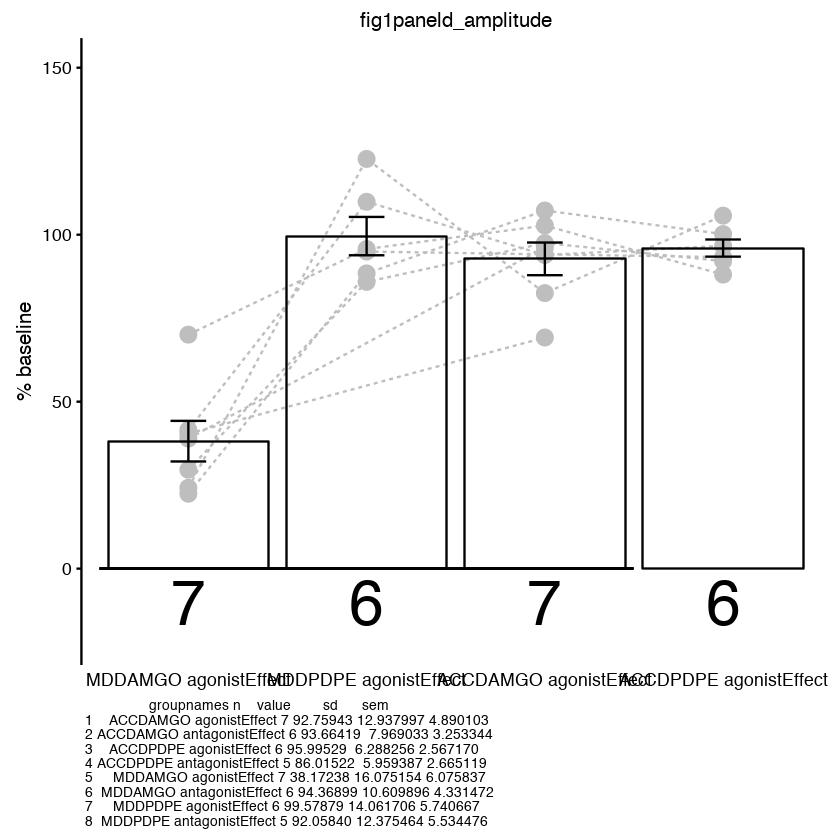

In [2]:
####################################################################################################
#     Figure 1 panel d
####################################################################################################
# Subset: two channel opto of ACC and MD wihtin DMS, recorded EPSC, from MSNs with DAMGO or DPDPE
tempSDF = subset(df, genoType != "MORKOho" & genoType != "MORWTho" & stimSource == "MD_ACC" & cellType == "MSN")
tempSDF = subset(tempSDF, signal == "EPSC" & agonistName == "MDDAMGO" | agonistName == "ACCDAMGO" | agonistName == "MDDPDPE"|agonistName == "ACCDPDPE")

#Important for good functioning of the script: No need to change:
cols = colnames(tempSDF)
tempSDF = melt(tempSDF, id.vars = cols[1:19],measure.vars = cols[20:21])

# give the tempSDF a specific name, needs to be changed for every new subset
sDf = subset(tempSDF, parameter == 'amplitude')
xLabel = c("MDDAMGO agonistEffect", "MDDPDPE agonistEffect", "ACCDAMGO agonistEffect","ACCDPDPE agonistEffect")
antagonistSelect = c("ENKWASH")
graphTitle = c("fig1paneld")

k = 1
variableSelect = 'amplitude'
#since we adding more groups to the plot we need to make a plottingColumn to tell what are the groups
sDf$groupnames = paste(sDf$agonistName, sDf$variable)
# to show also the data_summary of the antagonists we make a new dataframe: sDfFull, containing all the conditions
sDfFull = sDf
sDf = subset(sDf, variable == 'agonistEffect')
data_summary = data_meanSDSEM(sDf, varname = "value", groupnames = "groupnames")
animalCount = list()
for (u in 1:length(unique(sDf$groupnames))){
    animalDf = subset(sDf, groupnames == unique(sDf$groupnames)[u])
    animalCount[u] = length(unique(animalDf$animalID))
    }
# to show also the data_summary of the antagonists we use sDfFull containing all the conditions
data_summaryFull = data_meanSDSEM(sDfFull, varname = "value", groupnames = "groupnames")
sumOut = capture.output(data_summaryFull)
sumRepOut = sumOut[1]
for(u in 2:length(sumOut)){
  sumRepOut = paste(sumRepOut,'\n', sumOut[u])
}

ggplot(data_summary, aes(x = groupnames , y = value))+
    geom_point(data = sDf, aes(x = groupnames , y = value), fill = "gray", colour = "gray",size = 4)+
    geom_line(data = sDf, aes(group = cellID ), lty = 2, colour = "gray")+
    geom_bar(stat = "identity", position = position_dodge(), colour = "black", fill = NA)+
    geom_errorbar(aes(ymin=value-sem, ymax=value+sem), width=.2, position=position_dodge(.9))+
    coord_cartesian(ylim = c(-20,150))+
    theme_cowplot(font_size = 12)+
    stat_summary(data =sDf, fun.data = give.n, geom = "text",fun.y = median, position = position_dodge(width = 0.75), size = (6.51/8)*16)+
    scale_x_discrete(limits = xLabel)+
    labs(ylab('% baseline'))+
    labs(xlab(NULL))+
    labs(title = paste(graphTitle,variableSelect[k],sep='_'))+
    labs(caption = paste(sumRepOut))+
    theme(plot.caption = element_text(size = 8, hjust = 0))+
    theme(plot.title = element_text(size = 12))+
    geom_segment(aes(x=1, y=175, xend = 2, yend = 175))+
    geom_segment(aes(x=0.5, y=0, xend = 3.5, yend = 0))+
    theme(axis.line.x = element_line(linetype='blank'), axis.ticks.x = element_blank())+
    theme(text=element_text(size=12))

In [3]:
# Perform statistic on subsetted data:
trySDf =  melt(sDf, id.vars = c('cellID','baseName','agonistName','antagonistName'), measure.vars = c('baseValue','agonistValue','antagonistValue'))
trySDf$source <- sapply(strsplit(as.character(trySDf$baseName),'BASE'),'[',2)
trySDf$source <- sapply(strsplit(as.character(trySDf$source),'DAMGO'),'[',1)
trySDf$source <- sapply(strsplit(as.character(trySDf$source),'DPDPE'),'[',1)
trySDf$source = factor(trySDf$source, levels=unique(trySDf$source))
for (i in 1:nrow(trySDf)){
    trySDf$opioidType[i] = as.character(trySDf$agonistName[i])
    if (trySDf$variable[i]=='baseValue'){
        trySDf$drug[i] = as.character(trySDf$baseName[i])
    }
    else if (trySDf$variable[i] == 'agonistValue'){
        trySDf$drug[i] = as.character(trySDf$agonistName[i])
    }
    else if (trySDf$variable[i] == 'antagonistValue'){
        trySDf$drug[i] = as.character(trySDf$antagonistName[i])
    }
    if (is.finite(trySDf$value[i])){
        if (trySDf$value[i]>=-1 & trySDf$value[i] <=0){ # for some unknown reason not all values are properly converted from nA to pA
        trySDf$value[i] = trySDf$value[i]*1000
    }}
}

trySDf$drug = gsub("MD","",trySDf$drug)
trySDf$drug = gsub("ACC","",trySDf$drug)
trySDf$drug = factor(trySDf$drug, levels=unique(trySDf$drug))
trySDf$groupnames = paste(trySDf$drug, trySDf$source)
trySDf$opioidType = gsub("MD","",trySDf$opioidType)
trySDf$opioidType = gsub("ACC","",trySDf$opioidType)
trySDf$opioidType = gsub("DAMGO","mu",trySDf$opioidType)
trySDf$opioidType = gsub("DPDPE","delta",trySDf$opioidType)
trySDf$opioidType = factor(trySDf$opioidType, levels=unique(trySDf$opioidType))
ACCMD.df = data.frame(trySDf$cellID, trySDf$source, trySDf$drug, trySDf$opioidType, trySDf$value , trySDf$groupnames)
colnames(ACCMD.df) = c('cellID', 'source', 'period', 'opioidType', 'amplitude','groupnames')
ACCMD.df$period = gsub("BASEDPDPE","BASELINE",ACCMD.df$period)
ACCMD.df$period = gsub("BASEDAMGO","BASELINE",ACCMD.df$period)
ACCMD.df$period = gsub("DPDPENTD","ANTAGONIST",ACCMD.df$period)
ACCMD.df$period = gsub("DAMGOCTAP","ANTAGONIST",ACCMD.df$period)
ACCMD.df$period = gsub("DPDPE","AGONIST",ACCMD.df$period)
ACCMD.df$period = gsub("DAMGO","AGONIST",ACCMD.df$period)

ACCMD.df$groupnames = factor(ACCMD.df$groupnames,c('BASEDAMGO ACC','DAMGO ACC','DAMGOCTAP ACC',
                                      'BASEDAMGO MD','DAMGO MD','DAMGOCTAP MD',
                                      'BASEDPDPE ACC','DPDPE ACC','DPDPENTD ACC',
                                      'BASEDPDPE MD','DPDPE MD','DPDPENTD MD'))
ACCMD.df$period = factor (ACCMD.df$period,levels=c("BASELINE", "AGONIST", "ANTAGONIST"))
ACCMD.df$source = factor (ACCMD.df$source,levels=c("ACC","MD"))
ACCMD.df$opioidType = factor (ACCMD.df$opioidType,levels=c("delta","mu"))

In [4]:
library(lme4)
library(multcomp)
# We will be using linear combinatons of coefficients from the model to determine if differences between treatment groups are statisically significant. 
# When determining which coefficients to put in a linear combination, it's easiest to write out the equation for each group you are comparing 
# and subtract them. This leaves with the coefficient(s) they do not have in common.
# For instance: baseline vs. agonist for the ACC/delta condition (baseline, ACC and delta are the comparison groups)
#   Baseline equation: frequency = intercept (since baseline, ACC and delta are the comparison groups, the intercept is the only part of this equation)
#   Agonist equation:  frequency = intercept + periodAGONIST
#   Difference in equations: periodAGONIST
# Example 2: baseline vs. agonist for the MD/mu condition
#   Baseline equation: frequency = intercept + sourceMD + opioidTypemu + sourceMD:opioidTypemu 
#   Agonist equation : frequency = intercept + sourceMD + opioidTypemu + sourceMD:opioidTypemu + periodAGONIST + periodAGONIST:opioidTypemu + periodAGONIST:sourceMD:opioidTypemu 
#   Difference in equations: periodAGONIST + periodAGONIST:opioidTypemu + periodAGONIST:sourceMD:opioidTypemu

# To carry out these linear combinations first run the linear mixed effect model and save the results as an object (is this case I saved it as M0). 
# This object is then used in the glht command (general linear hypothesis test - this command works for contrasts and linear combinations). 
# In order to let R know which coefficients you would like to test in your linear combination, you need to create a matrix which indicates the coefficients.
# The matrix is based on the coefficients listed in the linear mixed effects regression output, in order from intercept to periodANTAGONIST:sourceMD:opioidTypemu - there
# are 12 coefficients total if you include the intercept.

M0.ACC <- lmer(data= ACCMD.df, amplitude ~ period + source + opioidType + opioidType:period + source:opioidType:period + source:opioidType + (1 | cellID), REML=FALSE)
summary(M0.ACC)
## Type III anova table with p-values for F-tests based on Satterthwaite's
## method:
aov.ACC <- anova(M0.ACC, type="3")
aov.ACC$Pvalue=pf(q=aov.ACC$F, df1 = aov.ACC$Df, df2 = length(unique(ACCMD.df$cellID)), lower.tail = FALSE)
aov.ACC

Loading required package: Matrix
Loading required package: mvtnorm
Loading required package: survival
Loading required package: TH.data
Loading required package: MASS

Attaching package: ‘TH.data’

The following object is masked from ‘package:MASS’:

    geyser



Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: amplitude ~ period + source + opioidType + opioidType:period +  
    source:opioidType:period + source:opioidType + (1 | cellID)
   Data: ACCMD.df

     AIC      BIC   logLik deviance df.resid 
   965.5    997.8   -468.8    937.5       60 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.70742 -0.60419  0.02248  0.68216  1.98156 

Random effects:
 Groups   Name        Variance Std.Dev.
 cellID   (Intercept)  6963     83.44  
 Residual             15705    125.32  
Number of obs: 74, groups:  cellID, 8

Fixed effects:
                                          Estimate Std. Error t value
(Intercept)                               -401.764     59.858  -6.712
periodAGONIST                               14.157     72.352   0.196
periodANTAGONIST                            22.092     76.426   0.289
sourceMD                                   -26.396     72.352  -0.365
opioidTypemu                            

,Df,Sum Sq,Mean Sq,F value,Pvalue
period,2,129222.342,64611.171,4.11418128,0.05905561
source,1,1014.627,1014.627,0.06460742,0.80576780
opioidType,1,4765.247,4765.247,0.30343188,0.59678183
period:opioidType,2,109605.134,54802.567,3.48960856,0.08135860
source:opioidType,1,12242.165,12242.165,0.77953216,0.40303452
period:source:opioidType,4,184569.192,46142.298,2.93815721,0.09094361


In [5]:
##Linear combinations testing baseline vs antagonist for each source and Rx type
##This double checks assumption of experimental design; that after antagonist treatment, amplitude returns to baseline.
##None of these comparisons are statistically significant, which is as expected
  ##baseline vs. antagonist, ACC and delta
    lc1a <- matrix(c(0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0), 1) 
    lincom1a.ACC <- glht(M0.ACC, linfct = lc1a)            
    summary(lincom1a.ACC) ##This is the same as the coefficient periodANTAGONIST
  ##baseline vs. antagonist, ACC and mu
    lc1b <- matrix(c(0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0), 1) 
    lincom1b.ACC <- glht(M0.ACC, linfct = lc1b)            
    summary(lincom1b.ACC)
  ##baseline vs. antagonist, MD and delta
    lc1c <- matrix(c(0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0), 1) 
    lincom1c.ACC <- glht(M0.ACC, linfct = lc1c)            
    summary(lincom1c.ACC)
  ##baseline vs. antagonist, MD and mu
    lc1d <- matrix(c(0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1), 1) 
    lincom1d.ACC <- glht(M0.ACC, linfct = lc1d)            
    summary(lincom1d.ACC)


	 Simultaneous Tests for General Linear Hypotheses

Fit: lmer(formula = amplitude ~ period + source + opioidType + opioidType:period + 
    source:opioidType:period + source:opioidType + (1 | cellID), 
    data = ACCMD.df, REML = FALSE)

Linear Hypotheses:
       Estimate Std. Error z value Pr(>|z|)
1 == 0    22.09      76.43   0.289    0.773
(Adjusted p values reported -- single-step method)



	 Simultaneous Tests for General Linear Hypotheses

Fit: lmer(formula = amplitude ~ period + source + opioidType + opioidType:period + 
    source:opioidType:period + source:opioidType + (1 | cellID), 
    data = ACCMD.df, REML = FALSE)

Linear Hypotheses:
       Estimate Std. Error z value Pr(>|z|)
1 == 0    34.28      70.15   0.489    0.625
(Adjusted p values reported -- single-step method)



	 Simultaneous Tests for General Linear Hypotheses

Fit: lmer(formula = amplitude ~ period + source + opioidType + opioidType:period + 
    source:opioidType:period + source:opioidType + (1 | cellID), 
    data = ACCMD.df, REML = FALSE)

Linear Hypotheses:
       Estimate Std. Error z value Pr(>|z|)
1 == 0    49.94      76.43   0.653    0.513
(Adjusted p values reported -- single-step method)



	 Simultaneous Tests for General Linear Hypotheses

Fit: lmer(formula = amplitude ~ period + source + opioidType + opioidType:period + 
    source:opioidType:period + source:opioidType + (1 | cellID), 
    data = ACCMD.df, REML = FALSE)

Linear Hypotheses:
       Estimate Std. Error z value Pr(>|z|)
1 == 0    41.32      70.15   0.589    0.556
(Adjusted p values reported -- single-step method)


In [6]:
##Linear combinations testing baseline vs agnoist for each source and Rx type
##This tests if the agonist had an effect on amplitude
##As expected, the only comparison that is statistically significant is for MD/mu     
  ##baseline vs. agonist, ACC and delta
    lc2a <- matrix(c(0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), 1) 
    lincom2a.ACC <- glht(M0.ACC, linfct = lc2a)            
    summary(lincom2a.ACC) ##This is claim 3
  ##baseline vs. agonist, ACC and mu
    lc2b <- matrix(c(0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0), 1) 
    lincom2b.ACC <- glht(M0.ACC, linfct = lc2b)            
    summary(lincom2b.ACC)
  ##baseline vs. agonist, MD and delta
    lc2c <- matrix(c(0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0), 1) 
    lincom2c.ACC <- glht(M0.ACC, linfct = lc2c)            
    summary(lincom2c.ACC) ##Second part of claim 3
  ##baseline vs. agonist, MD and mu
    lc2d <- matrix(c(0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0), 1) 
    lincom2d.ACC <- glht(M0.ACC, linfct = lc2d)            
    summary(lincom2d.ACC) ##This is claim 2


	 Simultaneous Tests for General Linear Hypotheses

Fit: lmer(formula = amplitude ~ period + source + opioidType + opioidType:period + 
    source:opioidType:period + source:opioidType + (1 | cellID), 
    data = ACCMD.df, REML = FALSE)

Linear Hypotheses:
       Estimate Std. Error z value Pr(>|z|)
1 == 0    14.16      72.35   0.196    0.845
(Adjusted p values reported -- single-step method)



	 Simultaneous Tests for General Linear Hypotheses

Fit: lmer(formula = amplitude ~ period + source + opioidType + opioidType:period + 
    source:opioidType:period + source:opioidType + (1 | cellID), 
    data = ACCMD.df, REML = FALSE)

Linear Hypotheses:
       Estimate Std. Error z value Pr(>|z|)
1 == 0    30.71      66.99   0.459    0.647
(Adjusted p values reported -- single-step method)



	 Simultaneous Tests for General Linear Hypotheses

Fit: lmer(formula = amplitude ~ period + source + opioidType + opioidType:period + 
    source:opioidType:period + source:opioidType + (1 | cellID), 
    data = ACCMD.df, REML = FALSE)

Linear Hypotheses:
       Estimate Std. Error z value Pr(>|z|)
1 == 0    7.664     72.352   0.106    0.916
(Adjusted p values reported -- single-step method)



	 Simultaneous Tests for General Linear Hypotheses

Fit: lmer(formula = amplitude ~ period + source + opioidType + opioidType:period + 
    source:opioidType:period + source:opioidType + (1 | cellID), 
    data = ACCMD.df, REML = FALSE)

Linear Hypotheses:
       Estimate Std. Error z value Pr(>|z|)    
1 == 0   317.36      66.99   4.738 2.16e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- single-step method)


# Figure 1 - figure supplement 1

## Figure 1 - figure supplement 1c

Warning message:
“Removed 8 rows containing non-finite values (stat_summary).”Warning message:
“Removed 8 rows containing missing values (geom_point).”Warning message:
“Removed 8 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_bar).”Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

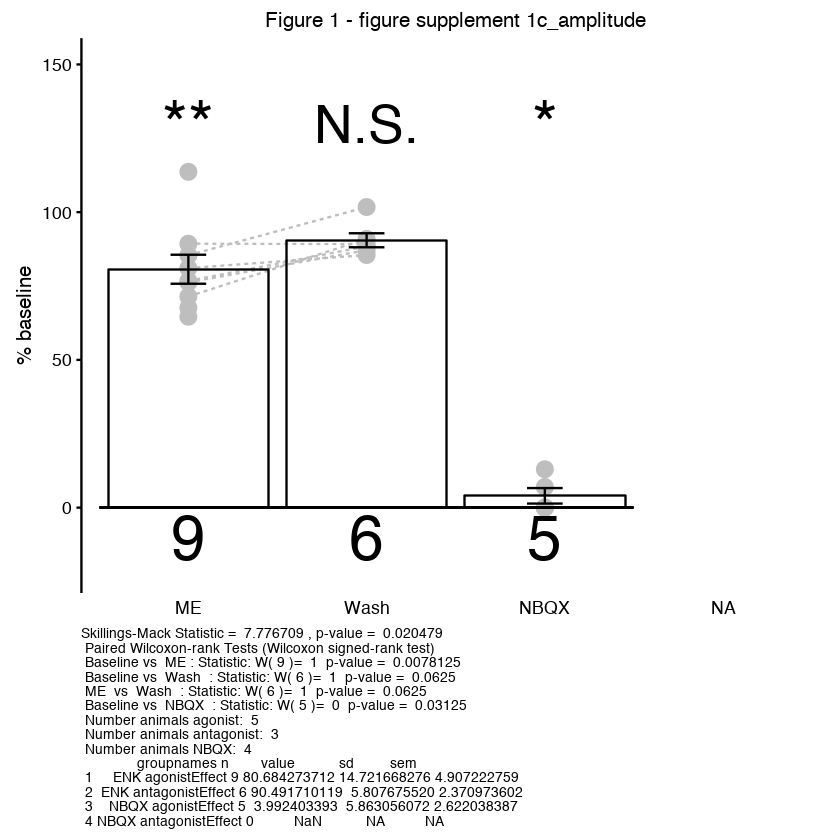

In [7]:
####################################################################################################
#     Figure 1 - figure supplement 1c
####################################################################################################
# Subset: electric stim in DMS, recorded EPSC, from MSNs with Enk/Wash/NBQX
tempSDF = subset(df, genoType != "MORKOho" & genoType != "MORWTho" & stimChannel == "Elec" & cellType == "MSN")
tempSDF = subset(tempSDF, signal == "EPSC" & agonistName == "ENK" | agonistName == "NBQX")

#Important for good functioning of the script: No need to change:
cols = colnames(tempSDF)
tempSDF = melt(tempSDF, id.vars = cols[1:19],measure.vars = cols[20:21])

# give the tempSDF a specific name, needs to be changed for every new subset
sDf = subset(tempSDF, parameter == 'amplitude')
xLabel = c("ME", "Wash", "NBQX")
antagonistSelect = c("ENKWASH")
graphTitle = c("Figure 1 - figure supplement 1c")

# prepare data into matrix for Skillings-Mack test.
ssDf = subset(sDf, variable == "agonistEffect")
ssDf = subset(ssDf, is.finite(baseValue)& is.finite(agonistValue))
# to avoid problems with sign reversal during agonist/antagonist treatment all conditions that show a different sign from baseValue are set to 0.0001
# after that the SMmatrix can be transformed to absolute values
for (u in 1:nrow(ssDf)){
    if (ssDf$baseValue[u]<0){
        if (is.finite(ssDf$agonistValue[u])){
            if (ssDf$agonistValue[u]>0){
                ssDf$agonistValue[u]=-0.0001
            }
        }
        if (is.finite(ssDf$antagonistValue[u])){
            if (ssDf$antagonistValue[u]>0){
                ssDf$antagonistValue[u]=-0.0001
            }
        }
    }
    if (ssDf$baseValue[u]>0){
        if (is.finite(ssDf$agonistValue[u])){
            if (ssDf$agonistValue[u]<0){
                ssDf$agonistValue[u]=0.0001
            }
        }
        if (is.finite(ssDf$antagonistValue[u])){
            if (ssDf$antagonistValue[u]<0){
                ssDf$antagonistValue[u]=0.0001
            }
        }
    }
    if (is.finite(ssDf$antagonistName[u])){
        if (ssDf$antagonistName[u] !=antagonistSelect){
            ssDf$antagonistValue[u] = NA
                                }
    }
}
for (u in 1:nrow(sDf)){
    if (is.finite(sDf$antagonistName[u])){
        if(sDf$antagonistName[u] != antagonistSelect){
            sDf$antagonistValue[u]= NA
            if(sDf$variable[u] == 'antagonistEffect'){
                sDf$value[u] = NA
            }
        }
    }
}
ssDf$baseValue = abs(ssDf$baseValue)
ssDf$agonistValue =abs(ssDf$agonistValue)
ssDf$antagonistValue = abs(ssDf$antagonistValue)

#check if ssDf$antagonistValue contains only 'NA's
checkNA = is.na(ssDf$antagonistValue)
if (sum(checkNA)==length(checkNA)){
    ssDf$antagonistValue[checkNA] = 0
}
# In case of the NBQX there is no repeated measures (the experiments stand on themselves as they
# are relative to baseline) So for the SM test we can only use the ENK data
SMlen = length(unique(ssDf$cellID[ssDf$agonistName == 'ENK']))
SMmatrix = c(ssDf$baseValue[ssDf$agonistName == 'ENK'][1:SMlen], ssDf$agonistValue[ssDf$agonistName == 'ENK'][1:SMlen], ssDf$antagonistValue[ssDf$agonistName == 'ENK'][1:SMlen])

Gs = c(rep('baseline',SMlen),rep('agonist',SMlen),rep('antagonist',SMlen))
Bs = rep(1:SMlen,3)

SMresult = capture.output(Ski.Mack(SMmatrix,groups=Gs, blocks=Bs))
BAgWilcox = wilcox.test(ssDf$baseValue[ssDf$agonistName == 'ENK'][1:SMlen],ssDf$agonistValue[ssDf$agonistName == 'ENK'][1:SMlen],paired = TRUE)
BAgWilcoxFlip = wilcox.test(ssDf$agonistValue[ssDf$agonistName == 'ENK'][1:SMlen],ssDf$baseValue[ssDf$agonistName == 'ENK'][1:SMlen],paired = TRUE)
BAgWilcox$statistic = min(c(BAgWilcox$statistic, BAgWilcoxFlip$statistic))
diff = c(ssDf$baseValue[ssDf$agonistName == 'ENK'][1:SMlen] - ssDf$agonistValue[ssDf$agonistName == 'ENK'][1:SMlen])
BAgWilcox$n = length(na.omit(diff[diff !=0]))

BAnWilcox = wilcox.test(ssDf$baseValue[ssDf$agonistName == 'ENK'][1:SMlen],ssDf$antagonistValue[ssDf$agonistName == 'ENK'][1:SMlen], paired = TRUE)
BAnWilcoxFlip = wilcox.test(ssDf$antagonistValue[ssDf$agonistName == 'ENK'][1:SMlen],ssDf$baseValue[ssDf$agonistName == 'ENK'][1:SMlen],paired = TRUE)
BAnWilcox$statistic = min(c(BAnWilcox$statistic, BAnWilcoxFlip$statistic))
diff = c(ssDf$baseValue[ssDf$agonistName == 'ENK'][1:SMlen] - ssDf$antagonistValue[ssDf$agonistName == 'ENK'][1:SMlen])
BAnWilcox$n = length(na.omit(diff[diff !=0]))

AgAnWilcox= wilcox.test(ssDf$agonistValue[ssDf$agonistName == 'ENK'][1:SMlen], ssDf$antagonistValue[ssDf$agonistName == 'ENK'][1:SMlen], paired = TRUE)
AgAnWilcoxFlip = wilcox.test(ssDf$antagonistValue[ssDf$agonistName == 'ENK'][1:SMlen],ssDf$agonistValue[ssDf$agonistName == 'ENK'][1:SMlen],paired = TRUE)
AgAnWilcox$statistic = min(c(AgAnWilcox$statistic, AgAnWilcoxFlip$statistic))
diff = c(ssDf$agonistValue[ssDf$agonistName == 'ENK'][1:SMlen] - ssDf$antagonistValue[ssDf$agonistName == 'ENK'][1:SMlen])
AgAnWilcox$n = length(na.omit(diff[diff !=0]))

# we will check whether it is significant smaller when NBQX is added, since we already know it is blocking glutamate
SMlen = length(unique(ssDf$cellID[ssDf$agonistName == 'NBQX']))
BNBQXWilcox = wilcox.test(ssDf$baseValue[ssDf$agonistName == 'NBQX'][1:SMlen],ssDf$agonistValue[ssDf$agonistName == 'NBQX'][1:SMlen],paired = TRUE, alternative = "greater")
BNBQXWilcoxFlip = wilcox.test(ssDf$agonistValue[ssDf$agonistName == 'NBQX'][1:SMlen],ssDf$baseValue[ssDf$agonistName == 'NBQX'][1:SMlen],paired = TRUE, alternative = "greater")
BNBQXWilcox$statistic = min(c(BNBQXWilcox$statistic, BNBQXWilcoxFlip$statistic))
diff = c(ssDf$baseValue[ssDf$agonistName == 'NBQX'][1:SMlen] - ssDf$agonistValue[ssDf$agonistName == 'NBQX'][1:SMlen])
BNBQXWilcox$n = length(na.omit(diff[diff !=0]))

BAgAnno = pvalAnno(BAgWilcox$p.value,1)
BAnAnno = pvalAnno(BAnWilcox$p.value,1)
AgAnAnno =  pvalAnno(AgAnWilcox$p.value,1)
BNBQXAnno = pvalAnno(BNBQXWilcox$p.value,1)
reportString = paste(SMresult[2],'\n','Paired Wilcoxon-rank Tests (Wilcoxon signed-rank test) \n Baseline vs ',xLabel[1], ': Statistic: W(',BAgWilcox$n,')= ',BAgWilcox$statistic,' p-value = ',signif(BAgWilcox$p.value),'\n Baseline vs ', xLabel[2],' : Statistic: W(',BAnWilcox$n,')= ',BAnWilcox$statistic,' p-value = ',signif(BAnWilcox$p.value),'\n',xLabel[1],' vs ', xLabel[2],' : Statistic: W(',AgAnWilcox$n,')= ',AgAnWilcox$statistic,' p-value = ',signif(AgAnWilcox$p.value),'\n','Baseline vs ', xLabel[3],' : Statistic: W(',BNBQXWilcox$n,')= ',BNBQXWilcox$statistic,' p-value = ',signif(BNBQXWilcox$p.value))
animalDf = subset(sDf, variable == 'agonistEffect' & agonistName == 'ENK' & is.finite(sDf$value))
agonistAnimal = length(unique(animalDf$animalID))
animalDf = subset(sDf, variable == 'antagonistEffect' & agonistName == 'ENK' & is.finite(sDf$value))
antagonistAnimal = length(unique(animalDf$animalID))
animalDf = subset(sDf, variable == 'agonistEffect' & agonistName == 'NBQX' & is.finite(sDf$value))
NBQXAnimal = length(unique(animalDf$animalID))
reportString = paste(reportString,'\n Number animals agonist: ',agonistAnimal,'\n Number animals antagonist: ', antagonistAnimal,'\n Number animals NBQX: ', NBQXAnimal)

k = 1
variableSelect = 'amplitude'
#since we adding more groups to the plot we need to make a plottingColumn to tell what are the groups
sDf$groupnames = paste(sDf$agonistName, sDf$variable)
data_summary = data_meanSDSEM(sDf, varname = "value", groupnames = "groupnames")
sumOut = capture.output(data_summary)
sumRepOut = sumOut[1]
for(u in 2:length(sumOut)){
  sumRepOut = paste(sumRepOut,'\n', sumOut[u])
}

ggplot(data_summary, aes(x = groupnames , y = value))+
    geom_point(data = sDf, aes(x = groupnames , y = value), fill = "gray", colour = "gray",size = 4)+
    geom_line(data = sDf, aes(group = cellID ), lty = 2, colour = "gray")+
    geom_bar(stat = "identity", position = position_dodge(), colour = "black", fill = NA)+
    geom_errorbar(aes(ymin=value-sem, ymax=value+sem), width=.2, position=position_dodge(.9))+
    coord_cartesian(ylim = c(-20,150))+
    theme_cowplot(font_size = 12)+
    stat_summary(data =sDf, fun.data = give.n, geom = "text",fun.y = median, position = position_dodge(width = 0.75), size = (6.51/8)*16)+
    annotate("text", x=1, y=130, label = BAgAnno[1], size = as.numeric(BAgAnno[2]), fontface = as.numeric(BAgAnno[3]))+
    annotate("text", x=2, y=130, label = BAnAnno[1], size =  as.numeric(BAnAnno[2]), fontface = as.numeric(BAnAnno[3]))+
    annotate("text", x=3, y=130, label = BNBQXAnno[1], size =  as.numeric(BNBQXAnno[2]), fontface = as.numeric(BNBQXAnno[3]))+
    scale_x_discrete(labels = xLabel)+
    labs(ylab('% baseline'))+
    labs(xlab(NULL))+
    labs(title = paste(graphTitle,variableSelect[k],sep='_'))+
    labs(caption = paste(reportString,'\n',sumRepOut))+
    theme(plot.caption = element_text(size = 8, hjust = 0))+
    theme(plot.title = element_text(size = 12))+
    geom_segment(aes(x=1, y=175, xend = 2, yend = 175))+
    geom_segment(aes(x=0.5, y=0, xend = 3.5, yend = 0))+
    theme(axis.line.x = element_line(linetype='blank'), axis.ticks.x = element_blank())+
    theme(text=element_text(size=12))

## Figure 1 - figure supplement 1e

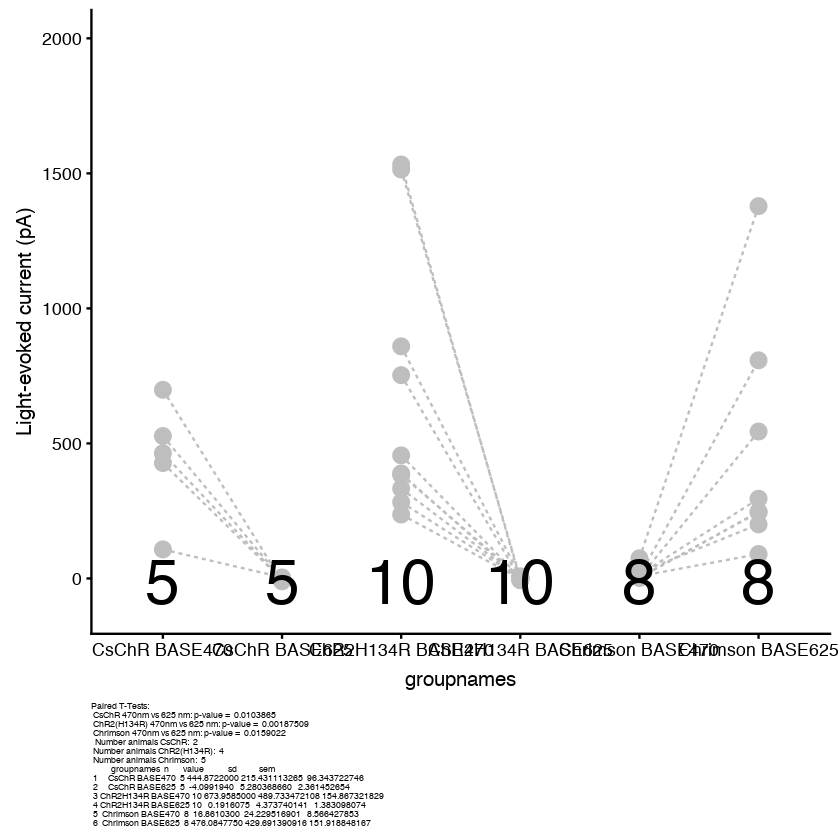

In [8]:
####################################################################################################
#     Supplementary Figure 1d panel E
####################################################################################################
#plot light-evoked currents for the different channels with 473 and 625 nm
chan = subset(df, baseName =="BASE470" & stimChannel !="ChR2H134R_Chrimson" & stimChannel != "CsChR_Chrimson")
chanDf = melt(chan, id.vars = c("cellID","animalID","stimChannel","baseName","agonistName"), measure.vars = c("baseValue","agonistValue"))
chanDf$variable = gsub("baseValue","BASE470",chanDf$variable)
chanDf$value = chanDf$value*-1
chanDf$variable = gsub("agonistValue","BASE625",chanDf$variable)
chanDf$groupnames = paste(chanDf$stimChannel,chanDf$variable)

chanDf$groupnames = factor(chanDf$groupnames, levels = c("CsChR BASE470","CsChR BASE625","ChR2H134R BASE470","ChR2H134R BASE625","Chrimson BASE470","Chrimson BASE625"))

cschrTtest = t.test(chanDf$value[chanDf$groupnames=="CsChR BASE470"], chanDf$value[chanDf$groupnames=="CsChR BASE625"], paired = TRUE)
chr2Ttest = t.test(chanDf$value[chanDf$groupnames=="ChR2H134R BASE470"], chanDf$value[chanDf$groupnames=="ChR2H134R BASE625"], paired = TRUE)
chrimsonTtest = t.test(chanDf$value[chanDf$groupnames=="Chrimson BASE470"], chanDf$value[chanDf$groupnames=="Chrimson BASE625"], paired = TRUE)
cschrAnno = pvalAnno(cschrTtest$p.value,1)
chr2Anno = pvalAnno(chr2Ttest$p.value,1)
chrimsonAnno = pvalAnno(chrimsonTtest$p.value,1)
reportString1 = paste('Paired T-Tests: \n CsChR 470nm vs 625 nm: p-value = ',signif(cschrTtest$p.value),
                     '\n ChR2(H134R) 470nm vs 625 nm: p-value = ',signif(chr2Ttest$p.value),
                     '\n Chrimson 470nm vs 625 nm: p-value = ',signif(chrimsonTtest$p.value))

animalDf = subset(chanDf, is.finite(chanDf$value) & groupnames == 'CsChR BASE470' | is.finite(chanDf$value) & groupnames == 'CsChR BASE625')
cschrAnimal = length(unique(animalDf$animalID))
animalDf = subset(chanDf, is.finite(chanDf$value) & groupnames == 'ChR2H134R BASE470' | is.finite(chanDf$value) & groupnames == 'ChR2H134R BASE625')
chr2H134rAnimal = length(unique(animalDf$animalID))
animalDf = subset(chanDf, is.finite(chanDf$value) & groupnames == 'Chrimson BASE470' | is.finite(chanDf$value) & groupnames == 'Chrimson BASE625')
chrimsonAnimal = length(unique(animalDf$animalID))
reportString2 = paste(' Number animals CsChR: ',cschrAnimal,'\n Number animals ChR2(H134R): ',chr2H134rAnimal,'\n Number animals Chrimson: ',chrimsonAnimal)
data_summary = data_meanSDSEM(chanDf, varname = "value", groupnames = "groupnames")
sumOut = capture.output(data_summary)
sumRepOut = sumOut[1]
for(u in 2:length(sumOut)){
  sumRepOut = paste(sumRepOut,'\n', sumOut[u])
}


ggplot(chanDf, aes(x = groupnames , y = value))+
  geom_point(data = chanDf, aes(x = groupnames , y = value), fill = "gray", colour = "gray",size = 4)+
  geom_line(data = chanDf, aes(group = cellID ), lty = 2, colour = "gray")+
  coord_cartesian(ylim = c(-100,2000))+
  theme_cowplot(font_size = 12)+
  stat_summary(data =chanDf, fun.data = give.n, geom = "text",fun.y = median, position = position_dodge(width = 0.75), size = (6.51/8)*16)+
  labs(ylab('Light-evoked current (pA)'))+
  labs(caption = reportString)+
  labs(caption = paste(reportString1,"\n", reportString2,'\n',sumRepOut))+
  theme(plot.caption = element_text(size = 5, hjust = 0))+
  theme(plot.title = element_text(size = 12))+
  theme(text=element_text(size=12))

## Figure 1 - figure supplement 1h

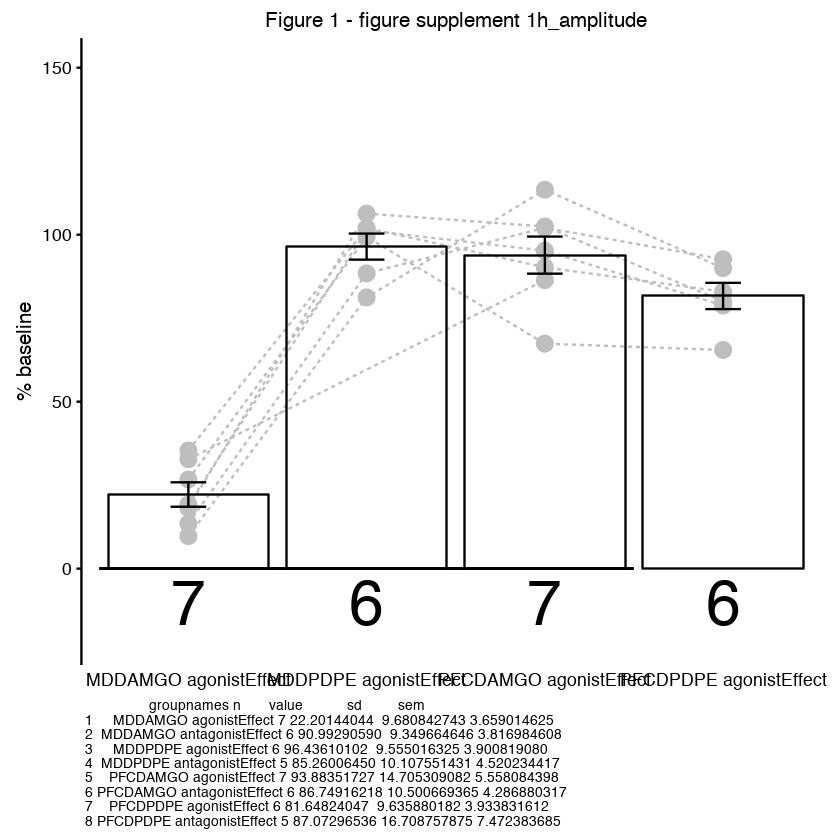

In [9]:
####################################################################################################
#     Supplementary Figure 1e panel C
####################################################################################################
# Subset: two channel opto of PFC and MD wihtin DMS, recorded EPSC, from MSNs with DAMGO or DPDPE
tempSDF = subset(df, genoType != "MORKOho" & genoType != "MORWTho" & stimSource == "MD_PFC" & cellType == "MSN")
tempSDF = subset(tempSDF, signal == "EPSC" & agonistName == "MDDAMGO" | agonistName == "PFCDAMGO" | agonistName == "MDDPDPE"|agonistName == "PFCDPDPE")

#Important for good functioning of the script: No need to change:
cols = colnames(tempSDF)
tempSDF = melt(tempSDF, id.vars = cols[1:19],measure.vars = cols[20:21])

# give the tempSDF a specific name, needs to be changed for every new subset
sDf = subset(tempSDF, parameter == 'amplitude')
xLabel = c("MDDAMGO agonistEffect", "MDDPDPE agonistEffect", "PFCDAMGO agonistEffect","PFCDPDPE agonistEffect")
antagonistSelect = c("ENKWASH")
graphTitle = c("Figure 1 - figure supplement 1h")

k = 1
variableSelect = 'amplitude'
#since we adding more groups to the plot we need to make a plottingColumn to tell what are the groups
sDf$groupnames = paste(sDf$agonistName, sDf$variable)
# to show also the data_summary of the antagonists we use sDfFull containing all the conditions
sDfFull = sDf

sDf = subset(sDf, variable == 'agonistEffect')
data_summary = data_meanSDSEM(sDf, varname = "value", groupnames = "groupnames")
animalCount = list()
for (u in 1:length(unique(sDf$groupnames))){
    animalDf = subset(sDf, groupnames == unique(sDf$groupnames)[u])
    animalCount[u] = length(unique(animalDf$animalID))
    }

# to show also the data_summary of the antagonists we use sDfFull containing all the conditions
data_summaryFull = data_meanSDSEM(sDfFull, varname = "value", groupnames = "groupnames")
sumOut = capture.output(data_summaryFull)
sumRepOut = sumOut[1]
for(u in 2:length(sumOut)){
  sumRepOut = paste(sumRepOut,'\n', sumOut[u])
}

ggplot(data_summary, aes(x = groupnames , y = value))+
    geom_point(data = sDf, aes(x = groupnames , y = value), fill = "gray", colour = "gray",size = 4)+
    geom_line(data = sDf, aes(group = cellID ), lty = 2, colour = "gray")+
    geom_bar(stat = "identity", position = position_dodge(), colour = "black", fill = NA)+
    geom_errorbar(aes(ymin=value-sem, ymax=value+sem), width=.2, position=position_dodge(.9))+
    coord_cartesian(ylim = c(-20,150))+
    theme_cowplot(font_size = 12)+
    stat_summary(data =sDf, fun.data = give.n, geom = "text",fun.y = median, position = position_dodge(width = 0.75), size = (6.51/8)*16)+
    scale_x_discrete(limits = xLabel)+
    labs(ylab('% baseline'))+
    labs(xlab(NULL))+
    labs(title = paste(graphTitle,variableSelect[k],sep='_'))+
    labs(caption = sumRepOut)+
    theme(plot.caption = element_text(size = 8, hjust = 0))+
    theme(plot.title = element_text(size = 12))+
    geom_segment(aes(x=1, y=175, xend = 2, yend = 175))+
    geom_segment(aes(x=0.5, y=0, xend = 3.5, yend = 0))+
    theme(axis.line.x = element_line(linetype='blank'), axis.ticks.x = element_blank())+
    theme(text=element_text(size=12))

In [10]:
## Similar to figure 1d, subset PFC/MD and perform LLM 
trySDf =  melt(sDf, id.vars = c('cellID','baseName','agonistName','antagonistName'), measure.vars = c('baseValue','agonistValue','antagonistValue'))
trySDf$source <- sapply(strsplit(as.character(trySDf$baseName),'BASE'),'[',2)
trySDf$source <- sapply(strsplit(as.character(trySDf$source),'DAMGO'),'[',1)
trySDf$source <- sapply(strsplit(as.character(trySDf$source),'DPDPE'),'[',1)
trySDf$source = factor(trySDf$source, levels=unique(trySDf$source))
for (i in 1:nrow(trySDf)){
    trySDf$opioidType[i] = as.character(trySDf$agonistName[i])
    if (trySDf$variable[i]=='baseValue'){
        trySDf$drug[i] = as.character(trySDf$baseName[i])
    }
    else if (trySDf$variable[i] == 'agonistValue'){
        trySDf$drug[i] = as.character(trySDf$agonistName[i])
    }
    else if (trySDf$variable[i] == 'antagonistValue'){
        trySDf$drug[i] = as.character(trySDf$antagonistName[i])
    }
    if (is.finite(trySDf$value[i])){
        if (trySDf$value[i]>=-1 & trySDf$value[i] <=0){
        trySDf$value[i] = trySDf$value[i]*1000
    }}
}
trySDf$drug = gsub("MD","",trySDf$drug)
trySDf$drug = gsub("PFC","",trySDf$drug)
trySDf$drug = factor(trySDf$drug, levels=unique(trySDf$drug))
trySDf$groupnames = paste(trySDf$drug, trySDf$source)
trySDf$opioidType = gsub("MD","",trySDf$opioidType)
trySDf$opioidType = gsub("PFC","",trySDf$opioidType)
trySDf$opioidType = gsub("DAMGO","mu",trySDf$opioidType)
trySDf$opioidType = gsub("DPDPE","delta",trySDf$opioidType)
trySDf$opioidType = factor(trySDf$opioidType, levels=unique(trySDf$opioidType))
PFCMD.df = data.frame(trySDf$cellID, trySDf$source, trySDf$drug, trySDf$opioidType, trySDf$value , trySDf$groupnames)
colnames(PFCMD.df) = c('cellID', 'source', 'period', 'opioidType', 'amplitude','groupnames')
PFCMD.df$period = gsub("BASEDPDPE","BASELINE",PFCMD.df$period)
PFCMD.df$period = gsub("BASEDAMGO","BASELINE",PFCMD.df$period)
PFCMD.df$period = gsub("DPDPENTD","ANTAGONIST",PFCMD.df$period)
PFCMD.df$period = gsub("DAMGOCTAP","ANTAGONIST",PFCMD.df$period)
PFCMD.df$period = gsub("DPDPE","AGONIST",PFCMD.df$period)
PFCMD.df$period = gsub("DAMGO","AGONIST",PFCMD.df$period)

PFCMD.df$groupnames = factor(PFCMD.df$groupnames,c('BASEDAMGO PFC','DAMGO PFC','DAMGOCTAP PFC',
                                      'BASEDAMGO MD','DAMGO MD','DAMGOCTAP MD',
                                      'BASEDPDPE PFC','DPDPE PFC','DPDPENTD PFC',
                                      'BASEDPDPE MD','DPDPE MD','DPDPENTD MD'))
PFCMD.df$period = factor (PFCMD.df$period,levels=c("BASELINE", "AGONIST", "ANTAGONIST"))
PFCMD.df$source = factor (PFCMD.df$source,levels=c("PFC","MD"))
PFCMD.df$opioidType = factor (PFCMD.df$opioidType,levels=c("delta","mu"))
M0.PFC <- lmer(data= PFCMD.df, amplitude ~ period + source + opioidType + opioidType:period + source:opioidType:period + source:opioidType + (1 | cellID), REML=FALSE)
summary(M0.PFC)
## Type III anova table with p-values for F-tests based on Satterthwaite's
## method:
aov.PFC <- anova(M0.PFC, type="3")
aov.PFC$Pvalue=pf(q=aov.PFC$F, df1 = aov.PFC$Df, df2 = length(unique(PFCMD.df$cellID)), lower.tail = FALSE)
aov.PFC

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: amplitude ~ period + source + opioidType + opioidType:period +  
    source:opioidType:period + source:opioidType + (1 | cellID)
   Data: PFCMD.df

     AIC      BIC   logLik deviance df.resid 
  1015.6   1047.8   -493.8    987.6       60 

Scaled residuals: 
        Min          1Q      Median          3Q         Max 
-2.52346015 -0.62057228  0.05152351  0.67664902  1.85540157 

Random effects:
 Groups   Name        Variance Std.Dev.
 cellID   (Intercept) 25398.50 159.3691
 Residual             29461.46 171.6434
Number of obs: 74, groups:  cellID, 7

Fixed effects:
                                             Estimate  Std. Error  t value
(Intercept)                               -437.826415   92.938000 -4.71095
periodAGONIST                               66.548367   99.098363  0.67154
periodANTAGONIST                            21.267651  104.361194  0.20379
sourceMD                                    82.446333   99.0

,Df,Sum Sq,Mean Sq,F value,Pvalue
period,2,148098.912956,74049.456478,2.51343499097,0.15042117751
source,1,169852.237633,169852.237633,5.76523552860,0.04739016688
opioidType,1,2814.370919,2814.370919,0.09552721493,0.76626101068
period:opioidType,2,64604.571482,32302.285741,1.09642526943,0.38527199585
source:opioidType,1,10767.419582,10767.419582,0.36547478438,0.56455418868
period:source:opioidType,4,255891.886462,63972.971616,2.17141236388,0.17443974406


In [11]:
##Linear combinations testing baseline vs antagonist for each source and Rx type
##This double checks assumption of experimental design; that after antagonist treatment, amplitude returns to baseline.
##None of these comparisons are statistically significant, which is as expected
  ##baseline vs. antagonist, PFC and delta
    lc1a <- matrix(c(0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0), 1) 
    lincom1a.PFC <- glht(M0.PFC, linfct = lc1a)            
    summary(lincom1a.PFC) ##This is the same as the coefficient periodANTAGONIST
  ##baseline vs. antagonist, PFC and mu
    lc1b <- matrix(c(0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0), 1) 
    lincom1b.PFC <- glht(M0.PFC, linfct = lc1b)            
    summary(lincom1b.PFC)
  ##baseline vs. antagonist, MD and delta
    lc1c <- matrix(c(0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0), 1) 
    lincom1c.PFC <- glht(M0.PFC, linfct = lc1c)            
    summary(lincom1c.PFC)
  ##baseline vs. antagonist, MD and mu
    lc1d <- matrix(c(0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1), 1) 
    lincom1d.PFC <- glht(M0.PFC, linfct = lc1d)            
    summary(lincom1d.PFC)


	 Simultaneous Tests for General Linear Hypotheses

Fit: lmer(formula = amplitude ~ period + source + opioidType + opioidType:period + 
    source:opioidType:period + source:opioidType + (1 | cellID), 
    data = PFCMD.df, REML = FALSE)

Linear Hypotheses:
        Estimate Std. Error z value Pr(>|z|)
1 == 0  21.26765  104.36119 0.20379  0.83852
(Adjusted p values reported -- single-step method)



	 Simultaneous Tests for General Linear Hypotheses

Fit: lmer(formula = amplitude ~ period + source + opioidType + opioidType:period + 
    source:opioidType:period + source:opioidType + (1 | cellID), 
    data = PFCMD.df, REML = FALSE)

Linear Hypotheses:
       Estimate Std. Error z value Pr(>|z|)
1 == 0 48.68762   95.83388 0.50804  0.61142
(Adjusted p values reported -- single-step method)



	 Simultaneous Tests for General Linear Hypotheses

Fit: lmer(formula = amplitude ~ period + source + opioidType + opioidType:period + 
    source:opioidType:period + source:opioidType + (1 | cellID), 
    data = PFCMD.df, REML = FALSE)

Linear Hypotheses:
        Estimate Std. Error z value Pr(>|z|)
1 == 0  47.31502  104.36119 0.45338  0.65028
(Adjusted p values reported -- single-step method)



	 Simultaneous Tests for General Linear Hypotheses

Fit: lmer(formula = amplitude ~ period + source + opioidType + opioidType:period + 
    source:opioidType:period + source:opioidType + (1 | cellID), 
    data = PFCMD.df, REML = FALSE)

Linear Hypotheses:
       Estimate Std. Error z value Pr(>|z|)
1 == 0 23.20493   95.83388 0.24214  0.80867
(Adjusted p values reported -- single-step method)


In [12]:
##Linear combinations testing baseline vs agnoist for each source and Rx type
##This tests if the agonist had an effect on amplitude
##As expected, the only comparison that is statistically significant is for MD/mu     
  ##baseline vs. agonist, PFC and delta
    lc2a <- matrix(c(0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), 1) 
    lincom2a.PFC <- glht(M0.PFC, linfct = lc2a)            
    summary(lincom2a.PFC) ##This is claim 3
  ##baseline vs. agonist, PFC and mu
    lc2b <- matrix(c(0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0), 1) 
    lincom2b.PFC <- glht(M0.PFC, linfct = lc2b)            
    summary(lincom2b.PFC)
  ##baseline vs. agonist, MD and delta
    lc2c <- matrix(c(0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0), 1) 
    lincom2c.PFC <- glht(M0.PFC, linfct = lc2c)            
    summary(lincom2c.PFC) ##Second part of claim 3
  ##baseline vs. agonist, MD and mu
    lc2d <- matrix(c(0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0), 1) 
    lincom2d.PFC <- glht(M0.PFC, linfct = lc2d)            
    summary(lincom2d.PFC) ##This is claim 2


	 Simultaneous Tests for General Linear Hypotheses

Fit: lmer(formula = amplitude ~ period + source + opioidType + opioidType:period + 
    source:opioidType:period + source:opioidType + (1 | cellID), 
    data = PFCMD.df, REML = FALSE)

Linear Hypotheses:
       Estimate Std. Error z value Pr(>|z|)
1 == 0 66.54837   99.09836 0.67154  0.50188
(Adjusted p values reported -- single-step method)



	 Simultaneous Tests for General Linear Hypotheses

Fit: lmer(formula = amplitude ~ period + source + opioidType + opioidType:period + 
    source:opioidType:period + source:opioidType + (1 | cellID), 
    data = PFCMD.df, REML = FALSE)

Linear Hypotheses:
        Estimate Std. Error z value Pr(>|z|)
1 == 0  4.802571  91.747257 0.05235  0.95825
(Adjusted p values reported -- single-step method)



	 Simultaneous Tests for General Linear Hypotheses

Fit: lmer(formula = amplitude ~ period + source + opioidType + opioidType:period + 
    source:opioidType:period + source:opioidType + (1 | cellID), 
    data = PFCMD.df, REML = FALSE)

Linear Hypotheses:
        Estimate Std. Error z value Pr(>|z|)
1 == 0  8.589333  99.098363 0.08667  0.93093
(Adjusted p values reported -- single-step method)



	 Simultaneous Tests for General Linear Hypotheses

Fit: lmer(formula = amplitude ~ period + source + opioidType + opioidType:period + 
    source:opioidType:period + source:opioidType + (1 | cellID), 
    data = PFCMD.df, REML = FALSE)

Linear Hypotheses:
        Estimate Std. Error z value   Pr(>|z|)    
1 == 0 320.84493   91.74726 3.49705 0.00047043 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- single-step method)


In [13]:
##Linear combination comparing the difference in baseline and agnoist for MD vs PFC when Rx=mu 
  ##when rx=mu: (baseline vs. agonist for PFC) vs. (baseline vs. agonist for MD) - this is a difference in difference 
    lc3PFC <- matrix(c(0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0), 1) 
    lc3MD  <- matrix(c(0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0), 1) 
    lc3 <- lc3PFC - lc3MD
    lincom3.PFC <- glht(M0.PFC, linfct = lc3)            
    summary(lincom3.PFC) ##This is claim 1


	 Simultaneous Tests for General Linear Hypotheses

Fit: lmer(formula = amplitude ~ period + source + opioidType + opioidType:period + 
    source:opioidType:period + source:opioidType + (1 | cellID), 
    data = PFCMD.df, REML = FALSE)

Linear Hypotheses:
        Estimate Std. Error  z value Pr(>|z|)  
1 == 0 -316.0424   129.7502 -2.43578  0.01486 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- single-step method)


# Figure 1 - figure supplement 2
## Figure 1 - figure supplement 2c

Warning message:
“Removed 7 rows containing non-finite values (stat_summary).”Warning message:
“Removed 7 rows containing missing values (geom_point).”Warning message:
“Removed 7 rows containing missing values (geom_path).”

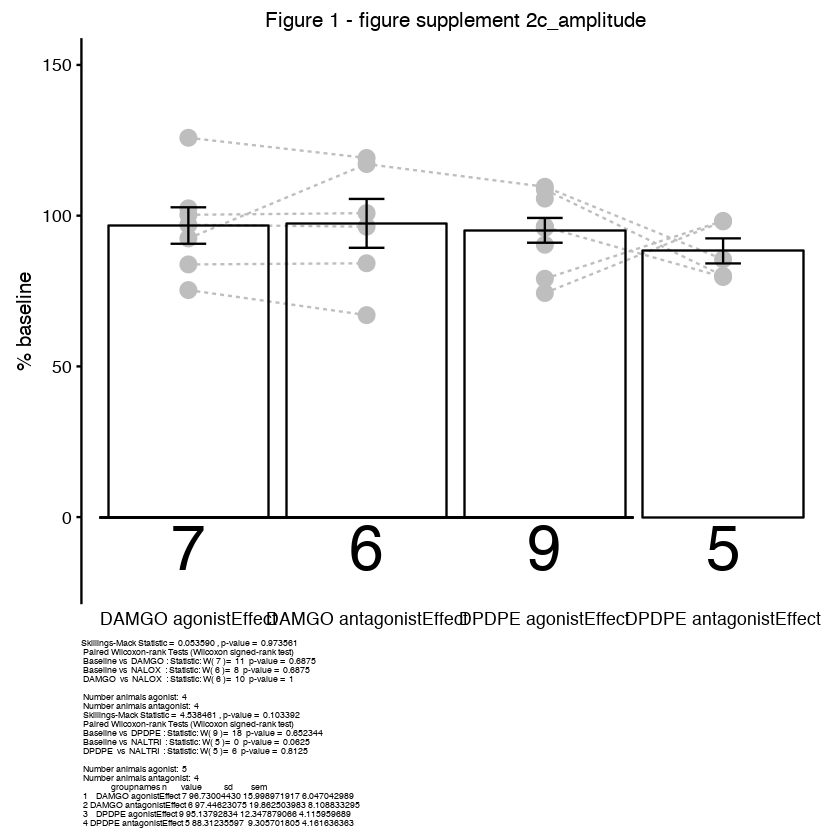

In [14]:
####################################################################################################
#     Figure 1 - figure supplement 2c
####################################################################################################
# Subset: opto stim ACC to DMS, recorded EPSC, from MSNs with DAMGO/DPDPE/antagonists
tempSDF = subset(df, genoType != "MORKOho" & genoType != "MORWTho" & stimSource == "ACC" & cellType == "MSN")
tempSDF = subset(tempSDF, signal == "EPSC" & agonistName == "DAMGO" | agonistName == "DPDPE")

#Important for good functioning of the script: No need to change:
cols = colnames(tempSDF)
tempSDF = melt(tempSDF, id.vars = cols[1:19],measure.vars = cols[20:21])

# give the tempSDF a specific name, needs to be changed for every new subset
sDf = subset(tempSDF, parameter == 'amplitude')
xLabel = c("DAMGO", "NALOX", "DPDPE","NALTRI")
antagonistSelect = c("DAMGONALOX","DPDPENALTRI")
graphTitle = c("Figure 1 - figure supplement 2c")

# prepare data into matrix for Skillings-Mack test.
ssDf = subset(sDf, variable == "agonistEffect" | variable == "antagonistEffect")
ssDf = subset(ssDf, is.finite(baseValue)& is.finite(agonistValue))
# # to avoid problems with sign reversal during agonist/antagonist treatment all conditions that show a different sign from baseValue are set to 0.0001
# # after that the SMmatrix can be transformed to absolute values
for (u in 1:nrow(ssDf)){
    if (ssDf$baseValue[u]<0){
        if (is.finite(ssDf$agonistValue[u])){
            if (ssDf$agonistValue[u]>0){
                ssDf$agonistValue[u]=-0.0001
            }
        }
        if (is.finite(ssDf$antagonistValue[u])){
            if (ssDf$antagonistValue[u]>0){
                ssDf$antagonistValue[u]=-0.0001
            }
        }
    }
    if (ssDf$baseValue[u]>0){
        if (is.finite(ssDf$agonistValue[u])){
            if (ssDf$agonistValue[u]<0){
                ssDf$agonistValue[u]=0.0001
            }
        }
        if (is.finite(ssDf$antagonistValue[u])){
            if (ssDf$antagonistValue[u]<0){
                ssDf$antagonistValue[u]=0.0001
            }
        }
    }
    if (is.finite(ssDf$antagonistName[u])){
        if (ssDf$antagonistName[u] !=antagonistSelect[1] & ssDf$antagonistName[u] !=antagonistSelect[2]){
            ssDf$antagonistValue[u] = NA
                                }
    }
}
ssDf$baseValue = abs(ssDf$baseValue)
ssDf$agonistValue =abs(ssDf$agonistValue)
ssDf$antagonistValue = abs(ssDf$antagonistValue)

# In this graph we will be having two sets of repeated measures omnibus test. Thus run first DAMGO followed by DPDPE

# DAMGO
##########
SMlen = length(unique(ssDf$cellID[ssDf$agonistName == 'DAMGO']))
SMmatrix = c(ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen], ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen], ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen])
Gs = c(rep('baseline',SMlen),rep('agonist',SMlen),rep('antagonist',SMlen))
Bs = rep(1:SMlen,3)

SMresult = capture.output(Ski.Mack(SMmatrix,groups=Gs, blocks=Bs))
# Turns out that the statistic needs to be reported differently. One need the number of pairs(n) that have difference != 0. And the lowest signed rank sum value (x) is given. Denoted as W(n)=x. Thus per comparison the number of pairs with difference !=0 and the lowest signed rank sum value needs to be calculated

BAgWilcox = wilcox.test(ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen],ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen],paired = TRUE)
BAgWilcoxFlip = wilcox.test(ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen],ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen],paired = TRUE)
BAgWilcox$statistic = min(c(BAgWilcox$statistic, BAgWilcoxFlip$statistic))
diff = c(ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen] - ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen])
BAgWilcox$n = length(na.omit(diff[diff !=0]))

BAnWilcox = wilcox.test(ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen],ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen], paired = TRUE)
BAnWilcoxFlip = wilcox.test(ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen],ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen],paired = TRUE)
BAnWilcox$statistic = min(c(BAnWilcox$statistic, BAnWilcoxFlip$statistic))
diff = c(ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen] - ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen])
BAnWilcox$n = length(na.omit(diff[diff !=0]))

AgAnWilcox= wilcox.test(ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen], ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen], paired = TRUE)
AgAnWilcoxFlip = wilcox.test(ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen],ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen],paired = TRUE)
AgAnWilcox$statistic = min(c(AgAnWilcox$statistic, AgAnWilcoxFlip$statistic))
diff = c(ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen] - ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen])
AgAnWilcox$n = length(na.omit(diff[diff !=0]))

BAgAnno = pvalAnno(BAgWilcox$p.value,1)
BAnAnno = pvalAnno(BAnWilcox$p.value,1)
AgAnAnno =  pvalAnno(AgAnWilcox$p.value,1)
BNBQXAnno = pvalAnno(BNBQXWilcox$p.value,1)

reportString = paste(SMresult[2],'\n','Paired Wilcoxon-rank Tests (Wilcoxon signed-rank test) \n Baseline vs ',xLabel[1], ': Statistic: W(',BAgWilcox$n,')= ',BAgWilcox$statistic,' p-value = ',signif(BAgWilcox$p.value),'\n Baseline vs ', xLabel[2],' : Statistic: W(',BAnWilcox$n,')= ',BAnWilcox$statistic,' p-value = ',signif(BAnWilcox$p.value),'\n',xLabel[1],' vs ', xLabel[2],' : Statistic: W(',AgAnWilcox$n,')= ',AgAnWilcox$statistic,' p-value = ',signif(AgAnWilcox$p.value),'\n')
animalDf = subset(sDf, variable == 'agonistEffect' & agonistName == 'DAMGO' & is.finite(sDf$value))
agonistAnimal = length(unique(animalDf$animalID))
animalDf = subset(sDf, variable == 'antagonistEffect' & agonistName == 'DAMGO' & is.finite(sDf$value))
antagonistAnimal = length(unique(animalDf$animalID))
reportString1 = paste(reportString,'\n Number animals agonist: ',agonistAnimal,'\n Number animals antagonist: ', antagonistAnimal)

# DPDPE
##########
SMlen = length(unique(ssDf$cellID[ssDf$agonistName == 'DPDPE']))
SMmatrix = c(ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen], ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen], ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen])
Gs = c(rep('baseline',SMlen),rep('agonist',SMlen),rep('antagonist',SMlen))
Bs = rep(1:SMlen,3)

SMresult = capture.output(Ski.Mack(SMmatrix,groups=Gs, blocks=Bs))
# Turns out that the statistic needs to be reported differently. One need the number of pairs(n) that have difference != 0. And the lowest signed rank sum value (x) is given. Denoted as W(n)=x. Thus per comparison the number of pairs with difference !=0 and the lowest signed rank sum value needs to be calculated

BAgWilcox = wilcox.test(ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen],ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen],paired = TRUE)
BAgWilcoxFlip = wilcox.test(ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen],ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen],paired = TRUE)
BAgWilcox$statistic = min(c(BAgWilcox$statistic, BAgWilcoxFlip$statistic))
diff = c(ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen] - ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen])
BAgWilcox$n = length(na.omit(diff[diff !=0]))

BAnWilcox = wilcox.test(ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen],ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen], paired = TRUE)
BAnWilcoxFlip = wilcox.test(ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen],ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen],paired = TRUE)
BAnWilcox$statistic = min(c(BAnWilcox$statistic, BAnWilcoxFlip$statistic))
diff = c(ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen] - ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen])
BAnWilcox$n = length(na.omit(diff[diff !=0]))

AgAnWilcox= wilcox.test(ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen], ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen], paired = TRUE)
AgAnWilcoxFlip = wilcox.test(ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen],ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen],paired = TRUE)
AgAnWilcox$statistic = min(c(AgAnWilcox$statistic, AgAnWilcoxFlip$statistic))
diff = c(ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen] - ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen])
AgAnWilcox$n = length(na.omit(diff[diff !=0]))

BAgAnno = pvalAnno(BAgWilcox$p.value,1)
BAnAnno = pvalAnno(BAnWilcox$p.value,1)
AgAnAnno =  pvalAnno(AgAnWilcox$p.value,1)
BNBQXAnno = pvalAnno(BNBQXWilcox$p.value,1)
reportString = paste(SMresult[2],'\n','Paired Wilcoxon-rank Tests (Wilcoxon signed-rank test) \n Baseline vs ',xLabel[3], ': Statistic: W(',BAgWilcox$n,')= ',BAgWilcox$statistic,' p-value = ',signif(BAgWilcox$p.value),'\n Baseline vs ', xLabel[4],' : Statistic: W(',BAnWilcox$n,')= ',BAnWilcox$statistic,' p-value = ',signif(BAnWilcox$p.value),'\n',xLabel[3],' vs ', xLabel[4],' : Statistic: W(',AgAnWilcox$n,')= ',AgAnWilcox$statistic,' p-value = ',signif(AgAnWilcox$p.value),'\n')
animalDf = subset(sDf, variable == 'agonistEffect' & agonistName == 'DPDPE' & is.finite(sDf$value))
agonistAnimal = length(unique(animalDf$animalID))
animalDf = subset(sDf, variable == 'antagonistEffect' & agonistName == 'DPDPE' & is.finite(sDf$value))
antagonistAnimal = length(unique(animalDf$animalID))
reportString2 = paste(reportString,'\n Number animals agonist: ',agonistAnimal,'\n Number animals antagonist: ', antagonistAnimal)

sDf$groupnames = paste(sDf$agonistName, sDf$variable)
data_summary = data_meanSDSEM(sDf, varname = "value", groupnames = "groupnames")

sumOut = capture.output(data_summary)
sumRepOut = sumOut[1]
for(u in 2:length(sumOut)){
  sumRepOut = paste(sumRepOut,'\n', sumOut[u])
}

ggplot(data_summary, aes(x = groupnames , y = value))+
    geom_point(data = sDf, aes(x = groupnames , y = value), fill = "gray", colour = "gray",size = 4)+
    geom_line(data = sDf, aes(group = cellID ), lty = 2, colour = "gray")+
    geom_bar(stat = "identity", position = position_dodge(), colour = "black", fill = NA)+
    geom_errorbar(aes(ymin=value-sem, ymax=value+sem), width=.2, position=position_dodge(.9))+
    coord_cartesian(ylim = c(-20,150))+
    theme_cowplot(font_size = 12)+
    stat_summary(data =sDf, fun.data = give.n, geom = "text",fun.y = median, position = position_dodge(width = 0.75), size = (6.51/8)*16)+
    labs(ylab('% baseline'))+
    labs(xlab(NULL))+
    labs(title = paste(graphTitle,variableSelect[k],sep='_'))+
    labs(caption = paste(reportString1,"\n", reportString2,'\n',sumRepOut))+
    theme(plot.caption = element_text(size = 5, hjust = 0))+
    theme(plot.title = element_text(size = 12))+
    geom_segment(aes(x=1, y=175, xend = 2, yend = 175))+
    geom_segment(aes(x=0.5, y=0, xend = 3.5, yend = 0))+
    theme(axis.line.x = element_line(linetype='blank'), axis.ticks.x = element_blank())+
    theme(text=element_text(size=12))

## Figure 1 - figure supplement 2f

Warning message in wilcox.test.default(ssDf$baseValue[ssDf$agonistName == "DPDPE"][1:SMlen], :
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(ssDf$agonistValue[ssDf$agonistName == "DPDPE"][1:SMlen], :
“cannot compute exact p-value with ties”Warning message:
“Removed 6 rows containing non-finite values (stat_summary).”Warning message:
“Removed 6 rows containing missing values (geom_point).”Warning message:
“Removed 6 rows containing missing values (geom_path).”

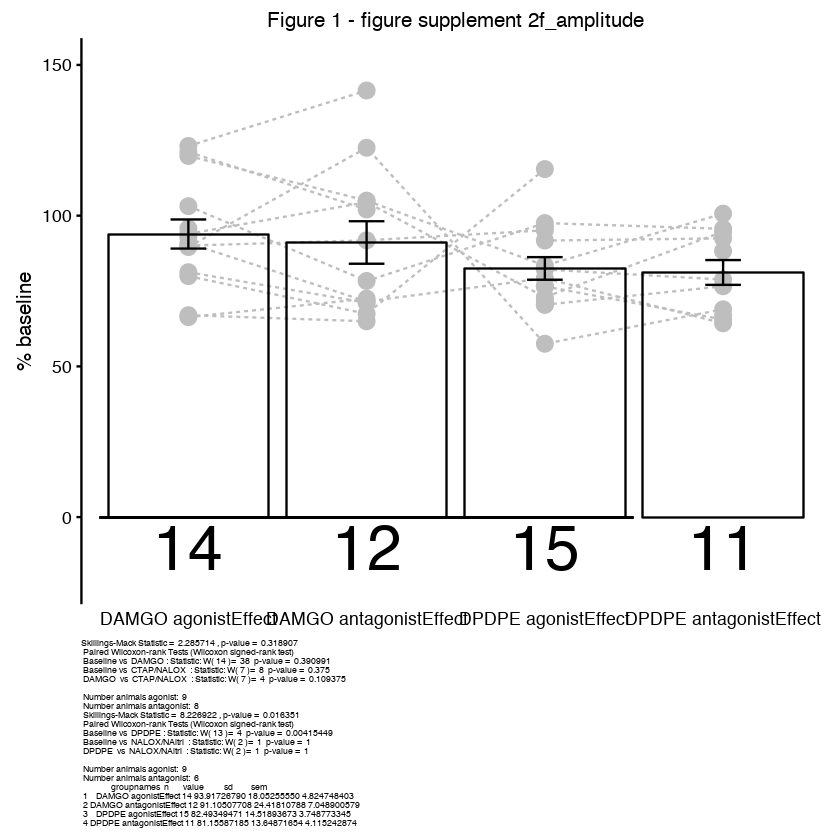

In [15]:
####################################################################################################
#     Figure 1 - figure supplement 2f
####################################################################################################
# Subset: opto stim PFC to DMS, recorded EPSC, from MSNs with DAMGO/DPDPE/antagonists
tempSDF = subset(df, genoType != "MORKOho" & genoType != "MORWTho" & stimSource == "PFC" & cellType == "MSN")
tempSDF = subset(tempSDF, signal == "EPSC" & agonistName == "DAMGO" | agonistName == "DPDPE")

#Important for good functioning of the script: No need to change:
cols = colnames(tempSDF)
tempSDF = melt(tempSDF, id.vars = cols[1:19],measure.vars = cols[20:21])

# give the tempSDF a specific name, needs to be changed for every new subset
sDf = subset(tempSDF, parameter == 'amplitude')
# Since there are two antagonists used for
tempSDF$antagonistName=gsub("DAMGONALOX", "DAMGOCTAP",tempSDF$antagonistName)
tempSDF$antagonistName=gsub("DPDPENALTRI", "DPDPENALOX",tempSDF$antagonistName)

xLabel = c("DAMGO", "CTAP/NALOX", "DPDPE","NALOX/NAltri")
antagonistSelect = c("DAMGOCTAP","DPDPENALOX")
graphTitle = c("Figure 1 - figure supplement 2f")

# prepare data into matrix for Skillings-Mack test.
ssDf = subset(sDf, variable == "agonistEffect" | variable == "antagonistEffect")
ssDf = subset(ssDf, is.finite(baseValue)& is.finite(agonistValue))
# # to avoid problems with sign reversal during agonist/antagonist treatment all conditions that show a different sign from baseValue are set to 0.0001
# # after that the SMmatrix can be transformed to absolute values
for (u in 1:nrow(ssDf)){
  if (ssDf$baseValue[u]<0){
    if (is.finite(ssDf$agonistValue[u])){
      if (ssDf$agonistValue[u]>0){
        ssDf$agonistValue[u]=-0.0001
      }
    }
    if (is.finite(ssDf$antagonistValue[u])){
      if (ssDf$antagonistValue[u]>0){
        ssDf$antagonistValue[u]=-0.0001
      }
    }
  }
  if (ssDf$baseValue[u]>0){
    if (is.finite(ssDf$agonistValue[u])){
      if (ssDf$agonistValue[u]<0){
        ssDf$agonistValue[u]=0.0001
      }
    }
    if (is.finite(ssDf$antagonistValue[u])){
      if (ssDf$antagonistValue[u]<0){
        ssDf$antagonistValue[u]=0.0001
      }
    }
  }
  if (is.finite(ssDf$antagonistName[u])){
    if (ssDf$antagonistName[u] !=antagonistSelect[1] & ssDf$antagonistName[u] !=antagonistSelect[2]){
      ssDf$antagonistValue[u] = NA
    }
  }
}
ssDf$baseValue = abs(ssDf$baseValue)
ssDf$agonistValue =abs(ssDf$agonistValue)
ssDf$antagonistValue = abs(ssDf$antagonistValue)

# In this graph we will be having two sets of repeated measures omnibus test. Thus run first DAMGO followed by DPDPE
# DAMGO
##########
SMlen = length(unique(ssDf$cellID[ssDf$agonistName == 'DAMGO']))
SMmatrix = c(ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen], ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen], ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen])
Gs = c(rep('baseline',SMlen),rep('agonist',SMlen),rep('antagonist',SMlen))
Bs = rep(1:SMlen,3)

SMresult = capture.output(Ski.Mack(SMmatrix,groups=Gs, blocks=Bs))
BAgWilcox = wilcox.test(ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen],ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen],paired = TRUE)
BAgWilcoxFlip = wilcox.test(ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen],ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen],paired = TRUE)
BAgWilcox$statistic = min(c(BAgWilcox$statistic, BAgWilcoxFlip$statistic))
diff = c(ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen] - ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen])
BAgWilcox$n = length(na.omit(diff[diff !=0]))

BAnWilcox = wilcox.test(ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen],ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen], paired = TRUE)
BAnWilcoxFlip = wilcox.test(ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen],ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen],paired = TRUE)
BAnWilcox$statistic = min(c(BAnWilcox$statistic, BAnWilcoxFlip$statistic))
diff = c(ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen] - ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen])
BAnWilcox$n = length(na.omit(diff[diff !=0]))

AgAnWilcox= wilcox.test(ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen], ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen], paired = TRUE)
AgAnWilcoxFlip = wilcox.test(ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen],ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen],paired = TRUE)
AgAnWilcox$statistic = min(c(AgAnWilcox$statistic, AgAnWilcoxFlip$statistic))
diff = c(ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen] - ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen])
AgAnWilcox$n = length(na.omit(diff[diff !=0]))

BAgAnno = pvalAnno(BAgWilcox$p.value,1)
BAnAnno = pvalAnno(BAnWilcox$p.value,1)
AgAnAnno =  pvalAnno(AgAnWilcox$p.value,1)
BNBQXAnno = pvalAnno(BNBQXWilcox$p.value,1)

reportString = paste(SMresult[2],'\n','Paired Wilcoxon-rank Tests (Wilcoxon signed-rank test) \n Baseline vs ',xLabel[1], ': Statistic: W(',BAgWilcox$n,')= ',BAgWilcox$statistic,' p-value = ',signif(BAgWilcox$p.value),'\n Baseline vs ', xLabel[2],' : Statistic: W(',BAnWilcox$n,')= ',BAnWilcox$statistic,' p-value = ',signif(BAnWilcox$p.value),'\n',xLabel[1],' vs ', xLabel[2],' : Statistic: W(',AgAnWilcox$n,')= ',AgAnWilcox$statistic,' p-value = ',signif(AgAnWilcox$p.value),'\n')
animalDf = subset(sDf, variable == 'agonistEffect' & agonistName == 'DAMGO' & is.finite(sDf$value))
agonistAnimal = length(unique(animalDf$animalID))
animalDf = subset(sDf, variable == 'antagonistEffect' & agonistName == 'DAMGO' & is.finite(sDf$value))
antagonistAnimal = length(unique(animalDf$animalID))
reportString1 = paste(reportString,'\n Number animals agonist: ',agonistAnimal,'\n Number animals antagonist: ', antagonistAnimal)

# DPDPE
##########
SMlen = length(unique(ssDf$cellID[ssDf$agonistName == 'DPDPE']))
SMmatrix = c(ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen], ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen], ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen])
Gs = c(rep('baseline',SMlen),rep('agonist',SMlen),rep('antagonist',SMlen))
Bs = rep(1:SMlen,3)

SMresult = capture.output(Ski.Mack(SMmatrix,groups=Gs, blocks=Bs))
BAgWilcox = wilcox.test(ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen],ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen],paired = TRUE)
BAgWilcoxFlip = wilcox.test(ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen],ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen],paired = TRUE)
BAgWilcox$statistic = min(c(BAgWilcox$statistic, BAgWilcoxFlip$statistic))
diff = c(ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen] - ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen])
BAgWilcox$n = length(na.omit(diff[diff !=0]))


BAnWilcox = wilcox.test(ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen],ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen], paired = TRUE)
BAnWilcoxFlip = wilcox.test(ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen],ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen],paired = TRUE)
BAnWilcox$statistic = min(c(BAnWilcox$statistic, BAnWilcoxFlip$statistic))
diff = c(ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen] - ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen])
BAnWilcox$n = length(na.omit(diff[diff !=0]))

AgAnWilcox= wilcox.test(ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen], ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen], paired = TRUE)
AgAnWilcoxFlip = wilcox.test(ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen],ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen],paired = TRUE)
AgAnWilcox$statistic = min(c(AgAnWilcox$statistic, AgAnWilcoxFlip$statistic))
diff = c(ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen] - ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen])
AgAnWilcox$n = length(na.omit(diff[diff !=0]))

BAgAnno = pvalAnno(BAgWilcox$p.value,1)
BAnAnno = pvalAnno(BAnWilcox$p.value,1)
AgAnAnno =  pvalAnno(AgAnWilcox$p.value,1)
BNBQXAnno = pvalAnno(BNBQXWilcox$p.value,1)
reportString = paste(SMresult[2],'\n','Paired Wilcoxon-rank Tests (Wilcoxon signed-rank test) \n Baseline vs ',xLabel[3], ': Statistic: W(',BAgWilcox$n,')= ',BAgWilcox$statistic,' p-value = ',signif(BAgWilcox$p.value),'\n Baseline vs ', xLabel[4],' : Statistic: W(',BAnWilcox$n,')= ',BAnWilcox$statistic,' p-value = ',signif(BAnWilcox$p.value),'\n',xLabel[3],' vs ', xLabel[4],' : Statistic: W(',AgAnWilcox$n,')= ',AgAnWilcox$statistic,' p-value = ',signif(AgAnWilcox$p.value),'\n')
animalDf = subset(sDf, variable == 'agonistEffect' & agonistName == 'DPDPE' & is.finite(sDf$value))
agonistAnimal = length(unique(animalDf$animalID))
animalDf = subset(sDf, variable == 'antagonistEffect' & agonistName == 'DPDPE' & is.finite(sDf$value))
antagonistAnimal = length(unique(animalDf$animalID))
reportString2 = paste(reportString,'\n Number animals agonist: ',agonistAnimal,'\n Number animals antagonist: ', antagonistAnimal)

sDf$groupnames = paste(sDf$agonistName, sDf$variable)
data_summary = data_meanSDSEM(sDf, varname = "value", groupnames = "groupnames")

sumOut = capture.output(data_summary)
sumRepOut = sumOut[1]
for(u in 2:length(sumOut)){
  sumRepOut = paste(sumRepOut,'\n', sumOut[u])
}

ggplot(data_summary, aes(x = groupnames , y = value))+
  geom_point(data = sDf, aes(x = groupnames , y = value), fill = "gray", colour = "gray",size = 4)+
  geom_line(data = sDf, aes(group = cellID ), lty = 2, colour = "gray")+
  geom_bar(stat = "identity", position = position_dodge(), colour = "black", fill = NA)+
  geom_errorbar(aes(ymin=value-sem, ymax=value+sem), width=.2, position=position_dodge(.9))+
  coord_cartesian(ylim = c(-20,150))+
  theme_cowplot(font_size = 12)+
  stat_summary(data =sDf, fun.data = give.n, geom = "text",fun.y = median, position = position_dodge(width = 0.75), size = (6.51/8)*16)+
  labs(ylab('% baseline'))+
  labs(xlab(NULL))+
  labs(title = paste(graphTitle,variableSelect[k],sep='_'))+
  labs(caption = paste(reportString1,"\n", reportString2,'\n',sumRepOut))+
  theme(plot.caption = element_text(size = 5, hjust = 0))+
  theme(plot.title = element_text(size = 12))+
  geom_segment(aes(x=1, y=175, xend = 2, yend = 175))+
  geom_segment(aes(x=0.5, y=0, xend = 3.5, yend = 0))+
  theme(axis.line.x = element_line(linetype='blank'), axis.ticks.x = element_blank())+
  theme(text=element_text(size=12))

## Figure 1 - figure supplement 2i

Warning message:
“Removed 6 rows containing non-finite values (stat_summary).”Warning message:
“Removed 6 rows containing missing values (geom_point).”Warning message:
“Removed 5 rows containing missing values (geom_path).”

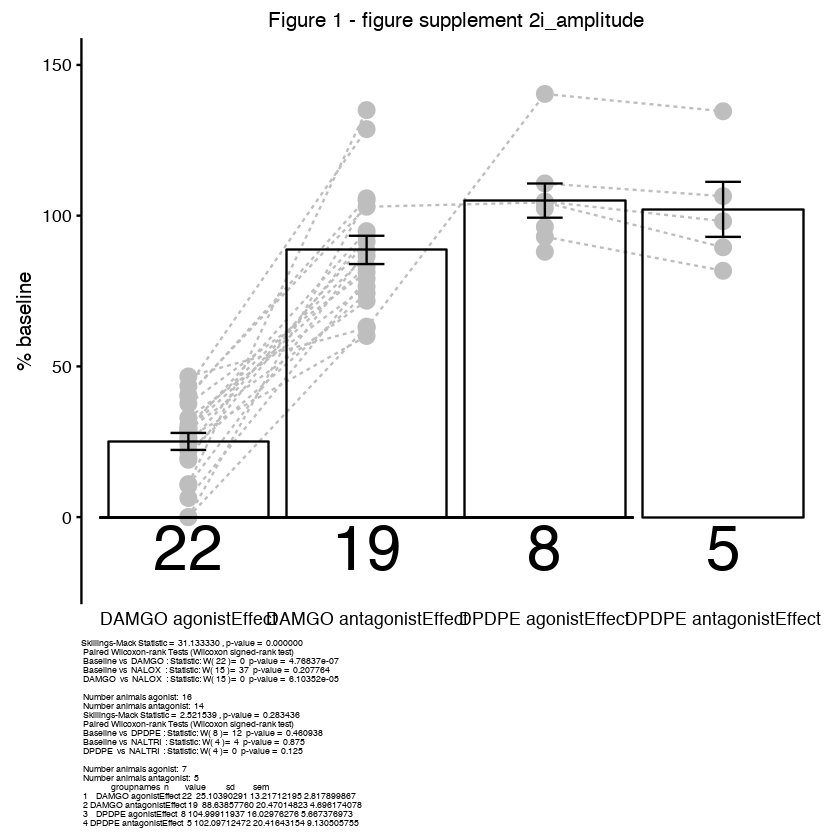

In [16]:
####################################################################################################
#     Figure 1 - figure supplement 2i
####################################################################################################
# Subset: opto stim in DMS from MD, recorded EPSC, from MSNs with Enk/Wash/NBQX
tempSDF = subset(df, genoType != "MORKOho" & genoType != "MORWTho" & genoType != "vGlut2cre" & genoType != "Vglut2 Homo/Het" & stimSource == "MD" & cellType == "MSN")
tempSDF = subset(tempSDF, signal == "EPSC" & agonistName == "DAMGO" | agonistName == "DPDPE")

#Important for good functioning of the script: No need to change:
cols = colnames(tempSDF)
tempSDF = melt(tempSDF, id.vars = cols[1:19],measure.vars = cols[20:21])

# give the tempSDF a specific name, needs to be changed for every new subset
sDf = subset(tempSDF, parameter == 'amplitude')
xLabel = c("DAMGO", "NALOX", "DPDPE","NALTRI")
antagonistSelect = c("DAMGONALOX","DPDPENALTRI")
graphTitle = c("Figure 1 - figure supplement 2i")

# prepare data into matrix for Skillings-Mack test.
ssDf = subset(sDf, variable == "agonistEffect" | variable == "antagonistEffect")
ssDf = subset(ssDf, is.finite(baseValue)& is.finite(agonistValue))
# # to avoid problems with sign reversal during agonist/antagonist treatment all conditions that show a different sign from baseValue are set to 0.0001
# # after that the SMmatrix can be transformed to absolute values
for (u in 1:nrow(ssDf)){
    if (ssDf$baseValue[u]<0){
        if (is.finite(ssDf$agonistValue[u])){
            if (ssDf$agonistValue[u]>0){
                ssDf$agonistValue[u]=-0.0001
            }
        }
        if (is.finite(ssDf$antagonistValue[u])){
            if (ssDf$antagonistValue[u]>0){
                ssDf$antagonistValue[u]=-0.0001
            }
        }
    }
    if (ssDf$baseValue[u]>0){
        if (is.finite(ssDf$agonistValue[u])){
            if (ssDf$agonistValue[u]<0){
                ssDf$agonistValue[u]=0.0001
            }
        }
        if (is.finite(ssDf$antagonistValue[u])){
            if (ssDf$antagonistValue[u]<0){
                ssDf$antagonistValue[u]=0.0001
            }
        }
    }
    if (is.finite(ssDf$antagonistName[u])){
        if (ssDf$antagonistName[u] !=antagonistSelect[1] & ssDf$antagonistName[u] !=antagonistSelect[2]){
            ssDf$antagonistValue[u] = NA
                                }
    }
}
ssDf$baseValue = abs(ssDf$baseValue)
ssDf$agonistValue =abs(ssDf$agonistValue)
ssDf$antagonistValue = abs(ssDf$antagonistValue)

# In this graph we will be having two sets of repeated measures omnibus test. Thus run first DAMGO followed by DPDPE
# DAMGO
##########
SMlen = length(unique(ssDf$cellID[ssDf$agonistName == 'DAMGO']))
SMmatrix = c(ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen], ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen], ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen])
Gs = c(rep('baseline',SMlen),rep('agonist',SMlen),rep('antagonist',SMlen))
Bs = rep(1:SMlen,3)

SMresult = capture.output(Ski.Mack(SMmatrix,groups=Gs, blocks=Bs))
BAgWilcox = wilcox.test(ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen],ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen],paired = TRUE)
BAgWilcoxFlip = wilcox.test(ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen],ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen],paired = TRUE)
BAgWilcox$statistic = min(c(BAgWilcox$statistic, BAgWilcoxFlip$statistic))
diff = c(ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen] - ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen])
BAgWilcox$n = length(na.omit(diff[diff !=0]))

BAnWilcox = wilcox.test(ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen],ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen], paired = TRUE)
BAnWilcoxFlip = wilcox.test(ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen],ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen],paired = TRUE)
BAnWilcox$statistic = min(c(BAnWilcox$statistic, BAnWilcoxFlip$statistic))
diff = c(ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen] - ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen])
BAnWilcox$n = length(na.omit(diff[diff !=0]))

AgAnWilcox= wilcox.test(ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen], ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen], paired = TRUE)
AgAnWilcoxFlip = wilcox.test(ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen],ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen],paired = TRUE)
AgAnWilcox$statistic = min(c(AgAnWilcox$statistic, AgAnWilcoxFlip$statistic))
diff = c(ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen] - ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen])
AgAnWilcox$n = length(na.omit(diff[diff !=0]))

BAgAnno = pvalAnno(BAgWilcox$p.value,1)
BAnAnno = pvalAnno(BAnWilcox$p.value,1)
AgAnAnno =  pvalAnno(AgAnWilcox$p.value,1)
BNBQXAnno = pvalAnno(BNBQXWilcox$p.value,1)
reportString = paste(SMresult[2],'\n','Paired Wilcoxon-rank Tests (Wilcoxon signed-rank test) \n Baseline vs ',xLabel[1], ': Statistic: W(',BAgWilcox$n,')= ',BAgWilcox$statistic,' p-value = ',signif(BAgWilcox$p.value),'\n Baseline vs ', xLabel[2],' : Statistic: W(',BAnWilcox$n,')= ',BAnWilcox$statistic,' p-value = ',signif(BAnWilcox$p.value),'\n',xLabel[1],' vs ', xLabel[2],' : Statistic: W(',AgAnWilcox$n,')= ',AgAnWilcox$statistic,' p-value = ',signif(AgAnWilcox$p.value),'\n')
animalDf = subset(sDf, variable == 'agonistEffect' & agonistName == 'DAMGO' & is.finite(sDf$value))
agonistAnimal = length(unique(animalDf$animalID))
animalDf = subset(sDf, variable == 'antagonistEffect' & agonistName == 'DAMGO' & is.finite(sDf$value))
antagonistAnimal = length(unique(animalDf$animalID))
reportString1 = paste(reportString,'\n Number animals agonist: ',agonistAnimal,'\n Number animals antagonist: ', antagonistAnimal)

# DPDPE
##########
SMlen = length(unique(ssDf$cellID[ssDf$agonistName == 'DPDPE']))
SMmatrix = c(ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen], ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen], ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen])
Gs = c(rep('baseline',SMlen),rep('agonist',SMlen),rep('antagonist',SMlen))
Bs = rep(1:SMlen,3)

SMresult = capture.output(Ski.Mack(SMmatrix,groups=Gs, blocks=Bs))
BAgWilcox = wilcox.test(ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen],ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen],paired = TRUE)
BAgWilcoxFlip = wilcox.test(ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen],ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen],paired = TRUE)
BAgWilcox$statistic = min(c(BAgWilcox$statistic, BAgWilcoxFlip$statistic))
diff = c(ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen] - ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen])
BAgWilcox$n = length(na.omit(diff[diff !=0]))

BAnWilcox = wilcox.test(ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen],ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen], paired = TRUE)
BAnWilcoxFlip = wilcox.test(ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen],ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen],paired = TRUE)
BAnWilcox$statistic = min(c(BAnWilcox$statistic, BAnWilcoxFlip$statistic))
diff = c(ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen] - ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen])
BAnWilcox$n = length(na.omit(diff[diff !=0]))

AgAnWilcox= wilcox.test(ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen], ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen], paired = TRUE)
AgAnWilcoxFlip = wilcox.test(ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen],ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen],paired = TRUE)
AgAnWilcox$statistic = min(c(AgAnWilcox$statistic, AgAnWilcoxFlip$statistic))
diff = c(ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen] - ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen])
AgAnWilcox$n = length(na.omit(diff[diff !=0]))

BAgAnno = pvalAnno(BAgWilcox$p.value,1)
BAnAnno = pvalAnno(BAnWilcox$p.value,1)
AgAnAnno =  pvalAnno(AgAnWilcox$p.value,1)
BNBQXAnno = pvalAnno(BNBQXWilcox$p.value,1)
reportString = paste(SMresult[2],'\n','Paired Wilcoxon-rank Tests (Wilcoxon signed-rank test) \n Baseline vs ',xLabel[3], ': Statistic: W(',BAgWilcox$n,')= ',BAgWilcox$statistic,' p-value = ',signif(BAgWilcox$p.value),'\n Baseline vs ', xLabel[4],' : Statistic: W(',BAnWilcox$n,')= ',BAnWilcox$statistic,' p-value = ',signif(BAnWilcox$p.value),'\n',xLabel[3],' vs ', xLabel[4],' : Statistic: W(',AgAnWilcox$n,')= ',AgAnWilcox$statistic,' p-value = ',signif(AgAnWilcox$p.value),'\n')
animalDf = subset(sDf, variable == 'agonistEffect' & agonistName == 'DPDPE' & is.finite(sDf$value))
agonistAnimal = length(unique(animalDf$animalID))
animalDf = subset(sDf, variable == 'antagonistEffect' & agonistName == 'DPDPE' & is.finite(sDf$value))
antagonistAnimal = length(unique(animalDf$animalID))
reportString2 = paste(reportString,'\n Number animals agonist: ',agonistAnimal,'\n Number animals antagonist: ', antagonistAnimal)
sDf$groupnames = paste(sDf$agonistName, sDf$variable)
data_summary = data_meanSDSEM(sDf, varname = "value", groupnames = "groupnames")

sumOut = capture.output(data_summary)
sumRepOut = sumOut[1]
for(u in 2:length(sumOut)){
  sumRepOut = paste(sumRepOut,'\n', sumOut[u])
}

ggplot(data_summary, aes(x = groupnames , y = value))+
    geom_point(data = sDf, aes(x = groupnames , y = value), fill = "gray", colour = "gray",size = 4)+
    geom_line(data = sDf, aes(group = cellID ), lty = 2, colour = "gray")+
    geom_bar(stat = "identity", position = position_dodge(), colour = "black", fill = NA)+
    geom_errorbar(aes(ymin=value-sem, ymax=value+sem), width=.2, position=position_dodge(.9))+
    coord_cartesian(ylim = c(-20,150))+
    theme_cowplot(font_size = 12)+
    stat_summary(data =sDf, fun.data = give.n, geom = "text",fun.y = median, position = position_dodge(width = 0.75), size = (6.51/8)*16)+
    labs(ylab('% baseline'))+
    labs(xlab(NULL))+
    labs(title = paste(graphTitle,variableSelect[k],sep='_'))+
    labs(caption = paste(reportString1,"\n", reportString2,'\n',sumRepOut))+
    theme(plot.caption = element_text(size = 5, hjust = 0))+
    theme(plot.title = element_text(size = 12))+
    geom_segment(aes(x=1, y=175, xend = 2, yend = 175))+
    geom_segment(aes(x=0.5, y=0, xend = 3.5, yend = 0))+
    theme(axis.line.x = element_line(linetype='blank'), axis.ticks.x = element_blank())+
    theme(text=element_text(size=12))

## Figure 1 - figure supplement 2l

Warning message in wilcox.test.default(ssDf$baseValue[ssDf$agonistName == "DPDPE"][1:SMlen], :
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(ssDf$agonistValue[ssDf$agonistName == "DPDPE"][1:SMlen], :
“cannot compute exact p-value with ties”Warning message:
“Removed 1 rows containing non-finite values (stat_summary).”Warning message:
“Removed 1 rows containing missing values (geom_point).”

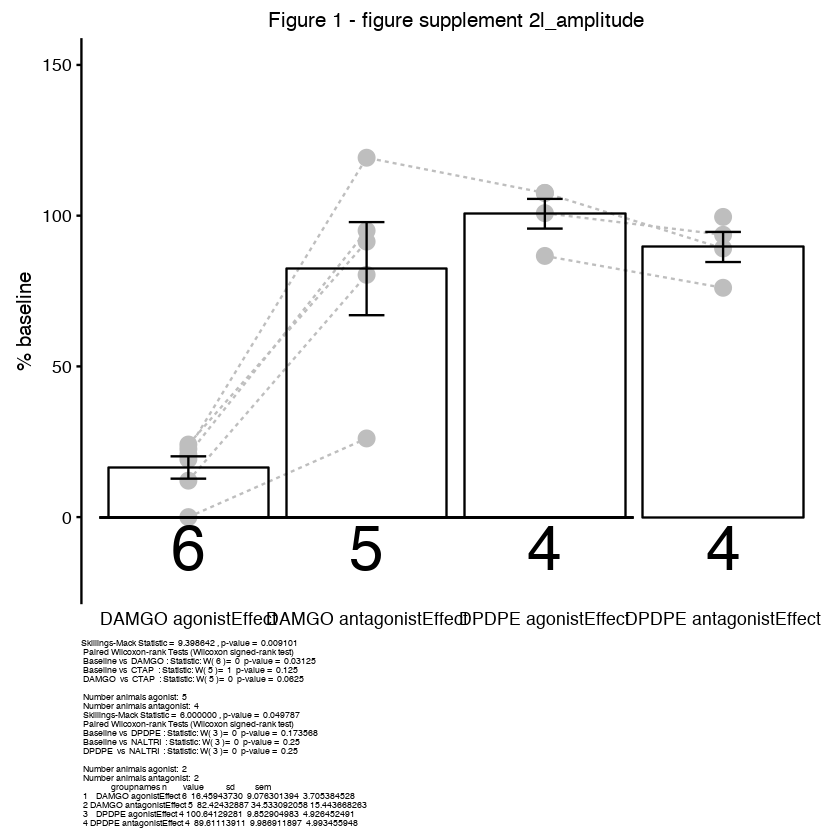

In [17]:
####################################################################################################
#     Figure 1 - figure supplement 2l
####################################################################################################
# Subset: opto stim in DMS from AMthal, recorded EPSC, from MSNs with Enk/Wash/NBQX
tempSDF = subset(df, genoType != "MORKOho" & genoType != "MORWTho" & genoType != "vGlut2cre" & stimSource == "AM" & cellType == "MSN")
tempSDF = subset(tempSDF, signal == "EPSC" & agonistName == "DAMGO" | agonistName == "DPDPE")
#since there is a mixed bag of antagonist, lets rename the CTAP to NALOX and ICE to NALTRI!
tempSDF$antagonistName = gsub("DAMGOCTAP","DAMGONALOX", tempSDF$antagonistName)
tempSDF$antagonistName = gsub("DAMGONLX","DAMGONALOX", tempSDF$antagonistName)
tempSDF$antagonistName = gsub("DPDPEICI","DPDPENALTRI", tempSDF$antagonistName)
tempSDF$antagonistName = gsub("DPDPENTD","DPDPENALTRI", tempSDF$antagonistName)
tempSDF$antagonistName = gsub("DPDPENLX","DPDPENALTRI", tempSDF$antagonistName)
tempSDF$antagonistName = as.factor(tempSDF$antagonistName)

#Important for good functioning of the script: No need to change:
cols = colnames(tempSDF)
tempSDF = melt(tempSDF, id.vars = cols[1:19],measure.vars = cols[20:21])

# give the tempSDF a specific name, needs to be changed for every new subset
sDf = subset(tempSDF, parameter == 'amplitude')
xLabel = c("DAMGO", "CTAP", "DPDPE","NALTRI")
antagonistSelect = c("DAMGONALOX","DPDPENALTRI")
graphTitle = c("Figure 1 - figure supplement 2l")

# prepare data into matrix for Skillings-Mack test.
ssDf = subset(sDf, variable == "agonistEffect" | variable == "antagonistEffect")
ssDf = subset(ssDf, is.finite(baseValue)& is.finite(agonistValue))
# # to avoid problems with sign reversal during agonist/antagonist treatment all conditions that show a different sign from baseValue are set to 0.0001
# # after that the SMmatrix can be transformed to absolute values
for (u in 1:nrow(ssDf)){
    if (ssDf$baseValue[u]<0){
        if (is.finite(ssDf$agonistValue[u])){
            if (ssDf$agonistValue[u]>0){
                ssDf$agonistValue[u]=-0.0001
            }
        }
        if (is.finite(ssDf$antagonistValue[u])){
            if (ssDf$antagonistValue[u]>0){
                ssDf$antagonistValue[u]=-0.0001
            }
        }
    }
    if (ssDf$baseValue[u]>0){
        if (is.finite(ssDf$agonistValue[u])){
            if (ssDf$agonistValue[u]<0){
                ssDf$agonistValue[u]=0.0001
            }
        }
        if (is.finite(ssDf$antagonistValue[u])){
            if (ssDf$antagonistValue[u]<0){
                ssDf$antagonistValue[u]=0.0001
            }
        }
    }
    if (is.finite(ssDf$antagonistName[u])){
        if (ssDf$antagonistName[u] !=antagonistSelect[1] & ssDf$antagonistName[u] !=antagonistSelect[2]){
            ssDf$antagonistValue[u] = NA
                                }
    }
}
ssDf$baseValue = abs(ssDf$baseValue)
ssDf$agonistValue =abs(ssDf$agonistValue)
ssDf$antagonistValue = abs(ssDf$antagonistValue)

# In this graph we will be having two sets of repeated measures omnibus test. Thus run first DAMGO followed by DPDPE

# DAMGO
##########
SMlen = length(unique(ssDf$cellID[ssDf$agonistName == 'DAMGO']))
SMmatrix = c(ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen], ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen], ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen])

Gs = c(rep('baseline',SMlen),rep('agonist',SMlen),rep('antagonist',SMlen))
Bs = rep(1:SMlen,3)

SMresult = capture.output(Ski.Mack(SMmatrix,groups=Gs, blocks=Bs))
BAgWilcox = wilcox.test(ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen],ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen],paired = TRUE)
BAgWilcoxFlip = wilcox.test(ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen],ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen],paired = TRUE)
BAgWilcox$statistic = min(c(BAgWilcox$statistic, BAgWilcoxFlip$statistic))
diff = c(ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen] - ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen])
BAgWilcox$n = length(na.omit(diff[diff !=0]))

BAnWilcox = wilcox.test(ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen],ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen], paired = TRUE)
BAnWilcoxFlip = wilcox.test(ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen],ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen],paired = TRUE)
BAnWilcox$statistic = min(c(BAnWilcox$statistic, BAnWilcoxFlip$statistic))
diff = c(ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen] - ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen])
BAnWilcox$n = length(na.omit(diff[diff !=0]))

AgAnWilcox= wilcox.test(ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen], ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen], paired = TRUE)
AgAnWilcoxFlip = wilcox.test(ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen],ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen],paired = TRUE)
AgAnWilcox$statistic = min(c(AgAnWilcox$statistic, AgAnWilcoxFlip$statistic))
diff = c(ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen] - ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen])
AgAnWilcox$n = length(na.omit(diff[diff !=0]))

BAgAnno = pvalAnno(BAgWilcox$p.value,1)
BAnAnno = pvalAnno(BAnWilcox$p.value,1)
AgAnAnno =  pvalAnno(AgAnWilcox$p.value,1)
BNBQXAnno = pvalAnno(BNBQXWilcox$p.value,1)
reportString = paste(SMresult[2],'\n','Paired Wilcoxon-rank Tests (Wilcoxon signed-rank test) \n Baseline vs ',xLabel[1], ': Statistic: W(',BAgWilcox$n,')= ',BAgWilcox$statistic,' p-value = ',signif(BAgWilcox$p.value),'\n Baseline vs ', xLabel[2],' : Statistic: W(',BAnWilcox$n,')= ',BAnWilcox$statistic,' p-value = ',signif(BAnWilcox$p.value),'\n',xLabel[1],' vs ', xLabel[2],' : Statistic: W(',AgAnWilcox$n,')= ',AgAnWilcox$statistic,' p-value = ',signif(AgAnWilcox$p.value),'\n')
animalDf = subset(sDf, variable == 'agonistEffect' & agonistName == 'DAMGO' & is.finite(sDf$value))
agonistAnimal = length(unique(animalDf$animalID))
animalDf = subset(sDf, variable == 'antagonistEffect' & agonistName == 'DAMGO' & is.finite(sDf$value))
antagonistAnimal = length(unique(animalDf$animalID))
reportString1 = paste(reportString,'\n Number animals agonist: ',agonistAnimal,'\n Number animals antagonist: ', antagonistAnimal)

# DPDPE
##########
SMlen = length(unique(ssDf$cellID[ssDf$agonistName == 'DPDPE']))
SMmatrix = c(ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen], ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen], ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen])

Gs = c(rep('baseline',SMlen),rep('agonist',SMlen),rep('antagonist',SMlen))
Bs = rep(1:SMlen,3)

SMresult = capture.output(Ski.Mack(SMmatrix,groups=Gs, blocks=Bs))
BAgWilcox = wilcox.test(ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen],ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen],paired = TRUE)
BAgWilcoxFlip = wilcox.test(ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen],ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen],paired = TRUE)
BAgWilcox$statistic = min(c(BAgWilcox$statistic, BAgWilcoxFlip$statistic))
diff = c(ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen] - ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen])
BAgWilcox$n = length(na.omit(diff[diff !=0]))

BAnWilcox = wilcox.test(ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen],ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen], paired = TRUE)
BAnWilcoxFlip = wilcox.test(ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen],ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen],paired = TRUE)
BAnWilcox$statistic = min(c(BAnWilcox$statistic, BAnWilcoxFlip$statistic))
diff = c(ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen] - ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen])
BAnWilcox$n = length(na.omit(diff[diff !=0]))

AgAnWilcox= wilcox.test(ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen], ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen], paired = TRUE)
AgAnWilcoxFlip = wilcox.test(ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen],ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen],paired = TRUE)
AgAnWilcox$statistic = min(c(AgAnWilcox$statistic, AgAnWilcoxFlip$statistic))
diff = c(ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen] - ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen])
AgAnWilcox$n = length(na.omit(diff[diff !=0]))

BAgAnno = pvalAnno(BAgWilcox$p.value,1)
BAnAnno = pvalAnno(BAnWilcox$p.value,1)
AgAnAnno =  pvalAnno(AgAnWilcox$p.value,1)
BNBQXAnno = pvalAnno(BNBQXWilcox$p.value,1)

reportString = paste(SMresult[2],'\n','Paired Wilcoxon-rank Tests (Wilcoxon signed-rank test) \n Baseline vs ',xLabel[3], ': Statistic: W(',BAgWilcox$n,')= ',BAgWilcox$statistic,' p-value = ',signif(BAgWilcox$p.value),'\n Baseline vs ', xLabel[4],' : Statistic: W(',BAnWilcox$n,')= ',BAnWilcox$statistic,' p-value = ',signif(BAnWilcox$p.value),'\n',xLabel[3],' vs ', xLabel[4],' : Statistic: W(',AgAnWilcox$n,')= ',AgAnWilcox$statistic,' p-value = ',signif(AgAnWilcox$p.value),'\n')
animalDf = subset(sDf, variable == 'agonistEffect' & agonistName == 'DPDPE' & is.finite(sDf$value))
agonistAnimal = length(unique(animalDf$animalID))
animalDf = subset(sDf, variable == 'antagonistEffect' & agonistName == 'DPDPE' & is.finite(sDf$value))
antagonistAnimal = length(unique(animalDf$animalID))
reportString2 = paste(reportString,'\n Number animals agonist: ',agonistAnimal,'\n Number animals antagonist: ', antagonistAnimal)

sDf$groupnames = paste(sDf$agonistName, sDf$variable)
data_summary = data_meanSDSEM(sDf, varname = "value", groupnames = "groupnames")

sumOut = capture.output(data_summary)
sumRepOut = sumOut[1]
for(u in 2:length(sumOut)){
  sumRepOut = paste(sumRepOut,'\n', sumOut[u])
}

ggplot(data_summary, aes(x = groupnames , y = value))+
    geom_point(data = sDf, aes(x = groupnames , y = value), fill = "gray", colour = "gray",size = 4)+
    geom_line(data = sDf, aes(group = cellID ), lty = 2, colour = "gray")+
    geom_bar(stat = "identity", position = position_dodge(), colour = "black", fill = NA)+
    geom_errorbar(aes(ymin=value-sem, ymax=value+sem), width=.2, position=position_dodge(.9))+
    coord_cartesian(ylim = c(-20,150))+
    theme_cowplot(font_size = 12)+
    stat_summary(data =sDf, fun.data = give.n, geom = "text",fun.y = median, position = position_dodge(width = 0.75), size = (6.51/8)*16)+
    labs(ylab('% baseline'))+
    labs(xlab(NULL))+
    labs(title = paste(graphTitle,variableSelect[k],sep='_'))+
    labs(caption = paste(reportString1,"\n", reportString2,'\n',sumRepOut))+
    theme(plot.caption = element_text(size = 5, hjust = 0))+
    theme(plot.title = element_text(size = 12))+
    geom_segment(aes(x=1, y=175, xend = 2, yend = 175))+
    geom_segment(aes(x=0.5, y=0, xend = 3.5, yend = 0))+
    theme(axis.line.x = element_line(linetype='blank'), axis.ticks.x = element_blank())+
    theme(text=element_text(size=12))

# Figure 2c

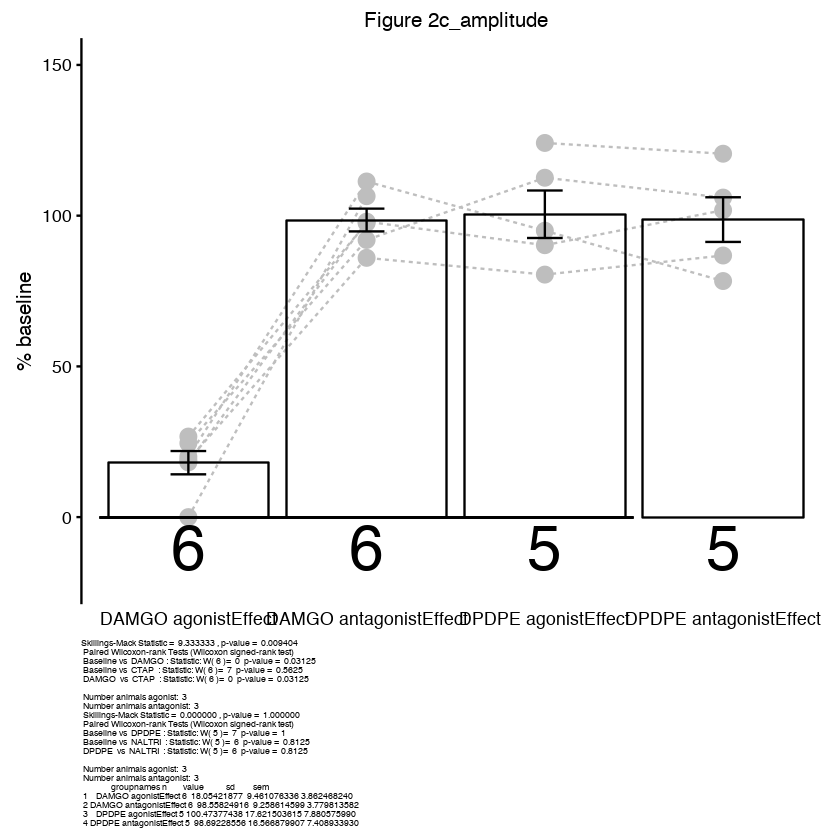

In [18]:
####################################################################################################
#     Figure 2c
####################################################################################################
# Subset: opto stim in DMS from vGLUT2cre positive cells MD, recorded EPSC, from MSNs with Enk/Wash/NBQX
tempSDF = subset(df, genoType != "MORKOho" & genoType != "MORWTho" & genoType == "vGlut2cre" & stimSource == "MD" & cellType == "MSN")
tempSDF = subset(tempSDF, signal == "EPSC" & agonistName == "DAMGO" | agonistName == "DPDPE")

#Important for good functioning of the script: No need to change:
cols = colnames(tempSDF)
tempSDF = melt(tempSDF, id.vars = cols[1:19],measure.vars = cols[20:21])

# give the tempSDF a specific name, needs to be changed for every new subset
sDf = subset(tempSDF, parameter == 'amplitude')
xLabel = c("DAMGO", "CTAP", "DPDPE","NALTRI")
antagonistSelect = c("DAMGOCTAP","DPDPENALTRI")
graphTitle = c("Figure 2c")

# prepare data into matrix for Skillings-Mack test.
ssDf = subset(sDf, variable == "agonistEffect" | variable == "antagonistEffect")
ssDf = subset(ssDf, is.finite(baseValue)& is.finite(agonistValue))
# # to avoid problems with sign reversal during agonist/antagonist treatment all conditions that show a different sign from baseValue are set to 0.0001
# # after that the SMmatrix can be transformed to absolute values
for (u in 1:nrow(ssDf)){
    if (ssDf$baseValue[u]<0){
        if (is.finite(ssDf$agonistValue[u])){
            if (ssDf$agonistValue[u]>0){
                ssDf$agonistValue[u]=-0.0001
            }
        }
        if (is.finite(ssDf$antagonistValue[u])){
            if (ssDf$antagonistValue[u]>0){
                ssDf$antagonistValue[u]=-0.0001
            }
        }
    }
    if (ssDf$baseValue[u]>0){
        if (is.finite(ssDf$agonistValue[u])){
            if (ssDf$agonistValue[u]<0){
                ssDf$agonistValue[u]=0.0001
            }
        }
        if (is.finite(ssDf$antagonistValue[u])){
            if (ssDf$antagonistValue[u]<0){
                ssDf$antagonistValue[u]=0.0001
            }
        }
    }
    if (is.finite(ssDf$antagonistName[u])){
        if (ssDf$antagonistName[u] !=antagonistSelect[1] & ssDf$antagonistName[u] !=antagonistSelect[2]){
            ssDf$antagonistValue[u] = NA
                                }
    }
}
ssDf$baseValue = abs(ssDf$baseValue)
ssDf$agonistValue =abs(ssDf$agonistValue)
ssDf$antagonistValue = abs(ssDf$antagonistValue)

# In this graph we will be having two sets of repeated measures omnibus test. Thus run first DAMGO followed by DPDPE
# DAMGO
##########
SMlen = length(unique(ssDf$cellID[ssDf$agonistName == 'DAMGO']))
SMmatrix = c(ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen], ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen], ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen])
Gs = c(rep('baseline',SMlen),rep('agonist',SMlen),rep('antagonist',SMlen))
Bs = rep(1:SMlen,3)

SMresult = capture.output(Ski.Mack(SMmatrix,groups=Gs, blocks=Bs))
BAgWilcox = wilcox.test(ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen],ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen],paired = TRUE)
BAgWilcoxFlip = wilcox.test(ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen],ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen],paired = TRUE)
BAgWilcox$statistic = min(c(BAgWilcox$statistic, BAgWilcoxFlip$statistic))
diff = c(ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen] - ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen])
BAgWilcox$n = length(na.omit(diff[diff !=0]))

BAnWilcox = wilcox.test(ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen],ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen], paired = TRUE)
BAnWilcoxFlip = wilcox.test(ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen],ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen],paired = TRUE)
BAnWilcox$statistic = min(c(BAnWilcox$statistic, BAnWilcoxFlip$statistic))
diff = c(ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen] - ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen])
BAnWilcox$n = length(na.omit(diff[diff !=0]))

AgAnWilcox= wilcox.test(ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen], ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen], paired = TRUE)
AgAnWilcoxFlip = wilcox.test(ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen],ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen],paired = TRUE)
AgAnWilcox$statistic = min(c(AgAnWilcox$statistic, AgAnWilcoxFlip$statistic))
diff = c(ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen] - ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen])
AgAnWilcox$n = length(na.omit(diff[diff !=0]))

BAgAnno = pvalAnno(BAgWilcox$p.value,1)
BAnAnno = pvalAnno(BAnWilcox$p.value,1)
AgAnAnno =  pvalAnno(AgAnWilcox$p.value,1)
BNBQXAnno = pvalAnno(BNBQXWilcox$p.value,1)
reportString = paste(SMresult[2],'\n','Paired Wilcoxon-rank Tests (Wilcoxon signed-rank test) \n Baseline vs ',xLabel[1], ': Statistic: W(',BAgWilcox$n,')= ',BAgWilcox$statistic,' p-value = ',signif(BAgWilcox$p.value),'\n Baseline vs ', xLabel[2],' : Statistic: W(',BAnWilcox$n,')= ',BAnWilcox$statistic,' p-value = ',signif(BAnWilcox$p.value),'\n',xLabel[1],' vs ', xLabel[2],' : Statistic: W(',AgAnWilcox$n,')= ',AgAnWilcox$statistic,' p-value = ',signif(AgAnWilcox$p.value),'\n')
animalDf = subset(sDf, variable == 'agonistEffect' & agonistName == 'DAMGO' & is.finite(sDf$value))
agonistAnimal = length(unique(animalDf$animalID))
animalDf = subset(sDf, variable == 'antagonistEffect' & agonistName == 'DAMGO' & is.finite(sDf$value))
antagonistAnimal = length(unique(animalDf$animalID))
reportString1 = paste(reportString,'\n Number animals agonist: ',agonistAnimal,'\n Number animals antagonist: ', antagonistAnimal)

# DPDPE
##########
SMlen = length(unique(ssDf$cellID[ssDf$agonistName == 'DPDPE']))
SMmatrix = c(ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen], ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen], ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen])
Gs = c(rep('baseline',SMlen),rep('agonist',SMlen),rep('antagonist',SMlen))
Bs = rep(1:SMlen,3)

SMresult = capture.output(Ski.Mack(SMmatrix,groups=Gs, blocks=Bs))
BAgWilcox = wilcox.test(ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen],ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen],paired = TRUE)
BAgWilcoxFlip = wilcox.test(ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen],ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen],paired = TRUE)
BAgWilcox$statistic = min(c(BAgWilcox$statistic, BAgWilcoxFlip$statistic))
diff = c(ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen] - ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen])
BAgWilcox$n = length(na.omit(diff[diff !=0]))

BAnWilcox = wilcox.test(ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen],ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen], paired = TRUE)
BAnWilcoxFlip = wilcox.test(ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen],ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen],paired = TRUE)
BAnWilcox$statistic = min(c(BAnWilcox$statistic, BAnWilcoxFlip$statistic))
diff = c(ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen] - ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen])
BAnWilcox$n = length(na.omit(diff[diff !=0]))

AgAnWilcox= wilcox.test(ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen], ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen], paired = TRUE)
AgAnWilcoxFlip = wilcox.test(ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen],ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen],paired = TRUE)
AgAnWilcox$statistic = min(c(AgAnWilcox$statistic, AgAnWilcoxFlip$statistic))
diff = c(ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen] - ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen])
AgAnWilcox$n = length(na.omit(diff[diff !=0]))

BAgAnno = pvalAnno(BAgWilcox$p.value,1)
BAnAnno = pvalAnno(BAnWilcox$p.value,1)
AgAnAnno =  pvalAnno(AgAnWilcox$p.value,1)
BNBQXAnno = pvalAnno(BNBQXWilcox$p.value,1)
reportString = paste(SMresult[2],'\n','Paired Wilcoxon-rank Tests (Wilcoxon signed-rank test) \n Baseline vs ',xLabel[3], ': Statistic: W(',BAgWilcox$n,')= ',BAgWilcox$statistic,' p-value = ',signif(BAgWilcox$p.value),'\n Baseline vs ', xLabel[4],' : Statistic: W(',BAnWilcox$n,')= ',BAnWilcox$statistic,' p-value = ',signif(BAnWilcox$p.value),'\n',xLabel[3],' vs ', xLabel[4],' : Statistic: W(',AgAnWilcox$n,')= ',AgAnWilcox$statistic,' p-value = ',signif(AgAnWilcox$p.value),'\n')
animalDf = subset(sDf, variable == 'agonistEffect' & agonistName == 'DPDPE' & is.finite(sDf$value))
agonistAnimal = length(unique(animalDf$animalID))
animalDf = subset(sDf, variable == 'antagonistEffect' & agonistName == 'DPDPE' & is.finite(sDf$value))
antagonistAnimal = length(unique(animalDf$animalID))
reportString2 = paste(reportString,'\n Number animals agonist: ',agonistAnimal,'\n Number animals antagonist: ', antagonistAnimal)

sDf$groupnames = paste(sDf$agonistName, sDf$variable)
data_summary = data_meanSDSEM(sDf, varname = "value", groupnames = "groupnames")

sumOut = capture.output(data_summary)
sumRepOut = sumOut[1]
for(u in 2:length(sumOut)){
  sumRepOut = paste(sumRepOut,'\n', sumOut[u])
}

ggplot(data_summary, aes(x = groupnames , y = value))+
    geom_point(data = sDf, aes(x = groupnames , y = value), fill = "gray", colour = "gray",size = 4)+
    geom_line(data = sDf, aes(group = cellID ), lty = 2, colour = "gray")+
    geom_bar(stat = "identity", position = position_dodge(), colour = "black", fill = NA)+
    geom_errorbar(aes(ymin=value-sem, ymax=value+sem), width=.2, position=position_dodge(.9))+
    coord_cartesian(ylim = c(-20,150))+
    theme_cowplot(font_size = 12)+
    stat_summary(data =sDf, fun.data = give.n, geom = "text",fun.y = median, position = position_dodge(width = 0.75), size = (6.51/8)*16)+
    labs(ylab('% baseline'))+
    labs(xlab(NULL))+
    labs(title = paste(graphTitle,variableSelect[k],sep='_'))+
    labs(caption = paste(reportString1,"\n", reportString2,'\n',sumRepOut))+
    theme(plot.caption = element_text(size = 5, hjust = 0))+
    theme(plot.title = element_text(size = 12))+
    geom_segment(aes(x=1, y=175, xend = 2, yend = 175))+
    geom_segment(aes(x=0.5, y=0, xend = 3.5, yend = 0))+
    theme(axis.line.x = element_line(linetype='blank'), axis.ticks.x = element_blank())+
    theme(text=element_text(size=12))

# Figure 4
## Figure 4c

Warning message in wilcox.test.default(ssDf$baseValue[ssDf$agonistName == "DPDPE"][1:SMlen], :
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(ssDf$agonistValue[ssDf$agonistName == "DPDPE"][1:SMlen], :
“cannot compute exact p-value with ties”Warning message:
“Removed 13 rows containing non-finite values (stat_summary).”Warning message:
“Removed 13 rows containing missing values (geom_point).”Warning message:
“Removed 13 rows containing missing values (geom_path).”

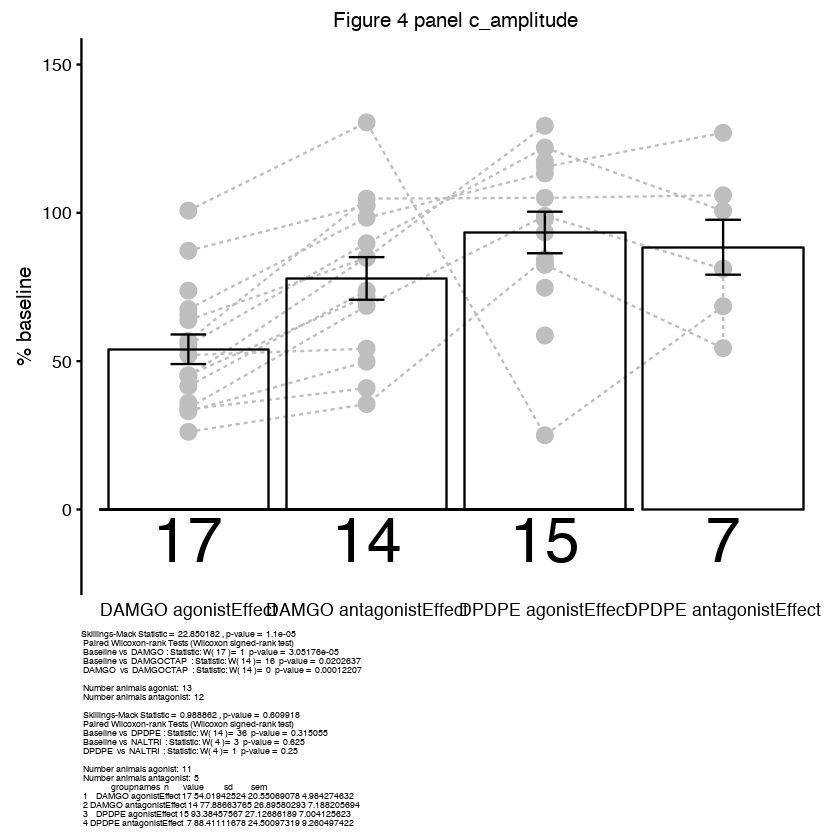

In [19]:
####################################################################################################
#     Figure 4 panel c
####################################################################################################
# Subset: photostim in ACC, recorded EPSC, from L5 PYR with DAMGO and DPDPE
tempSDF = subset(df, genoType != "MORKOho" & genoType != "MORWTho" & genoType != "vGlut2cre" & stimSource == "MD" & circuit == "MD_L5_PYR")
tempSDF = subset(tempSDF, signal == "EPSC" & agonistName == "DAMGO" |signal == "EPSC" & agonistName == "DPDPE")

tempSDF$antagonistName = as.factor(tempSDF$antagonistName)

#Important for good functioning of the script: No need to change:
cols = colnames(tempSDF)
tempSDF = melt(tempSDF, id.vars = cols[1:19],measure.vars = cols[20:21])

# give the tempSDF a specific name, needs to be changed for every new subset
sDf = subset(tempSDF, parameter == 'amplitude')
xLabel = c("DAMGO", "DAMGOCTAP", "DPDPE","NALTRI")
antagonistSelect = c("DAMGOCTAP","DPDPENALTRI")
graphTitle = c("Figure 4 panel c")

# prepare data into matrix for Skillings-Mack test.
ssDf = subset(sDf, variable == "agonistEffect" | variable == "antagonistEffect")
ssDf = subset(ssDf, is.finite(baseValue)& is.finite(agonistValue))
# # to avoid problems with sign reversal during agonist/antagonist treatment all conditions that show a different sign from baseValue are set to 0.0001
# # after that the SMmatrix can be transformed to absolute values
for (u in 1:nrow(ssDf)){
  if (ssDf$baseValue[u]<0){
    if (is.finite(ssDf$agonistValue[u])){
      if (ssDf$agonistValue[u]>0){
        ssDf$agonistValue[u]=-0.0001
      }
    }
    if (is.finite(ssDf$antagonistValue[u])){
      if (ssDf$antagonistValue[u]>0){
        ssDf$antagonistValue[u]=-0.0001
      }
    }
  }
  if (ssDf$baseValue[u]>0){
    if (is.finite(ssDf$agonistValue[u])){
      if (ssDf$agonistValue[u]<0){
        ssDf$agonistValue[u]=0.0001
      }
    }
    if (is.finite(ssDf$antagonistValue[u])){
      if (ssDf$antagonistValue[u]<0){
        ssDf$antagonistValue[u]=0.0001
      }
    }
  }
  if (is.finite(ssDf$antagonistName[u])){
    if (ssDf$antagonistName[u] !=antagonistSelect[1] & ssDf$antagonistName[u] !=antagonistSelect[2]){
      ssDf$antagonistValue[u] = NA
    }
  }
}
ssDf$baseValue = abs(ssDf$baseValue)
ssDf$agonistValue =abs(ssDf$agonistValue)
ssDf$antagonistValue = abs(ssDf$antagonistValue)

# In this graph we will be having two sets of repeated measures omnibus test. Thus run first DAMGO followed by DPDPE

# DAMGO
##########
SMlen = length(unique(ssDf$cellID[ssDf$agonistName == 'DAMGO']))
SMmatrix = c(ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen], ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen], ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen])
Gs = c(rep('baseline',SMlen),rep('agonist',SMlen),rep('antagonist',SMlen))
Bs = rep(1:SMlen,3)

SMresult = capture.output(Ski.Mack(SMmatrix,groups=Gs, blocks=Bs))
BAgWilcox = wilcox.test(ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen],ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen],paired = TRUE)
BAgWilcoxFlip = wilcox.test(ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen],ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen],paired = TRUE)
BAgWilcox$statistic = min(c(BAgWilcox$statistic, BAgWilcoxFlip$statistic))
diff = c(ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen] - ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen])
BAgWilcox$n = length(na.omit(diff[diff !=0]))

BAnWilcox = wilcox.test(ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen],ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen], paired = TRUE)
BAnWilcoxFlip = wilcox.test(ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen],ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen],paired = TRUE)
BAnWilcox$statistic = min(c(BAnWilcox$statistic, BAnWilcoxFlip$statistic))
diff = c(ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen] - ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen])
BAnWilcox$n = length(na.omit(diff[diff !=0]))

AgAnWilcox= wilcox.test(ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen], ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen], paired = TRUE)
AgAnWilcoxFlip = wilcox.test(ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen],ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen],paired = TRUE)
AgAnWilcox$statistic = min(c(AgAnWilcox$statistic, AgAnWilcoxFlip$statistic))
diff = c(ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen] - ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen])
AgAnWilcox$n = length(na.omit(diff[diff !=0]))

BAgAnno = pvalAnno(BAgWilcox$p.value,1)
BAnAnno = pvalAnno(BAnWilcox$p.value,1)
AgAnAnno =  pvalAnno(AgAnWilcox$p.value,1)

reportString = paste(SMresult[2],'\n','Paired Wilcoxon-rank Tests (Wilcoxon signed-rank test) \n Baseline vs ',xLabel[1], ': Statistic: W(',BAgWilcox$n,')= ',BAgWilcox$statistic,' p-value = ',signif(BAgWilcox$p.value),'\n Baseline vs ', xLabel[2],' : Statistic: W(',BAnWilcox$n,')= ',BAnWilcox$statistic,' p-value = ',signif(BAnWilcox$p.value),'\n',xLabel[1],' vs ', xLabel[2],' : Statistic: W(',AgAnWilcox$n,')= ',AgAnWilcox$statistic,' p-value = ',signif(AgAnWilcox$p.value),'\n')
animalDf = subset(sDf, variable == 'agonistEffect' & agonistName == 'DAMGO' & is.finite(sDf$value))
agonistAnimal = length(unique(animalDf$animalID))
animalDf = subset(sDf, variable == 'antagonistEffect' & agonistName == 'DAMGO' & is.finite(sDf$value))
antagonistAnimal = length(unique(animalDf$animalID))
reportString1 = paste(reportString,'\n Number animals agonist: ',agonistAnimal,'\n Number animals antagonist: ', antagonistAnimal)

# DPDPE
##########
SMlen = length(unique(ssDf$cellID[ssDf$agonistName == 'DPDPE']))
SMmatrix = c(ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen], ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen], ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen])
Gs = c(rep('baseline',SMlen),rep('agonist',SMlen),rep('antagonist',SMlen))
Bs = rep(1:SMlen,3)

SMresult = capture.output(Ski.Mack(SMmatrix,groups=Gs, blocks=Bs))
BAgWilcox = wilcox.test(ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen],ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen],paired = TRUE)
BAgWilcoxFlip = wilcox.test(ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen],ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen],paired = TRUE)
BAgWilcox$statistic = min(c(BAgWilcox$statistic, BAgWilcoxFlip$statistic))
diff = c(ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen] - ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen])
BAgWilcox$n = length(na.omit(diff[diff !=0]))

BAnWilcox = wilcox.test(ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen],ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen], paired = TRUE)
BAnWilcoxFlip = wilcox.test(ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen],ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen],paired = TRUE)
BAnWilcox$statistic = min(c(BAnWilcox$statistic, BAnWilcoxFlip$statistic))
diff = c(ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen] - ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen])
BAnWilcox$n = length(na.omit(diff[diff !=0]))

AgAnWilcox= wilcox.test(ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen], ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen], paired = TRUE)
AgAnWilcoxFlip = wilcox.test(ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen],ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen],paired = TRUE)
AgAnWilcox$statistic = min(c(AgAnWilcox$statistic, AgAnWilcoxFlip$statistic))
diff = c(ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen] - ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen])
AgAnWilcox$n = length(na.omit(diff[diff !=0]))

BAgAnno = pvalAnno(BAgWilcox$p.value,1)
BAnAnno = pvalAnno(BAnWilcox$p.value,1)
AgAnAnno =  pvalAnno(AgAnWilcox$p.value,1)
reportString = paste(SMresult[2],'\n','Paired Wilcoxon-rank Tests (Wilcoxon signed-rank test) \n Baseline vs ',xLabel[3], ': Statistic: W(',BAgWilcox$n,')= ',BAgWilcox$statistic,' p-value = ',signif(BAgWilcox$p.value),'\n Baseline vs ', xLabel[4],' : Statistic: W(',BAnWilcox$n,')= ',BAnWilcox$statistic,' p-value = ',signif(BAnWilcox$p.value),'\n',xLabel[3],' vs ', xLabel[4],' : Statistic: W(',AgAnWilcox$n,')= ',AgAnWilcox$statistic,' p-value = ',signif(AgAnWilcox$p.value),'\n')
animalDf = subset(sDf, variable == 'agonistEffect' & agonistName == 'DPDPE' & is.finite(sDf$value))
agonistAnimal = length(unique(animalDf$animalID))
animalDf = subset(sDf, variable == 'antagonistEffect' & agonistName == 'DPDPE' & is.finite(sDf$value))
antagonistAnimal = length(unique(animalDf$animalID))
reportString2 = paste(reportString,'\n Number animals agonist: ',agonistAnimal,'\n Number animals antagonist: ', antagonistAnimal)

sDf$groupnames = paste(sDf$agonistName, sDf$variable)
data_summary = data_meanSDSEM(sDf, varname = "value", groupnames = "groupnames")

sumOut = capture.output(data_summary)
sumRepOut = sumOut[1]
for(u in 2:length(sumOut)){
  sumRepOut = paste(sumRepOut,'\n', sumOut[u])
}

ggplot(data_summary, aes(x = groupnames , y = value))+
  geom_point(data = sDf, aes(x = groupnames , y = value), fill = "gray", colour = "gray",size = 4)+
  geom_line(data = sDf, aes(group = cellID ), lty = 2, colour = "gray")+
  geom_bar(stat = "identity", position = position_dodge(), colour = "black", fill = NA)+
  geom_errorbar(aes(ymin=value-sem, ymax=value+sem), width=.2, position=position_dodge(.9))+
  coord_cartesian(ylim = c(-20,150))+
  theme_cowplot(font_size = 12)+
  stat_summary(data =sDf, fun.data = give.n, geom = "text",fun.y = median, position = position_dodge(width = 0.75), size = (6.51/8)*16)+
  labs(ylab('% baseline'))+
  labs(xlab(NULL))+
  labs(title = paste(graphTitle,"amplitude",sep='_'))+
  labs(caption = paste(reportString1,"\n\n", reportString2,'\n',sumRepOut))+
  theme(plot.caption = element_text(size = 5, hjust = 0))+
  theme(plot.title = element_text(size = 12))+
  geom_segment(aes(x=1, y=175, xend = 2, yend = 175))+
  geom_segment(aes(x=0.5, y=0, xend = 3.5, yend = 0))+
  theme(axis.line.x = element_line(linetype='blank'), axis.ticks.x = element_blank())+
  theme(text=element_text(size=12))

## Figure 4f

Warning message in wilcox.test.default(ssDf$baseValue[ssDf$agonistName == "DPDPE"][1:SMlen], :
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(ssDf$agonistValue[ssDf$agonistName == "DPDPE"][1:SMlen], :
“cannot compute exact p-value with ties”Warning message:
“Removed 23 rows containing non-finite values (stat_summary).”Warning message:
“Removed 23 rows containing missing values (geom_point).”Warning message:
“Removed 22 rows containing missing values (geom_path).”

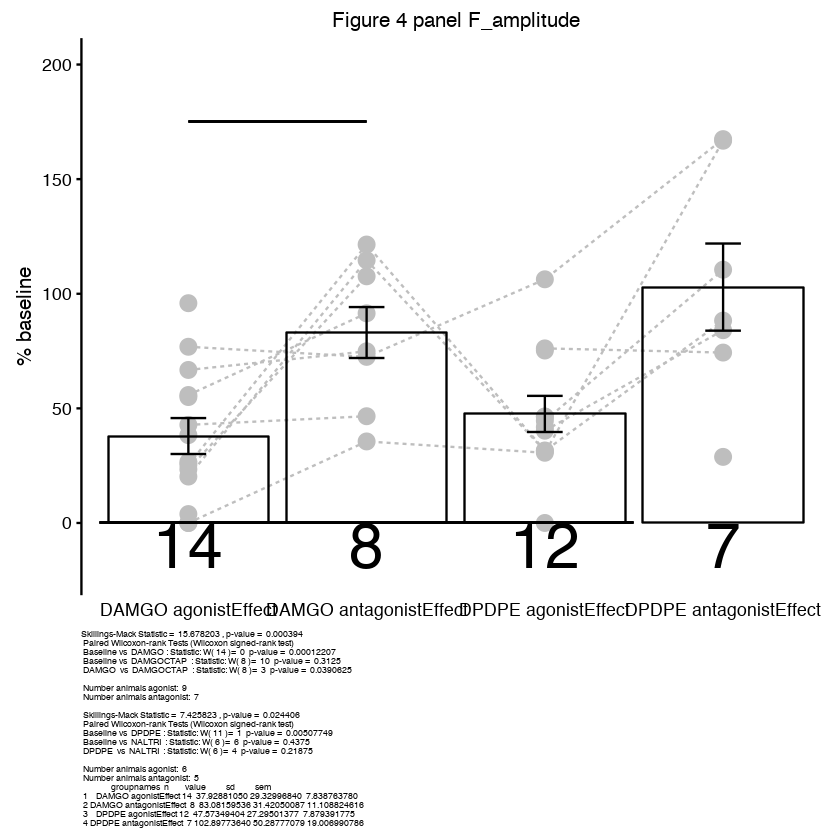

In [20]:
####################################################################################################
#     Figure 4 panel F
####################################################################################################
# Subset: opto stim in ACC of MD input, recorded IPSC, to L5 Pyr 
tempSDF = subset(df, genoType != "MORKOho" & genoType != "MORWTho" & genoType != "vGlut2cre" & stimSource == "MD" & circuit == "MD_L5_PYR")
tempSDF = subset(tempSDF, signal == "IPSC" & agonistName == "DAMGO" |signal == "IPSC" & agonistName == "DPDPE")

#Important for good functioning of the script: No need to change:
cols = colnames(tempSDF)
tempSDF = melt(tempSDF, id.vars = cols[1:19],measure.vars = cols[20:21])

# give the tempSDF a specific name, needs to be changed for every new subset
sDf = subset(tempSDF, parameter == 'amplitude' )#& antagonistName != "DPDPEICI" & antagonistName != "DPDPENALOX")
sDf$value[sDf$antagonistName =="DPDPEICI" & sDf$variable =="antagonistEffect" ] = NA
sDf$value[sDf$antagonistName =="DPDPENALOX" & sDf$variable =="antagonistEffect" ] = NA
xLabel = c("DAMGO", "DAMGOCTAP", "DPDPE","NALTRI")
antagonistSelect = c("DAMGOCTAP","DPDPENALTRI")
graphTitle = c("Figure 4 panel F")

# prepare data into matrix for Skillings-Mack test.
ssDf = subset(sDf, variable == "agonistEffect" | variable == "antagonistEffect")
ssDf = subset(ssDf, is.finite(baseValue)& is.finite(agonistValue))
# # to avoid problems with sign reversal during agonist/antagonist treatment all conditions that show a different sign from baseValue are set to 0.0001
# # after that the SMmatrix can be transformed to absolute values
for (u in 1:nrow(ssDf)){
  if (ssDf$baseValue[u]<0){
    if (is.finite(ssDf$agonistValue[u])){
      if (ssDf$agonistValue[u]>0){
        ssDf$agonistValue[u]=-0.0001
      }
    }
    if (is.finite(ssDf$antagonistValue[u])){
      if (ssDf$antagonistValue[u]>0){
        ssDf$antagonistValue[u]=-0.0001
      }
    }
  }
  if (ssDf$baseValue[u]>0){
    if (is.finite(ssDf$agonistValue[u])){
      if (ssDf$agonistValue[u]<0){
        ssDf$agonistValue[u]=0.0001
      }
    }
    if (is.finite(ssDf$antagonistValue[u])){
      if (ssDf$antagonistValue[u]<0){
        ssDf$antagonistValue[u]=0.0001
      }
    }
  }
  if (is.finite(ssDf$antagonistName[u])){
    if (ssDf$antagonistName[u] !=antagonistSelect[1] & ssDf$antagonistName[u] !=antagonistSelect[2]){
      ssDf$antagonistValue[u] = NA
    }
  }
}

ssDf$baseValue = abs(ssDf$baseValue)
ssDf$agonistValue =abs(ssDf$agonistValue)
ssDf$antagonistValue = abs(ssDf$antagonistValue)

# In this graph we will be having two sets of repeated measures omnibus test. Thus run first DAMGO followed by DPDPE
# DAMGO
##########
SMlen = length(unique(ssDf$cellID[ssDf$agonistName == 'DAMGO']))
SMmatrix = c(ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen], ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen], ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen])
Gs = c(rep('baseline',SMlen),rep('agonist',SMlen),rep('antagonist',SMlen))
Bs = rep(1:SMlen,3)

SMresult = capture.output(Ski.Mack(SMmatrix,groups=Gs, blocks=Bs))
BAgWilcox = wilcox.test(ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen],ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen],paired = TRUE)
BAgWilcoxFlip = wilcox.test(ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen],ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen],paired = TRUE)
BAgWilcox$statistic = min(c(BAgWilcox$statistic, BAgWilcoxFlip$statistic))
diff = c(ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen] - ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen])
BAgWilcox$n = length(na.omit(diff[diff !=0]))

BAnWilcox = wilcox.test(ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen],ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen], paired = TRUE)
BAnWilcoxFlip = wilcox.test(ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen],ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen],paired = TRUE)
BAnWilcox$statistic = min(c(BAnWilcox$statistic, BAnWilcoxFlip$statistic))
diff = c(ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen] - ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen])
BAnWilcox$n = length(na.omit(diff[diff !=0]))

AgAnWilcox= wilcox.test(ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen], ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen], paired = TRUE)
AgAnWilcoxFlip = wilcox.test(ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen],ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen],paired = TRUE)
AgAnWilcox$statistic = min(c(AgAnWilcox$statistic, AgAnWilcoxFlip$statistic))
diff = c(ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen] - ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen])
AgAnWilcox$n = length(na.omit(diff[diff !=0]))

BAgAnno = pvalAnno(BAgWilcox$p.value,1)
BAnAnno = pvalAnno(BAnWilcox$p.value,1)
AgAnAnno =  pvalAnno(AgAnWilcox$p.value,1)

reportString = paste(SMresult[2],'\n','Paired Wilcoxon-rank Tests (Wilcoxon signed-rank test) \n Baseline vs ',xLabel[1], ': Statistic: W(',BAgWilcox$n,')= ',BAgWilcox$statistic,' p-value = ',signif(BAgWilcox$p.value),'\n Baseline vs ', xLabel[2],' : Statistic: W(',BAnWilcox$n,')= ',BAnWilcox$statistic,' p-value = ',signif(BAnWilcox$p.value),'\n',xLabel[1],' vs ', xLabel[2],' : Statistic: W(',AgAnWilcox$n,')= ',AgAnWilcox$statistic,' p-value = ',signif(AgAnWilcox$p.value),'\n')
animalDf = subset(sDf, variable == 'agonistEffect' & agonistName == 'DAMGO' & is.finite(sDf$value))
agonistAnimal = length(unique(animalDf$animalID))
animalDf = subset(sDf, variable == 'antagonistEffect' & agonistName == 'DAMGO' & is.finite(sDf$value))
antagonistAnimal = length(unique(animalDf$animalID))
reportString1 = paste(reportString,'\n Number animals agonist: ',agonistAnimal,'\n Number animals antagonist: ', antagonistAnimal)

# DPDPE
##########
SMlen = length(unique(ssDf$cellID[ssDf$agonistName == 'DPDPE']))
SMmatrix = c(ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen], ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen], ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen])
Gs = c(rep('baseline',SMlen),rep('agonist',SMlen),rep('antagonist',SMlen))
Bs = rep(1:SMlen,3)

SMresult = capture.output(Ski.Mack(SMmatrix,groups=Gs, blocks=Bs))
BAgWilcox = wilcox.test(ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen],ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen],paired = TRUE)
BAgWilcoxFlip = wilcox.test(ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen],ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen],paired = TRUE)
BAgWilcox$statistic = min(c(BAgWilcox$statistic, BAgWilcoxFlip$statistic))
diff = c(ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen] - ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen])
BAgWilcox$n = length(na.omit(diff[diff !=0]))

BAnWilcox = wilcox.test(ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen],ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen], paired = TRUE)
BAnWilcoxFlip = wilcox.test(ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen],ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen],paired = TRUE)
BAnWilcox$statistic = min(c(BAnWilcox$statistic, BAnWilcoxFlip$statistic))
diff = c(ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen] - ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen])
BAnWilcox$n = length(na.omit(diff[diff !=0]))

AgAnWilcox= wilcox.test(ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen], ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen], paired = TRUE)

AgAnWilcoxFlip = wilcox.test(ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen],ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen],paired = TRUE)
AgAnWilcox$statistic = min(c(AgAnWilcox$statistic, AgAnWilcoxFlip$statistic))
diff = c(ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen] - ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen])
AgAnWilcox$n = length(na.omit(diff[diff !=0]))

BAgAnno = pvalAnno(BAgWilcox$p.value,1)
BAnAnno = pvalAnno(BAnWilcox$p.value,1)
AgAnAnno =  pvalAnno(AgAnWilcox$p.value,1)
reportString = paste(SMresult[2],'\n','Paired Wilcoxon-rank Tests (Wilcoxon signed-rank test) \n Baseline vs ',xLabel[3], ': Statistic: W(',BAgWilcox$n,')= ',BAgWilcox$statistic,' p-value = ',signif(BAgWilcox$p.value),'\n Baseline vs ', xLabel[4],' : Statistic: W(',BAnWilcox$n,')= ',BAnWilcox$statistic,' p-value = ',signif(BAnWilcox$p.value),'\n',xLabel[3],' vs ', xLabel[4],' : Statistic: W(',AgAnWilcox$n,')= ',AgAnWilcox$statistic,' p-value = ',signif(AgAnWilcox$p.value),'\n')
animalDf = subset(sDf, variable == 'agonistEffect' & agonistName == 'DPDPE' & is.finite(sDf$value))
agonistAnimal = length(unique(animalDf$animalID))
animalDf = subset(sDf, variable == 'antagonistEffect' & agonistName == 'DPDPE' & is.finite(sDf$value))
antagonistAnimal = length(unique(animalDf$animalID))
reportString2 = paste(reportString,'\n Number animals agonist: ',agonistAnimal,'\n Number animals antagonist: ', antagonistAnimal)


sDf$groupnames = paste(sDf$agonistName, sDf$variable)
data_summary = data_meanSDSEM(sDf, varname = "value", groupnames = "groupnames")

sumOut = capture.output(data_summary)
sumRepOut = sumOut[1]
for(u in 2:length(sumOut)){
  sumRepOut = paste(sumRepOut,'\n', sumOut[u])
}

ggplot(data_summary, aes(x = groupnames , y = value))+
  geom_point(data = sDf, aes(x = groupnames , y = value), fill = "gray", colour = "gray",size = 4)+
  geom_line(data = sDf, aes(group = cellID ), lty = 2, colour = "gray")+
  geom_bar(stat = "identity", position = position_dodge(), colour = "black", fill = NA)+
  geom_errorbar(aes(ymin=value-sem, ymax=value+sem), width=.2, position=position_dodge(.9))+
  coord_cartesian(ylim = c(-20,200))+
  theme_cowplot(font_size = 12)+
  stat_summary(data =sDf, fun.data = give.n, geom = "text",fun.y = median, position = position_dodge(width = 0.75), size = (6.51/8)*16)+
  labs(ylab('% baseline'))+
  labs(xlab(NULL))+
  labs(title = paste(graphTitle,"amplitude",sep='_'))+
  labs(caption = paste(reportString1,"\n\n", reportString2,'\n',sumRepOut))+
  theme(plot.caption = element_text(size = 5, hjust = 0))+
  theme(plot.title = element_text(size = 12))+
  geom_segment(aes(x=1, y=175, xend = 2, yend = 175))+
  geom_segment(aes(x=0.5, y=0, xend = 3.5, yend = 0))+
  theme(axis.line.x = element_line(linetype='blank'), axis.ticks.x = element_blank())+
  theme(text=element_text(size=12))

# Figure 4 - figure supplement 1
## Figure 4 - figure supplement 1c

Warning message:
“Removed 6 rows containing non-finite values (stat_summary).”Warning message:
“Removed 6 rows containing missing values (geom_point).”Warning message:
“Removed 6 rows containing missing values (geom_path).”

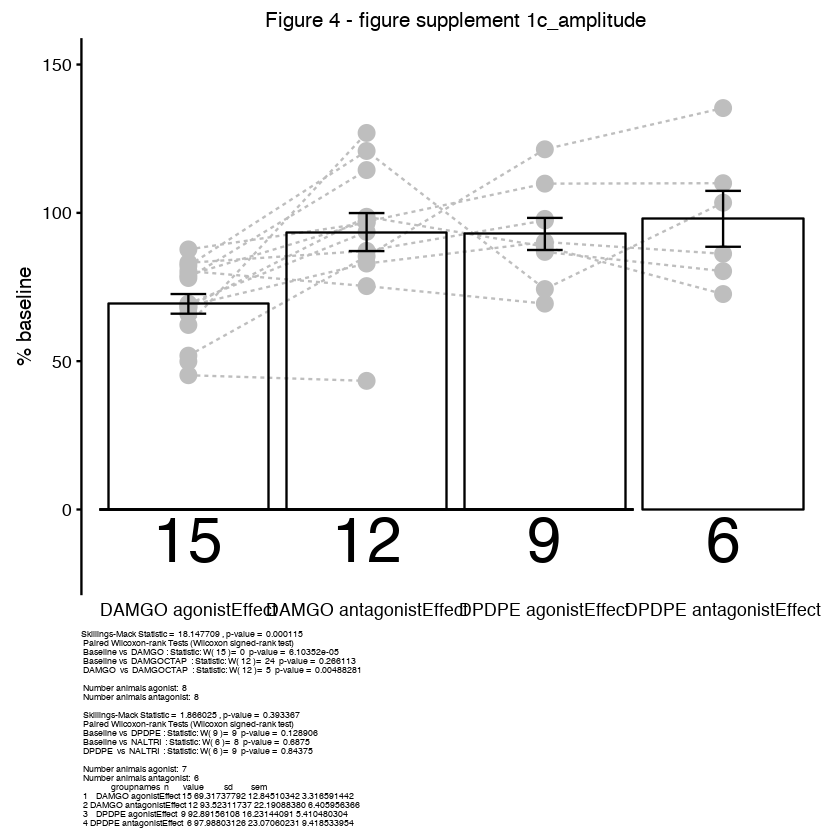

In [21]:
####################################################################################################
#     Figure 4 - figure supplement 1c
####################################################################################################
# Subset: photostim in ACC, recorded EPSC, from L23 PYR with DAMGO and DPDPE
tempSDF = subset(df, genoType != "MORKOho" & genoType != "MORWTho" & genoType != "vGlut2cre" & stimSource == "MD" & circuit == "MD_L2_PYR")
tempSDF = subset(tempSDF, signal == "EPSC" & agonistName == "DAMGO" |signal == "EPSC" & agonistName == "DPDPE")

tempSDF$antagonistName = as.factor(tempSDF$antagonistName)

#Important for good functioning of the script: No need to change:
cols = colnames(tempSDF)
tempSDF = melt(tempSDF, id.vars = cols[1:19],measure.vars = cols[20:21])

# give the tempSDF a specific name, needs to be changed for every new subset
sDf = subset(tempSDF, parameter == 'amplitude')
xLabel = c("DAMGO", "DAMGOCTAP", "DPDPE","NALTRI")
antagonistSelect = c("DAMGOCTAP","DPDPENALTRI")
graphTitle = c("Figure 4 - figure supplement 1c")

# prepare data into matrix for Skillings-Mack test.
ssDf = subset(sDf, variable == "agonistEffect" | variable == "antagonistEffect")
ssDf = subset(ssDf, is.finite(baseValue)& is.finite(agonistValue))
# # to avoid problems with sign reversal during agonist/antagonist treatment all conditions that show a different sign from baseValue are set to 0.0001
# # after that the SMmatrix can be transformed to absolute values
for (u in 1:nrow(ssDf)){
  if (ssDf$baseValue[u]<0){
    if (is.finite(ssDf$agonistValue[u])){
      if (ssDf$agonistValue[u]>0){
        ssDf$agonistValue[u]=-0.0001
      }
    }
    if (is.finite(ssDf$antagonistValue[u])){
      if (ssDf$antagonistValue[u]>0){
        ssDf$antagonistValue[u]=-0.0001
      }
    }
  }
  if (ssDf$baseValue[u]>0){
    if (is.finite(ssDf$agonistValue[u])){
      if (ssDf$agonistValue[u]<0){
        ssDf$agonistValue[u]=0.0001
      }
    }
    if (is.finite(ssDf$antagonistValue[u])){
      if (ssDf$antagonistValue[u]<0){
        ssDf$antagonistValue[u]=0.0001
      }
    }
  }
  if (is.finite(ssDf$antagonistName[u])){
    if (ssDf$antagonistName[u] !=antagonistSelect[1] & ssDf$antagonistName[u] !=antagonistSelect[2]){
      ssDf$antagonistValue[u] = NA
    }
  }
}
ssDf$baseValue = abs(ssDf$baseValue)
ssDf$agonistValue =abs(ssDf$agonistValue)
ssDf$antagonistValue = abs(ssDf$antagonistValue)

# In this graph we will be having two sets of repeated measures omnibus test. Thus run first DAMGO followed by DPDPE
# DAMGO
##########
SMlen = length(unique(ssDf$cellID[ssDf$agonistName == 'DAMGO']))
SMmatrix = c(ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen], ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen], ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen])
Gs = c(rep('baseline',SMlen),rep('agonist',SMlen),rep('antagonist',SMlen))
Bs = rep(1:SMlen,3)

SMresult = capture.output(Ski.Mack(SMmatrix,groups=Gs, blocks=Bs))
BAgWilcox = wilcox.test(ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen],ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen],paired = TRUE)
BAgWilcoxFlip = wilcox.test(ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen],ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen],paired = TRUE)
BAgWilcox$statistic = min(c(BAgWilcox$statistic, BAgWilcoxFlip$statistic))
diff = c(ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen] - ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen])
BAgWilcox$n = length(na.omit(diff[diff !=0]))


BAnWilcox = wilcox.test(ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen],ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen], paired = TRUE)
BAnWilcoxFlip = wilcox.test(ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen],ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen],paired = TRUE)
BAnWilcox$statistic = min(c(BAnWilcox$statistic, BAnWilcoxFlip$statistic))
diff = c(ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen] - ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen])
BAnWilcox$n = length(na.omit(diff[diff !=0]))


AgAnWilcox= wilcox.test(ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen], ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen], paired = TRUE)
AgAnWilcoxFlip = wilcox.test(ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen],ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen],paired = TRUE)
AgAnWilcox$statistic = min(c(AgAnWilcox$statistic, AgAnWilcoxFlip$statistic))
diff = c(ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen] - ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen])
AgAnWilcox$n = length(na.omit(diff[diff !=0]))

BAgAnno = pvalAnno(BAgWilcox$p.value,1)
BAnAnno = pvalAnno(BAnWilcox$p.value,1)
AgAnAnno =  pvalAnno(AgAnWilcox$p.value,1)

reportString = paste(SMresult[2],'\n','Paired Wilcoxon-rank Tests (Wilcoxon signed-rank test) \n Baseline vs ',xLabel[1], ': Statistic: W(',BAgWilcox$n,')= ',BAgWilcox$statistic,' p-value = ',signif(BAgWilcox$p.value),'\n Baseline vs ', xLabel[2],' : Statistic: W(',BAnWilcox$n,')= ',BAnWilcox$statistic,' p-value = ',signif(BAnWilcox$p.value),'\n',xLabel[1],' vs ', xLabel[2],' : Statistic: W(',AgAnWilcox$n,')= ',AgAnWilcox$statistic,' p-value = ',signif(AgAnWilcox$p.value),'\n')
animalDf = subset(sDf, variable == 'agonistEffect' & agonistName == 'DAMGO' & is.finite(sDf$value))
agonistAnimal = length(unique(animalDf$animalID))
animalDf = subset(sDf, variable == 'antagonistEffect' & agonistName == 'DAMGO' & is.finite(sDf$value))
antagonistAnimal = length(unique(animalDf$animalID))
reportString1 = paste(reportString,'\n Number animals agonist: ',agonistAnimal,'\n Number animals antagonist: ', antagonistAnimal)

# DPDPE
##########
SMlen = length(unique(ssDf$cellID[ssDf$agonistName == 'DPDPE']))
SMmatrix = c(ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen], ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen], ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen])
Gs = c(rep('baseline',SMlen),rep('agonist',SMlen),rep('antagonist',SMlen))
Bs = rep(1:SMlen,3)

SMresult = capture.output(Ski.Mack(SMmatrix,groups=Gs, blocks=Bs))
BAgWilcox = wilcox.test(ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen],ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen],paired = TRUE)
BAgWilcoxFlip = wilcox.test(ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen],ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen],paired = TRUE)
BAgWilcox$statistic = min(c(BAgWilcox$statistic, BAgWilcoxFlip$statistic))
diff = c(ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen] - ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen])
BAgWilcox$n = length(na.omit(diff[diff !=0]))

BAnWilcox = wilcox.test(ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen],ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen], paired = TRUE)
BAnWilcoxFlip = wilcox.test(ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen],ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen],paired = TRUE)
BAnWilcox$statistic = min(c(BAnWilcox$statistic, BAnWilcoxFlip$statistic))
diff = c(ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen] - ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen])
BAnWilcox$n = length(na.omit(diff[diff !=0]))

AgAnWilcox= wilcox.test(ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen], ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen], paired = TRUE)
AgAnWilcoxFlip = wilcox.test(ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen],ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen],paired = TRUE)
AgAnWilcox$statistic = min(c(AgAnWilcox$statistic, AgAnWilcoxFlip$statistic))
diff = c(ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen] - ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen])
AgAnWilcox$n = length(na.omit(diff[diff !=0]))

BAgAnno = pvalAnno(BAgWilcox$p.value,1)
BAnAnno = pvalAnno(BAnWilcox$p.value,1)
AgAnAnno =  pvalAnno(AgAnWilcox$p.value,1)

reportString = paste(SMresult[2],'\n','Paired Wilcoxon-rank Tests (Wilcoxon signed-rank test) \n Baseline vs ',xLabel[3], ': Statistic: W(',BAgWilcox$n,')= ',BAgWilcox$statistic,' p-value = ',signif(BAgWilcox$p.value),'\n Baseline vs ', xLabel[4],' : Statistic: W(',BAnWilcox$n,')= ',BAnWilcox$statistic,' p-value = ',signif(BAnWilcox$p.value),'\n',xLabel[3],' vs ', xLabel[4],' : Statistic: W(',AgAnWilcox$n,')= ',AgAnWilcox$statistic,' p-value = ',signif(AgAnWilcox$p.value),'\n')
animalDf = subset(sDf, variable == 'agonistEffect' & agonistName == 'DPDPE' & is.finite(sDf$value))
agonistAnimal = length(unique(animalDf$animalID))
animalDf = subset(sDf, variable == 'antagonistEffect' & agonistName == 'DPDPE' & is.finite(sDf$value))
antagonistAnimal = length(unique(animalDf$animalID))
reportString2 = paste(reportString,'\n Number animals agonist: ',agonistAnimal,'\n Number animals antagonist: ', antagonistAnimal)

sDf$groupnames = paste(sDf$agonistName, sDf$variable)
data_summary = data_meanSDSEM(sDf, varname = "value", groupnames = "groupnames")

sumOut = capture.output(data_summary)
sumRepOut = sumOut[1]
for(u in 2:length(sumOut)){
  sumRepOut = paste(sumRepOut,'\n', sumOut[u])
}

ggplot(data_summary, aes(x = groupnames , y = value))+
  geom_point(data = sDf, aes(x = groupnames , y = value), fill = "gray", colour = "gray",size = 4)+
  geom_line(data = sDf, aes(group = cellID ), lty = 2, colour = "gray")+
  geom_bar(stat = "identity", position = position_dodge(), colour = "black", fill = NA)+
  geom_errorbar(aes(ymin=value-sem, ymax=value+sem), width=.2, position=position_dodge(.9))+
  coord_cartesian(ylim = c(-20,150))+
  theme_cowplot(font_size = 12)+
  stat_summary(data =sDf, fun.data = give.n, geom = "text",fun.y = median, position = position_dodge(width = 0.75), size = (6.51/8)*16)+
  labs(ylab('% baseline'))+
  labs(xlab(NULL))+
  labs(title = paste(graphTitle,"amplitude",sep='_'))+
  labs(caption = paste(reportString1,"\n\n", reportString2,'\n',sumRepOut))+
  theme(plot.caption = element_text(size = 5, hjust = 0))+
  theme(plot.title = element_text(size = 12))+
  geom_segment(aes(x=1, y=175, xend = 2, yend = 175))+
  geom_segment(aes(x=0.5, y=0, xend = 3.5, yend = 0))+
  theme(axis.line.x = element_line(linetype='blank'), axis.ticks.x = element_blank())+
  theme(text=element_text(size=12))

## Figure 4 - figure supplement 1f

Warning message in wilcox.test.default(ssDf$baseValue[ssDf$agonistName == "DPDPE"][1:SMlen], :
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(ssDf$agonistValue[ssDf$agonistName == "DPDPE"][1:SMlen], :
“cannot compute exact p-value with ties”Warning message:
“Removed 23 rows containing non-finite values (stat_summary).”Warning message:
“Removed 23 rows containing missing values (geom_point).”Warning message:
“Removed 22 rows containing missing values (geom_path).”

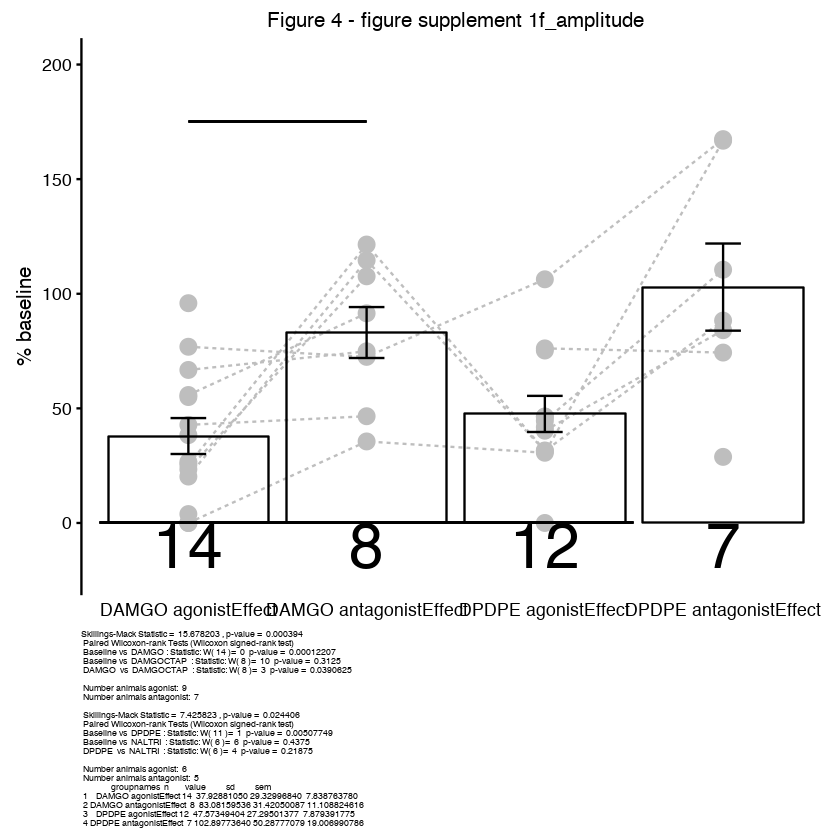

In [22]:
####################################################################################################
#     Figure 4 - figure supplement 1f
####################################################################################################
# Subset: opto stim in ACC of MD input, recorded IPSC, to L5 Pyr 
tempSDF = subset(df, genoType != "MORKOho" & genoType != "MORWTho" & genoType != "vGlut2cre" & stimSource == "MD" & circuit == "MD_L5_PYR")
tempSDF = subset(tempSDF, signal == "IPSC" & agonistName == "DAMGO" |signal == "IPSC" & agonistName == "DPDPE")

#Important for good functioning of the script: No need to change:
cols = colnames(tempSDF)
tempSDF = melt(tempSDF, id.vars = cols[1:19],measure.vars = cols[20:21])

# give the tempSDF a specific name, needs to be changed for every new subset
sDf = subset(tempSDF, parameter == 'amplitude' )#& antagonistName != "DPDPEICI" & antagonistName != "DPDPENALOX")
sDf$value[sDf$antagonistName =="DPDPEICI" & sDf$variable =="antagonistEffect" ] = NA
sDf$value[sDf$antagonistName =="DPDPENALOX" & sDf$variable =="antagonistEffect" ] = NA
xLabel = c("DAMGO", "DAMGOCTAP", "DPDPE","NALTRI")
antagonistSelect = c("DAMGOCTAP","DPDPENALTRI")
graphTitle = c("Figure 4 - figure supplement 1f")

# prepare data into matrix for Skillings-Mack test.
ssDf = subset(sDf, variable == "agonistEffect" | variable == "antagonistEffect")
ssDf = subset(ssDf, is.finite(baseValue)& is.finite(agonistValue))
# # to avoid problems with sign reversal during agonist/antagonist treatment all conditions that show a different sign from baseValue are set to 0.0001
# # after that the SMmatrix can be transformed to absolute values
for (u in 1:nrow(ssDf)){
  if (ssDf$baseValue[u]<0){
    if (is.finite(ssDf$agonistValue[u])){
      if (ssDf$agonistValue[u]>0){
        ssDf$agonistValue[u]=-0.0001
      }
    }
    if (is.finite(ssDf$antagonistValue[u])){
      if (ssDf$antagonistValue[u]>0){
        ssDf$antagonistValue[u]=-0.0001
      }
    }
  }
  if (ssDf$baseValue[u]>0){
    if (is.finite(ssDf$agonistValue[u])){
      if (ssDf$agonistValue[u]<0){
        ssDf$agonistValue[u]=0.0001
      }
    }
    if (is.finite(ssDf$antagonistValue[u])){
      if (ssDf$antagonistValue[u]<0){
        ssDf$antagonistValue[u]=0.0001
      }
    }
  }
  if (is.finite(ssDf$antagonistName[u])){
    if (ssDf$antagonistName[u] !=antagonistSelect[1] & ssDf$antagonistName[u] !=antagonistSelect[2]){
      ssDf$antagonistValue[u] = NA
    }
  }
}
ssDf$baseValue = abs(ssDf$baseValue)
ssDf$agonistValue =abs(ssDf$agonistValue)
ssDf$antagonistValue = abs(ssDf$antagonistValue)

# In this graph we will be having two sets of repeated measures omnibus test. Thus run first DAMGO followed by DPDPE

# DAMGO
##########
SMlen = length(unique(ssDf$cellID[ssDf$agonistName == 'DAMGO']))
SMmatrix = c(ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen], ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen], ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen])
Gs = c(rep('baseline',SMlen),rep('agonist',SMlen),rep('antagonist',SMlen))
Bs = rep(1:SMlen,3)

SMresult = capture.output(Ski.Mack(SMmatrix,groups=Gs, blocks=Bs))
BAgWilcox = wilcox.test(ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen],ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen],paired = TRUE)
BAgWilcoxFlip = wilcox.test(ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen],ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen],paired = TRUE)
BAgWilcox$statistic = min(c(BAgWilcox$statistic, BAgWilcoxFlip$statistic))
diff = c(ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen] - ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen])
BAgWilcox$n = length(na.omit(diff[diff !=0]))

BAnWilcox = wilcox.test(ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen],ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen], paired = TRUE)
BAnWilcoxFlip = wilcox.test(ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen],ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen],paired = TRUE)
BAnWilcox$statistic = min(c(BAnWilcox$statistic, BAnWilcoxFlip$statistic))
diff = c(ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen] - ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen])
BAnWilcox$n = length(na.omit(diff[diff !=0]))

AgAnWilcox= wilcox.test(ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen], ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen], paired = TRUE)
AgAnWilcoxFlip = wilcox.test(ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen],ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen],paired = TRUE)
AgAnWilcox$statistic = min(c(AgAnWilcox$statistic, AgAnWilcoxFlip$statistic))
diff = c(ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen] - ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen])
AgAnWilcox$n = length(na.omit(diff[diff !=0]))

BAgAnno = pvalAnno(BAgWilcox$p.value,1)
BAnAnno = pvalAnno(BAnWilcox$p.value,1)
AgAnAnno =  pvalAnno(AgAnWilcox$p.value,1)

reportString = paste(SMresult[2],'\n','Paired Wilcoxon-rank Tests (Wilcoxon signed-rank test) \n Baseline vs ',xLabel[1], ': Statistic: W(',BAgWilcox$n,')= ',BAgWilcox$statistic,' p-value = ',signif(BAgWilcox$p.value),'\n Baseline vs ', xLabel[2],' : Statistic: W(',BAnWilcox$n,')= ',BAnWilcox$statistic,' p-value = ',signif(BAnWilcox$p.value),'\n',xLabel[1],' vs ', xLabel[2],' : Statistic: W(',AgAnWilcox$n,')= ',AgAnWilcox$statistic,' p-value = ',signif(AgAnWilcox$p.value),'\n')
animalDf = subset(sDf, variable == 'agonistEffect' & agonistName == 'DAMGO' & is.finite(sDf$value))
agonistAnimal = length(unique(animalDf$animalID))
animalDf = subset(sDf, variable == 'antagonistEffect' & agonistName == 'DAMGO' & is.finite(sDf$value))
antagonistAnimal = length(unique(animalDf$animalID))
reportString1 = paste(reportString,'\n Number animals agonist: ',agonistAnimal,'\n Number animals antagonist: ', antagonistAnimal)

# DPDPE
##########
SMlen = length(unique(ssDf$cellID[ssDf$agonistName == 'DPDPE']))
SMmatrix = c(ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen], ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen], ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen])
Gs = c(rep('baseline',SMlen),rep('agonist',SMlen),rep('antagonist',SMlen))
Bs = rep(1:SMlen,3)

SMresult = capture.output(Ski.Mack(SMmatrix,groups=Gs, blocks=Bs))
BAgWilcox = wilcox.test(ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen],ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen],paired = TRUE)
BAgWilcoxFlip = wilcox.test(ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen],ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen],paired = TRUE)
BAgWilcox$statistic = min(c(BAgWilcox$statistic, BAgWilcoxFlip$statistic))
diff = c(ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen] - ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen])
BAgWilcox$n = length(na.omit(diff[diff !=0]))

BAnWilcox = wilcox.test(ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen],ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen], paired = TRUE)
BAnWilcoxFlip = wilcox.test(ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen],ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen],paired = TRUE)
BAnWilcox$statistic = min(c(BAnWilcox$statistic, BAnWilcoxFlip$statistic))
diff = c(ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen] - ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen])
BAnWilcox$n = length(na.omit(diff[diff !=0]))

AgAnWilcox= wilcox.test(ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen], ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen], paired = TRUE)
AgAnWilcoxFlip = wilcox.test(ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen],ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen],paired = TRUE)
AgAnWilcox$statistic = min(c(AgAnWilcox$statistic, AgAnWilcoxFlip$statistic))
diff = c(ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen] - ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen])
AgAnWilcox$n = length(na.omit(diff[diff !=0]))

BAgAnno = pvalAnno(BAgWilcox$p.value,1)
BAnAnno = pvalAnno(BAnWilcox$p.value,1)
AgAnAnno =  pvalAnno(AgAnWilcox$p.value,1)
reportString = paste(SMresult[2],'\n','Paired Wilcoxon-rank Tests (Wilcoxon signed-rank test) \n Baseline vs ',xLabel[3], ': Statistic: W(',BAgWilcox$n,')= ',BAgWilcox$statistic,' p-value = ',signif(BAgWilcox$p.value),'\n Baseline vs ', xLabel[4],' : Statistic: W(',BAnWilcox$n,')= ',BAnWilcox$statistic,' p-value = ',signif(BAnWilcox$p.value),'\n',xLabel[3],' vs ', xLabel[4],' : Statistic: W(',AgAnWilcox$n,')= ',AgAnWilcox$statistic,' p-value = ',signif(AgAnWilcox$p.value),'\n')
animalDf = subset(sDf, variable == 'agonistEffect' & agonistName == 'DPDPE' & is.finite(sDf$value))
agonistAnimal = length(unique(animalDf$animalID))
animalDf = subset(sDf, variable == 'antagonistEffect' & agonistName == 'DPDPE' & is.finite(sDf$value))
antagonistAnimal = length(unique(animalDf$animalID))
reportString2 = paste(reportString,'\n Number animals agonist: ',agonistAnimal,'\n Number animals antagonist: ', antagonistAnimal)

sDf$groupnames = paste(sDf$agonistName, sDf$variable)
data_summary = data_meanSDSEM(sDf, varname = "value", groupnames = "groupnames")

sumOut = capture.output(data_summary)
sumRepOut = sumOut[1]
for(u in 2:length(sumOut)){
  sumRepOut = paste(sumRepOut,'\n', sumOut[u])
}

ggplot(data_summary, aes(x = groupnames , y = value))+
  geom_point(data = sDf, aes(x = groupnames , y = value), fill = "gray", colour = "gray",size = 4)+
  geom_line(data = sDf, aes(group = cellID ), lty = 2, colour = "gray")+
  geom_bar(stat = "identity", position = position_dodge(), colour = "black", fill = NA)+
  geom_errorbar(aes(ymin=value-sem, ymax=value+sem), width=.2, position=position_dodge(.9))+
  coord_cartesian(ylim = c(-20,200))+
  theme_cowplot(font_size = 12)+
  stat_summary(data =sDf, fun.data = give.n, geom = "text",fun.y = median, position = position_dodge(width = 0.75), size = (6.51/8)*16)+
  labs(ylab('% baseline'))+
  labs(xlab(NULL))+
  labs(title = paste(graphTitle,"amplitude",sep='_'))+
  labs(caption = paste(reportString1,"\n\n", reportString2,'\n',sumRepOut))+
  theme(plot.caption = element_text(size = 5, hjust = 0))+
  theme(plot.title = element_text(size = 12))+
  geom_segment(aes(x=1, y=175, xend = 2, yend = 175))+
  geom_segment(aes(x=0.5, y=0, xend = 3.5, yend = 0))+
  theme(axis.line.x = element_line(linetype='blank'), axis.ticks.x = element_blank())+
  theme(text=element_text(size=12))

## Figure 4 - figure supplement 2c

Warning message:
“Removed 19 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 19 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 19 rows containing missing values (geom_point).”

circuit,animalID
MD_DMS_MSN,"43, 17, 12, 13, 14, 10, 11, 15, 16, 18, 19, 20, 27, 28, 7, 8, 9, 29, 32, 34, 36, 39, 50, 55, 56, 57, 45, 46, 48, 54, 60, 61, 62"
MD_L2_PYR,"2, 1, 3, 22, 23, 24, 25, 48, 50, 52, 53, 4, 49"
MD_L5_PYR,"2, 1, 23, 26, 6, 30, 31, 35, 33, 37, 38, 39, 40, 42, 43, 44, 47, 48, 21, 5, 49"
TAIL_DMS_MSN,"41, 51, 58"
TAIL_L2_PYR,"58, 59"
TAIL_L5_PYR,"41, 51, 58"
TAIL_SEP_SEP,"41, 51, 58, 59"


Warning message:
“Removed 19 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 19 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 19 rows containing missing values (geom_point).”

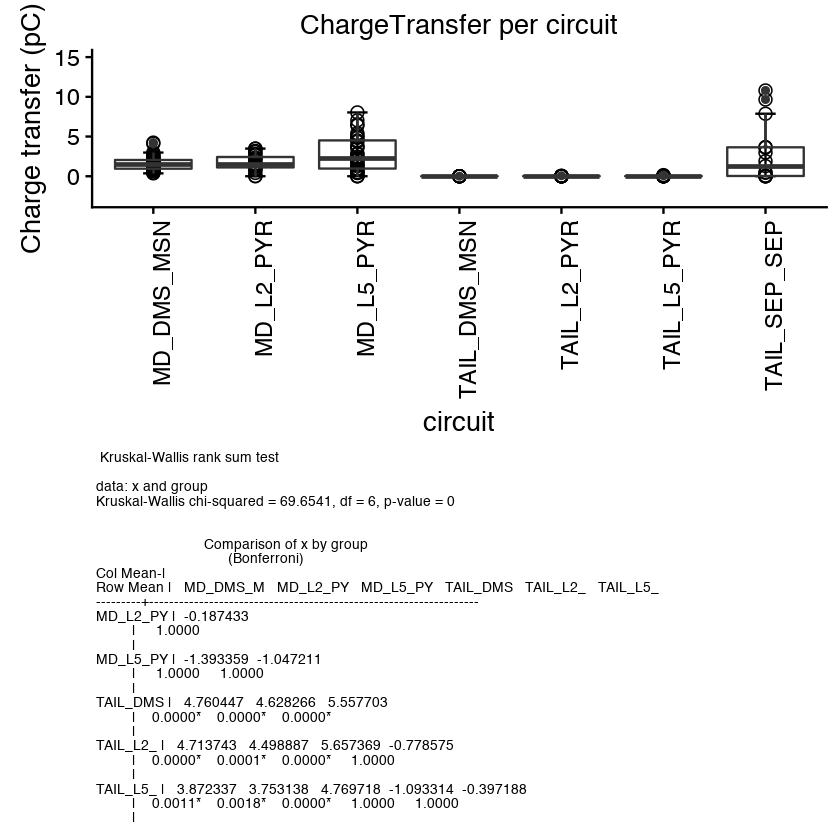

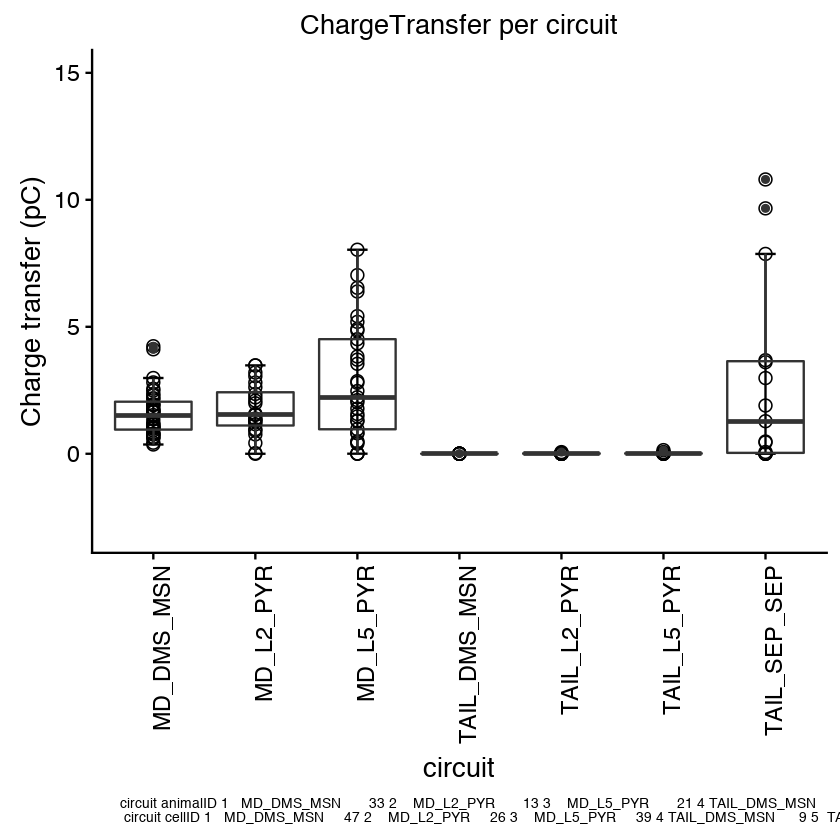

In [23]:
####################################################################################################
#     Figure 4 - figure supplement 2c
####################################################################################################
selectCell = read.csv("data/chargeTransferTailExp.csv" )
selectCell$AUC = abs(selectCell$AUC)
############## FUNCTION ###############
give.n <- function(x){
    return(c(y = -2, label = length(x)))
}
######################################
# Statistics for the tail injected only:
tailDf = selectCell[grepl('TAIL',selectCell$circuit),] 
tailDf = subset(tailDf, !is.nan(AUC))
r= capture.output(dunn.test(tailDf$AUC,tailDf$circuit, kw = TRUE, method = 'hochberg'))
reportString = paste(r[1],'\n',r[2],'\n',r[3],'\n',r[4],'\n',r[5],'\n',r[6],'\n',r[7],'\n',r[8],'\n',r[9],'\n',r[10],'\n',r[11],'\n',r[12],'\n',r[13],'\n',r[14],'\n',r[15],'\n',r[16],'\n',r[17],'\n',r[18],'\n',r[19],'\n',r[20])

# Statistics for the all groups:
r= capture.output(dunn.test(selectCell$AUC,selectCell$circuit, kw = TRUE, method = 'bonferroni'))
reportString = paste(r[1],'\n',r[2],'\n',r[3],'\n',r[4],'\n',r[5],'\n',r[6],'\n',r[7],'\n',r[8],'\n',r[9],'\n',r[10],'\n',r[11],'\n',r[12],'\n',r[13],'\n',r[14],'\n',r[15],'\n',r[16],'\n',r[17],'\n',r[18],'\n',r[19],'\n',r[20],'\n',r[21],'\n',r[22],'\n',r[23],'\n',r[24],'\n',r[25],'\n',r[26])

# order selectCell factors:
selectCell$circuit <- factor(selectCell$circuit, c('MD_DMS_MSN','MD_L2_PYR','MD_L5_PYR','TAIL_DMS_MSN','TAIL_L2_PYR','TAIL_L5_PYR','TAIL_SEP_SEP'))

# count number of cells tested;
uniqAnimal= capture.output(aggregate(animalID ~ circuit,selectCell,function(x) length(unique(x))))
uniqCell= capture.output(aggregate(cellID ~ circuit,selectCell,function(x) length(unique(x))))

#plot
ggplot(selectCell, aes(x = circuit, y = AUC))+
    geom_point(shape = 1, colour = 'black', fill = NA, size = 3)+
    coord_cartesian(ylim = c(-3, 15))+
    stat_boxplot(geom = 'errorbar', width = 0.2)+
    geom_boxplot(varwidth = FALSE, notch = FALSE, fill = NA)+
    theme_cowplot(font_size = 16)+
    labs(ylab('Charge transfer (pC)'))+
    theme(axis.text.x=element_text(angle=90,hjust=1))+
    labs(title = 'ChargeTransfer per circuit')+
    labs(caption = reportString)+
    theme(plot.caption = element_text(size = 8, hjust = 0))+
    theme(plot.title = element_text(size = 16))

#To count the amount of animals used:
aggregate(animalID ~ circuit, selectCell, unique)
reportString3 = paste(uniqAnimal[1],uniqAnimal[2],uniqAnimal[3],uniqAnimal[4],uniqAnimal[5],uniqAnimal[6],uniqAnimal[7],uniqAnimal[8],'\n',uniqCell[1],uniqCell[2],uniqCell[3],uniqCell[4],uniqCell[5],uniqCell[6],uniqCell[7],uniqCell[8])
#plot
ggplot(selectCell, aes(x = circuit, y = AUC))+
  geom_point(shape = 1, colour = 'black', fill = NA, size = 3)+
  coord_cartesian(ylim = c(-3, 15))+
  stat_boxplot(geom = 'errorbar', width = 0.2)+
  geom_boxplot(varwidth = FALSE, notch = FALSE, fill = NA)+
  theme_cowplot(font_size = 16)+
  labs(ylab('Charge transfer (pC)'))+
  theme(axis.text.x=element_text(angle=90,hjust=1))+
  labs(title = 'ChargeTransfer per circuit')+
  labs(caption = reportString3)+
  theme(plot.caption = element_text(size = 8, hjust = 0))+
  theme(plot.title = element_text(size = 16))

## Figure 4 - figure supplement 2d

Warning message:
“Removed 6 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 6 rows containing missing values (geom_point).”

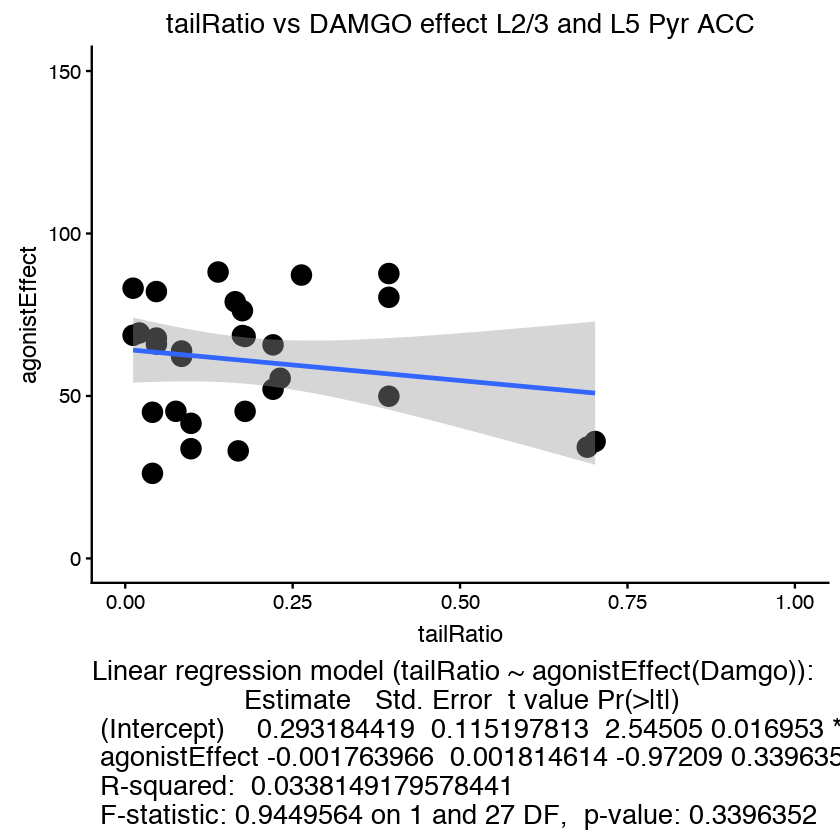

In [24]:
################################################################################################################################
##    Figure 4 - figure supplement 2d
####################################################################################################################################
# Subset all recordings of L2/3 and L5 pyramidal neurons in the ACC for which ENK was tested (only need the amplitude effects of the agonist)
teDf = subset(df, signal == "EPSC" & parameter == "amplitude" & agonistName == "DAMGO")
teDf = subset(teDf, circuit =="MD_L2_PYR"|circuit == "MD_L5_PYR")

#build linear regression model for tailRatio vs agonistEffect
tail.model = lm(tailRatio~agonistEffect, data = teDf)
modelOutput = capture.output(summary(tail.model))
reportString = paste('Linear regression model (tailRatio ~ agonistEffect(Damgo)):\n',modelOutput[10],'\n',modelOutput[11],'\n',modelOutput[12],'\n R-squared: ',summary(tail.model)$r.squared,'\n',modelOutput[19])
titleGr = 'tailRatio vs DAMGO effect L2/3 and L5 Pyr ACC'
# plot correlation graph
ggplot(teDf, aes(x=tailRatio, y=agonistEffect))+
  geom_point(size = 5)+
  geom_smooth(method=lm)+
  coord_cartesian(xlim = c(0, 1.0), ylim = c(0, 150))+
  labs(caption = reportString)+
  labs(title = titleGr)+
  theme(plot.caption = element_text(size = 16, hjust = 0))+
  theme(plot.title = element_text(size = 16))

# Figure 5
## Figure 5c

Warning message:
“Removed 7 rows containing non-finite values (stat_summary).”Warning message:
“Removed 7 rows containing missing values (geom_point).”Warning message:
“Removed 7 rows containing missing values (geom_path).”

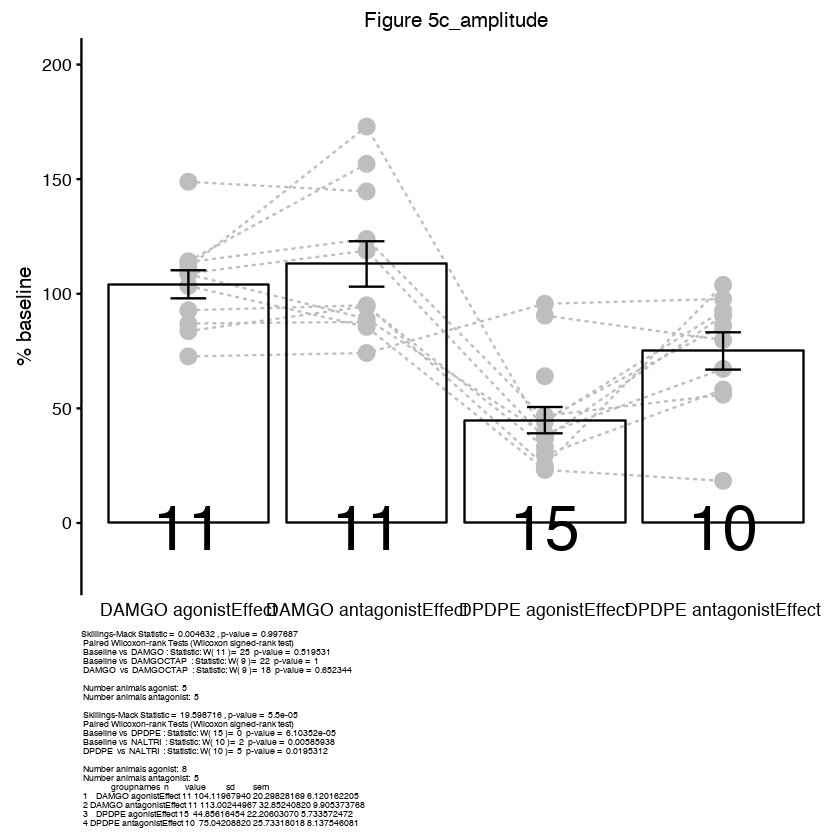

In [25]:
####################################################################################################
#     Figure 5c
####################################################################################################
# Subset: opto stim of L5PV in ACC, recorded EPSC, from L5 PYR with DAMGO/DPDPE
tempSDF = subset(df, genoType != "MORKOho" & genoType != "MORWTho" & genoType != "vGlut2cre" & stimSource == "PV" & circuit == "PV_L5_PYR")
tempSDF = subset(tempSDF, signal == "IPSC" & agonistName == "DAMGO" |signal == "IPSC" & agonistName == "DPDPE")

#Important for good functioning of the script: No need to change:
cols = colnames(tempSDF)
tempSDF = melt(tempSDF, id.vars = cols[1:19],measure.vars = cols[20:21])

# give the tempSDF a specific name, needs to be changed for every new subset
sDf = subset(tempSDF, parameter == 'amplitude' )#& antagonistName != "DPDPEICI" & antagonistName != "DPDPENALOX")
sDf$value[sDf$antagonistName =="DPDPEICI" & sDf$variable =="antagonistEffect" ] = NA
sDf$value[sDf$antagonistName =="DPDPENALOX" & sDf$variable =="antagonistEffect" ] = NA
xLabel = c("DAMGO", "DAMGOCTAP", "DPDPE","NALTRI")
antagonistSelect = c("DAMGOCTAP","DPDPENALTRI")
graphTitle = c("Figure 5c")

# prepare data into matrix for Skillings-Mack test.
ssDf = subset(sDf, variable == "agonistEffect" | variable == "antagonistEffect")
ssDf = subset(ssDf, is.finite(baseValue)& is.finite(agonistValue))
# # to avoid problems with sign reversal during agonist/antagonist treatment all conditions that show a different sign from baseValue are set to 0.0001
# # after that the SMmatrix can be transformed to absolute values
for (u in 1:nrow(ssDf)){
  if (ssDf$baseValue[u]<0){
    if (is.finite(ssDf$agonistValue[u])){
      if (ssDf$agonistValue[u]>0){
        ssDf$agonistValue[u]=-0.0001
      }
    }
    if (is.finite(ssDf$antagonistValue[u])){
      if (ssDf$antagonistValue[u]>0){
        ssDf$antagonistValue[u]=-0.0001
      }
    }
  }
  if (ssDf$baseValue[u]>0){
    if (is.finite(ssDf$agonistValue[u])){
      if (ssDf$agonistValue[u]<0){
        ssDf$agonistValue[u]=0.0001
      }
    }
    if (is.finite(ssDf$antagonistValue[u])){
      if (ssDf$antagonistValue[u]<0){
        ssDf$antagonistValue[u]=0.0001
      }
    }
  }
  if (is.finite(ssDf$antagonistName[u])){
    if (ssDf$antagonistName[u] !=antagonistSelect[1] & ssDf$antagonistName[u] !=antagonistSelect[2]){
      ssDf$antagonistValue[u] = NA
    }
  }
}
ssDf$baseValue = abs(ssDf$baseValue)
ssDf$agonistValue =abs(ssDf$agonistValue)
ssDf$antagonistValue = abs(ssDf$antagonistValue)

# In this graph we will be having two sets of repeated measures omnibus test. Thus run first DAMGO followed by DPDPE
# DAMGO
##########
SMlen = length(unique(ssDf$cellID[ssDf$agonistName == 'DAMGO']))
SMmatrix = c(ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen], ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen], ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen])
Gs = c(rep('baseline',SMlen),rep('agonist',SMlen),rep('antagonist',SMlen))
Bs = rep(1:SMlen,3)

SMresult = capture.output(Ski.Mack(SMmatrix,groups=Gs, blocks=Bs))
# Turns out that the statistic needs to be reported differently. One need the number of pairs(n) that have difference != 0. And the lowest signed rank sum value (x) is given. Denoted as W(n)=x. Thus per comparison the number of pairs with difference !=0 and the lowest signed rank sum value needs to be calculated

BAgWilcox = wilcox.test(ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen],ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen],paired = TRUE)
BAgWilcoxFlip = wilcox.test(ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen],ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen],paired = TRUE)
BAgWilcox$statistic = min(c(BAgWilcox$statistic, BAgWilcoxFlip$statistic))
diff = c(ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen] - ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen])
BAgWilcox$n = length(na.omit(diff[diff !=0]))

BAnWilcox = wilcox.test(ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen],ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen], paired = TRUE)
BAnWilcoxFlip = wilcox.test(ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen],ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen],paired = TRUE)
BAnWilcox$statistic = min(c(BAnWilcox$statistic, BAnWilcoxFlip$statistic))
diff = c(ssDf$baseValue[ssDf$agonistName == 'DAMGO'][1:SMlen] - ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen])
BAnWilcox$n = length(na.omit(diff[diff !=0]))

AgAnWilcox= wilcox.test(ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen], ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen], paired = TRUE)
AgAnWilcoxFlip = wilcox.test(ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen],ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen],paired = TRUE)
AgAnWilcox$statistic = min(c(AgAnWilcox$statistic, AgAnWilcoxFlip$statistic))
diff = c(ssDf$agonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen] - ssDf$antagonistValue[ssDf$agonistName == 'DAMGO'][1:SMlen])
AgAnWilcox$n = length(na.omit(diff[diff !=0]))

BAgAnno = pvalAnno(BAgWilcox$p.value,1)
BAnAnno = pvalAnno(BAnWilcox$p.value,1)
AgAnAnno =  pvalAnno(AgAnWilcox$p.value,1)

reportString = paste(SMresult[2],'\n','Paired Wilcoxon-rank Tests (Wilcoxon signed-rank test) \n Baseline vs ',xLabel[1], ': Statistic: W(',BAgWilcox$n,')= ',BAgWilcox$statistic,' p-value = ',signif(BAgWilcox$p.value),'\n Baseline vs ', xLabel[2],' : Statistic: W(',BAnWilcox$n,')= ',BAnWilcox$statistic,' p-value = ',signif(BAnWilcox$p.value),'\n',xLabel[1],' vs ', xLabel[2],' : Statistic: W(',AgAnWilcox$n,')= ',AgAnWilcox$statistic,' p-value = ',signif(AgAnWilcox$p.value),'\n')
animalDf = subset(sDf, variable == 'agonistEffect' & agonistName == 'DAMGO' & is.finite(sDf$value))
agonistAnimal = length(unique(animalDf$animalID))
animalDf = subset(sDf, variable == 'antagonistEffect' & agonistName == 'DAMGO' & is.finite(sDf$value))
antagonistAnimal = length(unique(animalDf$animalID))
reportString1 = paste(reportString,'\n Number animals agonist: ',agonistAnimal,'\n Number animals antagonist: ', antagonistAnimal)

# DPDPE
##########
SMlen = length(unique(ssDf$cellID[ssDf$agonistName == 'DPDPE']))
SMmatrix = c(ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen], ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen], ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen])
Gs = c(rep('baseline',SMlen),rep('agonist',SMlen),rep('antagonist',SMlen))
Bs = rep(1:SMlen,3)

SMresult = capture.output(Ski.Mack(SMmatrix,groups=Gs, blocks=Bs))
BAgWilcox = wilcox.test(ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen],ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen],paired = TRUE)
BAgWilcoxFlip = wilcox.test(ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen],ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen],paired = TRUE)
BAgWilcox$statistic = min(c(BAgWilcox$statistic, BAgWilcoxFlip$statistic))
diff = c(ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen] - ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen])
BAgWilcox$n = length(na.omit(diff[diff !=0]))

BAnWilcox = wilcox.test(ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen],ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen], paired = TRUE)
BAnWilcoxFlip = wilcox.test(ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen],ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen],paired = TRUE)
BAnWilcox$statistic = min(c(BAnWilcox$statistic, BAnWilcoxFlip$statistic))
diff = c(ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen] - ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen])
BAnWilcox$n = length(na.omit(diff[diff !=0]))

AgAnWilcox= wilcox.test(ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen], ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen], paired = TRUE)
AgAnWilcoxFlip = wilcox.test(ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen],ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen],paired = TRUE)
AgAnWilcox$statistic = min(c(AgAnWilcox$statistic, AgAnWilcoxFlip$statistic))
diff = c(ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen] - ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen])
AgAnWilcox$n = length(na.omit(diff[diff !=0]))

BAgAnno = pvalAnno(BAgWilcox$p.value,1)
BAnAnno = pvalAnno(BAnWilcox$p.value,1)
AgAnAnno =  pvalAnno(AgAnWilcox$p.value,1)
reportString = paste(SMresult[2],'\n','Paired Wilcoxon-rank Tests (Wilcoxon signed-rank test) \n Baseline vs ',xLabel[3], ': Statistic: W(',BAgWilcox$n,')= ',BAgWilcox$statistic,' p-value = ',signif(BAgWilcox$p.value),'\n Baseline vs ', xLabel[4],' : Statistic: W(',BAnWilcox$n,')= ',BAnWilcox$statistic,' p-value = ',signif(BAnWilcox$p.value),'\n',xLabel[3],' vs ', xLabel[4],' : Statistic: W(',AgAnWilcox$n,')= ',AgAnWilcox$statistic,' p-value = ',signif(AgAnWilcox$p.value),'\n')
animalDf = subset(sDf, variable == 'agonistEffect' & agonistName == 'DPDPE' & is.finite(sDf$value))
agonistAnimal = length(unique(animalDf$animalID))
animalDf = subset(sDf, variable == 'antagonistEffect' & agonistName == 'DPDPE' & is.finite(sDf$value))
antagonistAnimal = length(unique(animalDf$animalID))
reportString2 = paste(reportString,'\n Number animals agonist: ',agonistAnimal,'\n Number animals antagonist: ', antagonistAnimal)

sDf$groupnames = paste(sDf$agonistName, sDf$variable)
data_summary = data_meanSDSEM(sDf, varname = "value", groupnames = "groupnames")

sumOut = capture.output(data_summary)
sumRepOut = sumOut[1]
for(u in 2:length(sumOut)){
  sumRepOut = paste(sumRepOut,'\n', sumOut[u])
}

ggplot(data_summary, aes(x = groupnames , y = value))+
  geom_point(data = sDf, aes(x = groupnames , y = value), fill = "gray", colour = "gray",size = 4)+
  geom_line(data = sDf, aes(group = cellID ), lty = 2, colour = "gray")+
  geom_bar(stat = "identity", position = position_dodge(), colour = "black", fill = NA)+
  geom_errorbar(aes(ymin=value-sem, ymax=value+sem), width=.2, position=position_dodge(.9))+
  coord_cartesian(ylim = c(-20,200))+
  theme_cowplot(font_size = 12)+
  stat_summary(data =sDf, fun.data = give.n, geom = "text",fun.y = median, position = position_dodge(width = 0.75), size = (6.51/8)*16)+
  labs(ylab('% baseline'))+
  labs(xlab(NULL))+
  labs(title = paste(graphTitle,"amplitude",sep='_'))+
  labs(caption = paste(reportString1,"\n\n", reportString2,'\n',sumRepOut))+
  theme(plot.caption = element_text(size = 5, hjust = 0))+
  theme(plot.title = element_text(size = 12))+
  theme(axis.line.x = element_line(linetype='blank'), axis.ticks.x = element_blank())+
  theme(text=element_text(size=12))

## Figure 5f

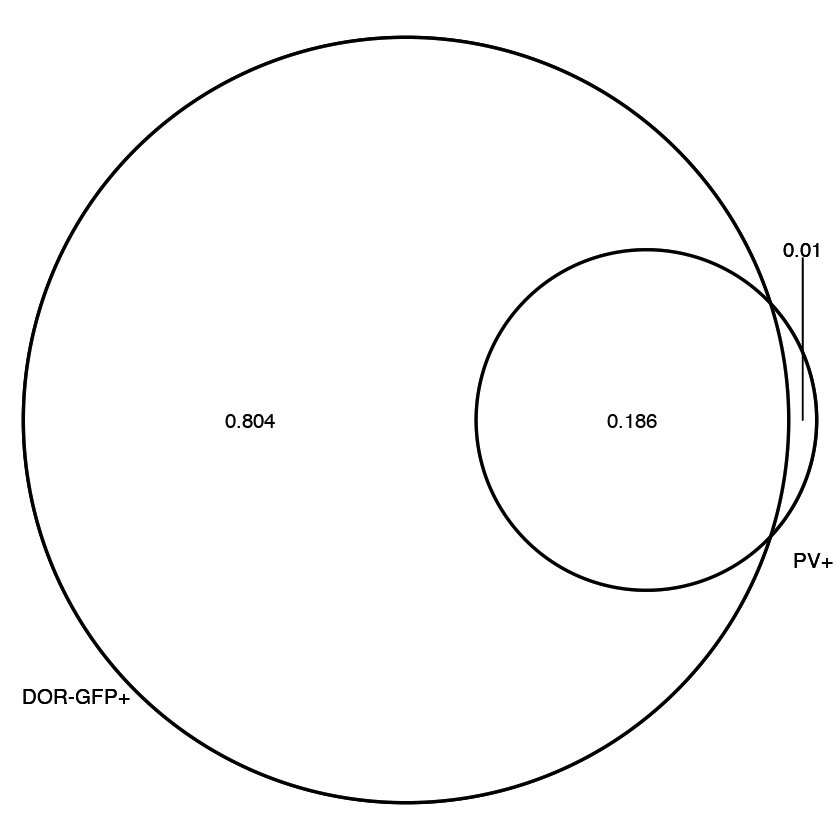

In [26]:
####################################################################################################
#     Figure 5f
####################################################################################################
# plot venn diagram
# based on data: DOR PV ACC Counting.xls

IHC_PV_mean = 0.196
IHC_DOR_mean = 0.990
IHC_PVDOR_mean = 0.186

IHC_PV_stdev = 0.005
IHC_DOR_stdev = 0.001
IHC_PVDOR_stdev = 0.006

ISH_pvalb_mean = 0.255
ISH_oprd1_mean = 0.972
ISH_pvalboprd1_mean = 	0.227

ISH_pvalb_stdev = 0.029
ISH_oprd1_stdev = 0.005
ISH_pvalboprd1_stdev =	0.034

vennIHC.plot <- draw.pairwise.venn(IHC_PV_mean, IHC_DOR_mean, IHC_PVDOR_mean, c("PV+", "DOR-GFP+"))

grid.draw(vennIHC.plot)

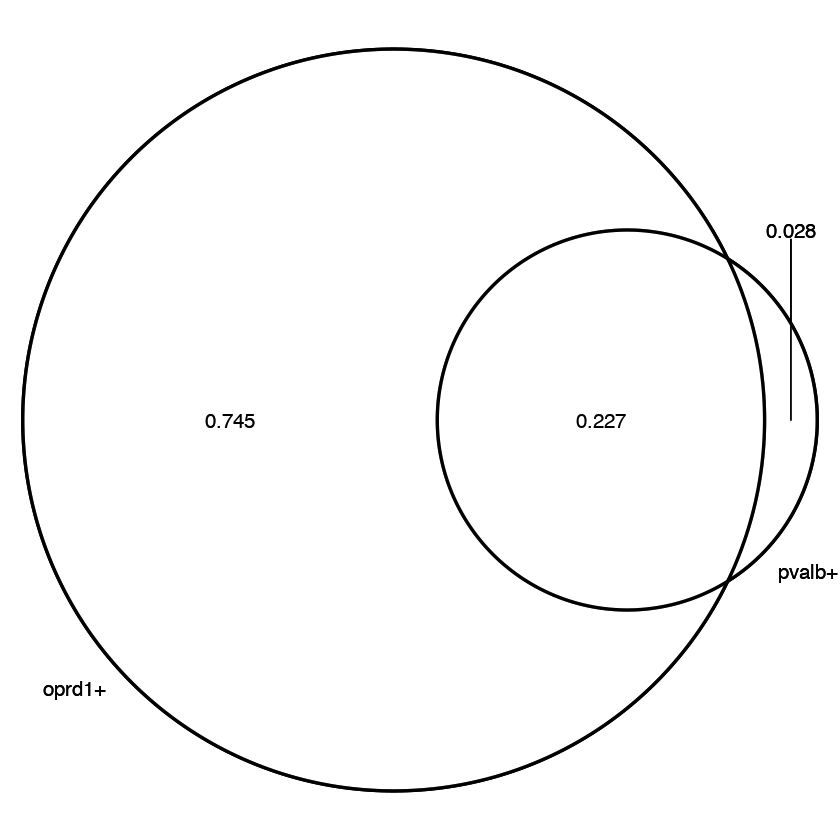

In [27]:
vennISH.plot <- draw.pairwise.venn(ISH_pvalb_mean, ISH_oprd1_mean, ISH_pvalboprd1_mean, c("pvalb+", "oprd1+"))
grid.draw(vennISH.plot)

# Figure 6
See analyze_cellAttached_experiments.m

# Figure 6 - figure supplement 1

[1] "DAMGO AP latency Skillings-Mack analysis"

Skillings-Mack Statistic =  2.000000 , p-value =  0.367879 
Note: the p-value is based on the chi-squared distribution with d.f. =  2 

$Nblocks
[1] 7

$Ntreatments
[1] 3

$rawdata
             [,1]        [,2]        [,3]        [,4]        [,5]         [,6]
[1,]  9.240740741 11.28064516 13.33684211 13.07600000 11.41578947 12.386486486
[2,] 12.900000000 10.36896552 13.50000000 15.04000000 10.46000000 14.490000000
[3,] 10.995833333 11.10975610 13.43636364 15.44285714 12.72000000  9.479487179
            [,7]
[1,] 13.86000000
[2,] 18.46666667
[3,] 18.73333333

$rankdata
     [,1] [,2] [,3] [,4] [,5] [,6] [,7]
[1,]    1    3    1    1    2    2    1
[2,]    3    1    3    2    1    3    2
[3,]    2    2    2    3    3    1    3

$varCovarMatrix
     [,1] [,2] [,3]
[1,]   14   -7   -7
[2,]   -7   14   -7
[3,]   -7   -7   14

$adjustedSum
             [,1]        [,2]        [,3]
[1,] -5.196152423 1.732050808 3.464101615

[1] "Paired Wilcoxon

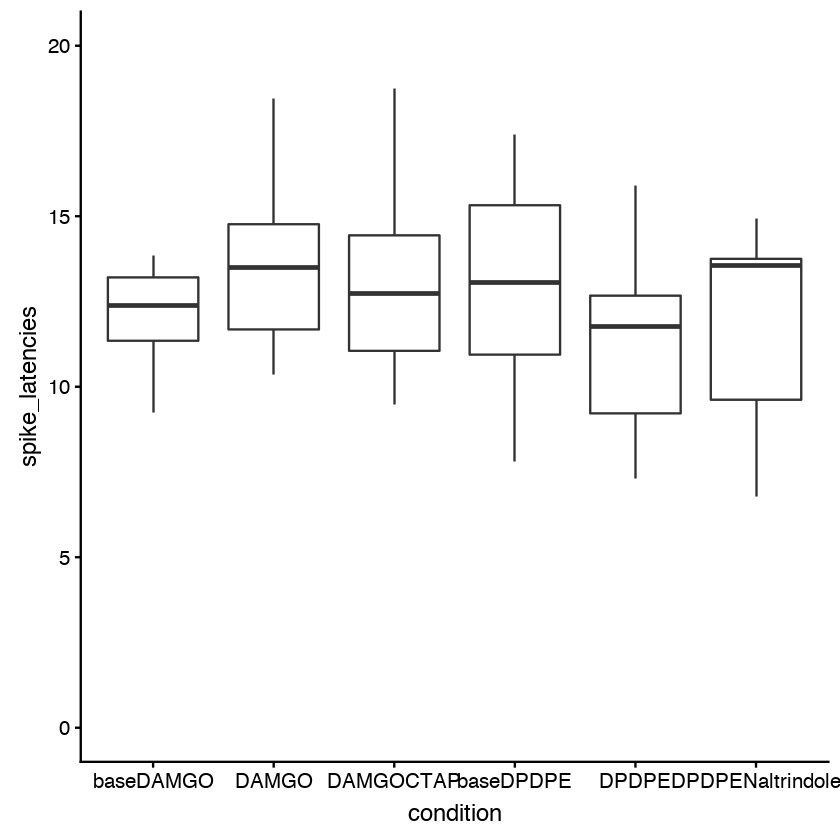

In [28]:
####################################################################################################
#     Figure 6 - figure supplement 1
####################################################################################################
# Plot latency data and perform Test for Significance on spike probability
# across conditions
# Requires installation of packages: 'Skillings.Mack', 'ggplot2', 'cowplot'
library(Skillings.Mack)
library(ggplot2)
library(cowplot)
df_latency = read.csv('data/data_cellAttached_latencies.csv')

# subset for all DAMGO experiments with a baseline value
df_DAMGO = df_latency[rep(!is.nan(df_latency$spike_latency_DAMGO[grep('baseDAMGO', df_latency$conditionDAMGO)]),3),c('spike_latency_DAMGO', 'conditionDAMGO','cellDAMGO','expDAMGO')]
print('DAMGO AP latency Skillings-Mack analysis')
Ski.Mack(df_DAMGO$spike_latency_DAMGO,df_DAMGO$conditionDAMGO,df_DAMGO$cellDAMGO)
print('Paired Wilcoxon signed rank test baseline vs Damgo')
# define here the two groups to compare
first_group = df_DAMGO$spike_latency_DAMGO[df_DAMGO$conditionDAMGO=='baseDAMGO']
second_group = df_DAMGO$spike_latency_DAMGO[df_DAMGO$conditionDAMGO=='DAMGO']
# Below is required to calculate n and statistic in a sequence independent way
# (first vs second group and second vs first group)
wilcox_antero = wilcox.test(first_group, second_group, paired = TRUE)
wilcox_retro = wilcox.test(second_group, first_group, paired = TRUE)
statistic = min(c(wilcox_antero$statistic, wilcox_retro$statistic))
diff = c(first_group-second_group)
n = length(na.omit(diff[diff != 0]))
print(paste('W(', n, ') = ', statistic, '. p = ', wilcox_antero$p.value))

print('Paired Wilcoxon signed rank test Damgo vs CTAP')
# define here the two groups to compare
first_group = df_DAMGO$spike_latency_DAMGO[df_DAMGO$conditionDAMGO=='DAMGO']
second_group = df_DAMGO$spike_latency_DAMGO[df_DAMGO$conditionDAMGO=='DAMGOCTAP']
# Below is required to calculate n and statistic in a sequence independent way
# (first vs second group and second vs first group)
wilcox_antero = wilcox.test(first_group, second_group, paired = TRUE)
wilcox_retro = wilcox.test(second_group, first_group, paired = TRUE)
statistic = min(c(wilcox_antero$statistic, wilcox_retro$statistic))
diff = c(first_group-second_group)
n = length(na.omit(diff[diff != 0]))
print(paste('W(', n, ') = ', statistic, '. p = ', wilcox_antero$p.value))

# subset for all DPDPE experiments with a baseline value
df_DPDPE = df_latency[rep(!is.nan(df_latency$spike_latency_DPDPE[grep('baseDPDPE', df_latency$conditionDPDPE)]),3),c('spike_latency_DPDPE', 'conditionDPDPE','cellDPDPE','expDPDPE')]
print('DPDPE AP latency Skillings-Mack analysis')
Ski.Mack(df_DPDPE$spike_latency_DPDPE,df_DPDPE$conditionDPDPE,df_DPDPE$cellDPDPE)
print('Paired Wilcoxon signed rank test baseline vs DPDPE')
# define here the two groups to compare
first_group = df_DPDPE$spike_latency_DPDPE[df_DPDPE$conditionDPDPE=='baseDPDPE']
second_group = df_DPDPE$spike_latency_DPDPE[df_DPDPE$conditionDPDPE=='DPDPE']
# Below is required to calculate n and statistic in a sequence independent way
# (first vs second group and second vs first group)
wilcox_antero = wilcox.test(first_group, second_group, paired = TRUE)
wilcox_retro = wilcox.test(second_group, first_group, paired = TRUE)
statistic = min(c(wilcox_antero$statistic, wilcox_retro$statistic))
diff = c(first_group-second_group)
n = length(na.omit(diff[diff != 0]))
print(paste('W(', n, ') = ', statistic, '. p = ', wilcox_antero$p.value))
print('Paired Wilcoxon signed rank test DPDPE vs Naltrindole')
# define here the two groups to compare
first_group = df_DPDPE$spike_latency_DPDPE[df_DPDPE$conditionDPDPE=='DPDPE']
second_group = df_DPDPE$spike_latency_DPDPE[df_DPDPE$conditionDPDPE=='DPDPENaltrindole']
# Below is required to calculate n and statistic in a sequence independent way
# (first vs second group and second vs first group)
wilcox_antero = wilcox.test(first_group, second_group, paired = TRUE)
wilcox_retro = wilcox.test(second_group, first_group, paired = TRUE)
statistic = min(c(wilcox_antero$statistic, wilcox_retro$statistic))
diff = c(first_group-second_group)
n = length(na.omit(diff[diff != 0]))
print(paste('W(', n, ') = ', statistic, '. p = ', wilcox_antero$p.value))

#for plotting combine condition and spike_latency columns.
spike_latencies = c(df_DAMGO$spike_latency_DAMGO,df_DPDPE$spike_latency_DPDPE)
conditions = factor(c(as.character(df_DAMGO$conditionDAMGO),as.character(df_DPDPE$conditionDPDPE)), levels=c('baseDAMGO', 'DAMGO','DAMGOCTAP','baseDPDPE','DPDPE','DPDPENaltrindole'))
df_plot = data.frame('condition'=conditions, 'spike_latency'=spike_latencies)
ggplot(data=df_plot, aes(x=condition, y=spike_latencies))+
    geom_boxplot()+
    coord_cartesian(ylim=c(0, 20))

# Figure 7d

Warning message:
“Removed 1 rows containing non-finite values (stat_summary).”Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_path).”

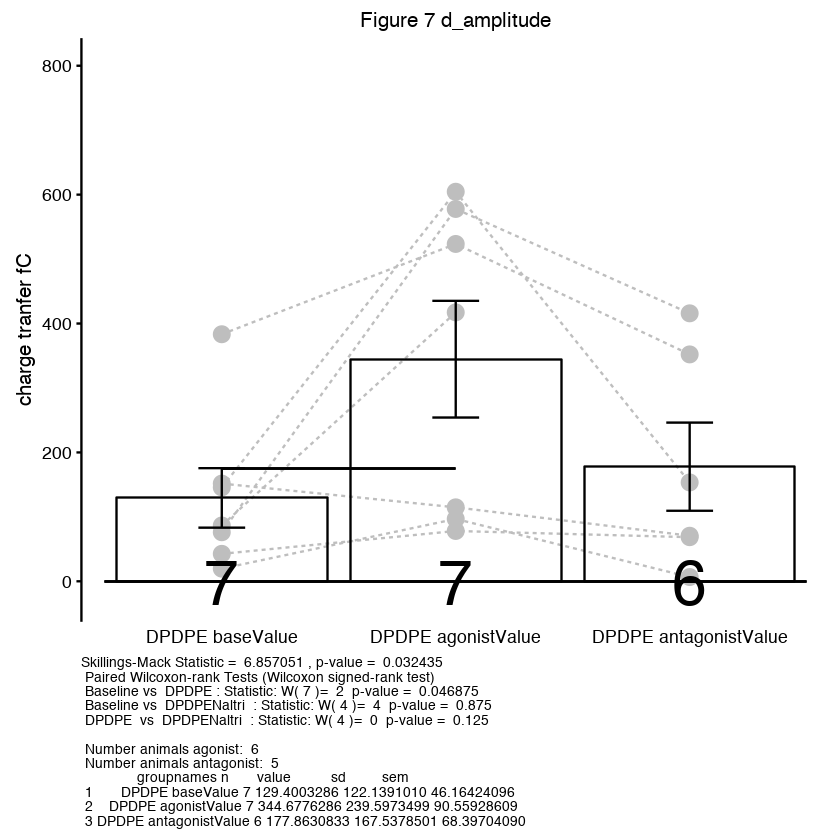

In [29]:
####################################################################################################
#     Figure 7 d
####################################################################################################
# Subset: optogentic stim in ACC, recorded EPSC, from MSNs with DPDPE
tempSDF = subset(df, genoType != "MORKOho" & genoType != "MORWTho" & genoType != "vGlut2cre" & stimSource == "Poly")
tempSDF = subset(tempSDF, signal == "EPSC" & agonistName == "DPDPE")

#Important for good functioning of the script: No need to change:
cols = colnames(tempSDF)
tempSDF = melt(tempSDF, id.vars = cols[1:19],measure.vars = cols[20:21])

# give the tempSDF a specific name, needs to be changed for every new subset
sDf = subset(tempSDF, parameter == 'area' )
sDf$value[sDf$antagonistName =="DPDPEICI" & sDf$variable =="antagonistEffect" ] = NA
sDf$value[sDf$antagonistName =="DPDPENALOX" & sDf$variable =="antagonistEffect" ] = NA
xLabel = c("DPDPE","DPDPENaltri")
antagonistSelect = c("DPDPENALTRI")
graphTitle = c("Figure 7 d")

# prepare data into matrix for Skillings-Mack test.
ssDf = subset(sDf, variable == "agonistEffect" | variable == "antagonistEffect")
ssDf = subset(ssDf, is.finite(baseValue)& is.finite(agonistValue))
# # to avoid problems with sign reversal during agonist/antagonist treatment all conditions that show a different sign from baseValue are set to 0.0001
# # after that the SMmatrix can be transformed to absolute values
for (u in 1:nrow(ssDf)){
  if (ssDf$baseValue[u]<0){
    if (is.finite(ssDf$agonistValue[u])){
      if (ssDf$agonistValue[u]>0){
        ssDf$agonistValue[u]=-0.0001
      }
    }
    if (is.finite(ssDf$antagonistValue[u])){
      if (ssDf$antagonistValue[u]>0){
        ssDf$antagonistValue[u]=-0.0001
      }
    }
  }
  if (ssDf$baseValue[u]>0){
    if (is.finite(ssDf$agonistValue[u])){
      if (ssDf$agonistValue[u]<0){
        ssDf$agonistValue[u]=0.0001
      }
    }
    if (is.finite(ssDf$antagonistValue[u])){
      if (ssDf$antagonistValue[u]<0){
        ssDf$antagonistValue[u]=0.0001
      }
    }
  }
  if (is.finite(ssDf$antagonistName[u])){
    if (ssDf$antagonistName[u] !=antagonistSelect[1]){
      ssDf$antagonistValue[u] = NA
    }
  }
}
ssDf$baseValue = abs(ssDf$baseValue)
ssDf$agonistValue =abs(ssDf$agonistValue)
ssDf$antagonistValue = abs(ssDf$antagonistValue)

# DPDPE
##########
SMlen = length(unique(ssDf$cellID[ssDf$agonistName == 'DPDPE']))
SMmatrix = c(ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen], ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen], ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen])
Gs = c(rep('baseline',SMlen),rep('agonist',SMlen),rep('antagonist',SMlen))
Bs = rep(1:SMlen,3)

SMresult = capture.output(Ski.Mack(SMmatrix,groups=Gs, blocks=Bs))
BAgWilcox = wilcox.test(ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen],ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen],paired = TRUE)
BAgWilcoxFlip = wilcox.test(ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen],ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen],paired = TRUE)
BAgWilcox$statistic = min(c(BAgWilcox$statistic, BAgWilcoxFlip$statistic))
diff = c(ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen] - ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen])
BAgWilcox$n = length(na.omit(diff[diff !=0]))

BAnWilcox = wilcox.test(ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen],ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen], paired = TRUE)
BAnWilcoxFlip = wilcox.test(ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen],ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen],paired = TRUE)
BAnWilcox$statistic = min(c(BAnWilcox$statistic, BAnWilcoxFlip$statistic))
diff = c(ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen] - ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen])
BAnWilcox$n = length(na.omit(diff[diff !=0]))

AgAnWilcox= wilcox.test(ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen], ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen], paired = TRUE)
AgAnWilcoxFlip = wilcox.test(ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen],ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen],paired = TRUE)
AgAnWilcox$statistic = min(c(AgAnWilcox$statistic, AgAnWilcoxFlip$statistic))
diff = c(ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen] - ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen])
AgAnWilcox$n = length(na.omit(diff[diff !=0]))

BAgAnno = pvalAnno(BAgWilcox$p.value,1)
BAnAnno = pvalAnno(BAnWilcox$p.value,1)
AgAnAnno =  pvalAnno(AgAnWilcox$p.value,1)

reportString = paste(SMresult[2],'\n','Paired Wilcoxon-rank Tests (Wilcoxon signed-rank test) \n Baseline vs ',xLabel[1], ': Statistic: W(',BAgWilcox$n,')= ',BAgWilcox$statistic,' p-value = ',signif(BAgWilcox$p.value),'\n Baseline vs ', xLabel[2],' : Statistic: W(',BAnWilcox$n,')= ',BAnWilcox$statistic,' p-value = ',signif(BAnWilcox$p.value),'\n',xLabel[1],' vs ', xLabel[2],' : Statistic: W(',AgAnWilcox$n,')= ',AgAnWilcox$statistic,' p-value = ',signif(AgAnWilcox$p.value),'\n')
animalDf = subset(sDf, variable == 'agonistEffect' & agonistName == 'DPDPE' & is.finite(sDf$value))
agonistAnimal = length(unique(animalDf$animalID))
animalDf = subset(sDf, variable == 'antagonistEffect' & agonistName == 'DPDPE' & is.finite(sDf$value))
antagonistAnimal = length(unique(animalDf$animalID))
reportString2 = paste(reportString,'\n Number animals agonist: ',agonistAnimal,'\n Number animals antagonist: ', antagonistAnimal)
sDf$groupnames = factor(paste(sDf$agonistName, sDf$variable) , levels=c('DPDPE baseValue','DPDPE agonistValue','DPDPE antagonistValue'))
# plot the area by raw values
cols = colnames(sDf)
sDf = subset(sDf, variable =="agonistEffect")
sDf = melt(sDf, id.vars = cols[c(1:14,16,18,22)], measure.vars = cols[c(15,17,19)] )
sDf$value = sDf$value*-1
sDf$groupnames = factor(paste(sDf$agonistName, sDf$variable) , levels=c('DPDPE baseValue','DPDPE agonistValue','DPDPE antagonistValue'))
data_summary = data_meanSDSEM(sDf, varname = "value", groupnames = "groupnames")
sumOut = capture.output(data_summary)
sumRepOut = sumOut[1]
for(u in 2:length(sumOut)){
  sumRepOut = paste(sumRepOut,'\n', sumOut[u])
}

ggplot(data_summary, aes(x = groupnames , y = value))+
  geom_point(data = sDf, aes(x = groupnames , y = value), fill = "gray", colour = "gray",size = 4)+
  geom_line(data = sDf, aes(group = cellID ), lty = 2, colour = "gray")+
  geom_bar(stat = "identity", position = position_dodge(), colour = "black", fill = NA)+
  geom_errorbar(aes(ymin=value-sem, ymax=value+sem), width=.2, position=position_dodge(.9))+
  coord_cartesian(ylim = c(-20,800))+
  theme_cowplot(font_size = 12)+
  stat_summary(data =sDf, fun.data = give.n, geom = "text",fun.y = median, position = position_dodge(width = 0.75), size = (6.51/8)*16)+
  labs(ylab('charge tranfer fC'))+
  labs(xlab(NULL))+
  labs(title = paste(graphTitle,"amplitude",sep='_'))+
  labs(caption = paste(reportString2,'\n',sumRepOut))+
  theme(plot.caption = element_text(size = 8, hjust = 0))+
  theme(plot.title = element_text(size = 12))+
  geom_segment(aes(x=1, y=175, xend = 2, yend = 175))+
  geom_segment(aes(x=0.5, y=0, xend = 3.5, yend = 0))+
  theme(axis.line.x = element_line(linetype='blank'), axis.ticks.x = element_blank())+
  theme(text=element_text(size=12))

# Figure 7 - figure supplement 1
## Figure 7- figure supplement 1a

channelCircuit 
                                                                                                  c(1, 5, 6, 4, 2, 3) 
                                                                                                                    n 
                                                                                              c(6, 29, 79, 44, 8, 13) 
                                                                                                                onset 
                c(11.2833333333333, 3.07758620689655, 2.90379746835443, 4.13409090909091, 10.09375, 6.13076923076923) 
                                                                                                                   sd 
      c(2.02130320997783, 0.525354677285558, 0.851724199668649, 1.41847333291624, 1.66849750631262, 2.44723810835283) 
                                                                                                                  sem 
c(0.825193579982567, 0.0975559144614377, 0.0958264591973098, 0.213842900927638, 0.589902950553249, 0.678741729456588) 
5 Levels: c(1, 5, 6, 4, 2, 3) ... c(0.825193579982567, 0.0975559144614377, 0.0958264591973098, 0.213842900927638, 0.589902950553249, 0.678741729456588)

[1] "laser_Poly_DMS_MSN" "LED_Poly_DMS_MSN"   "MD_L5_PYR_AP"      
[4] "LED_MD_L5_PYR"      "LED_ACC_DMS_MSN"    "LED_MD_DMS_MSN"

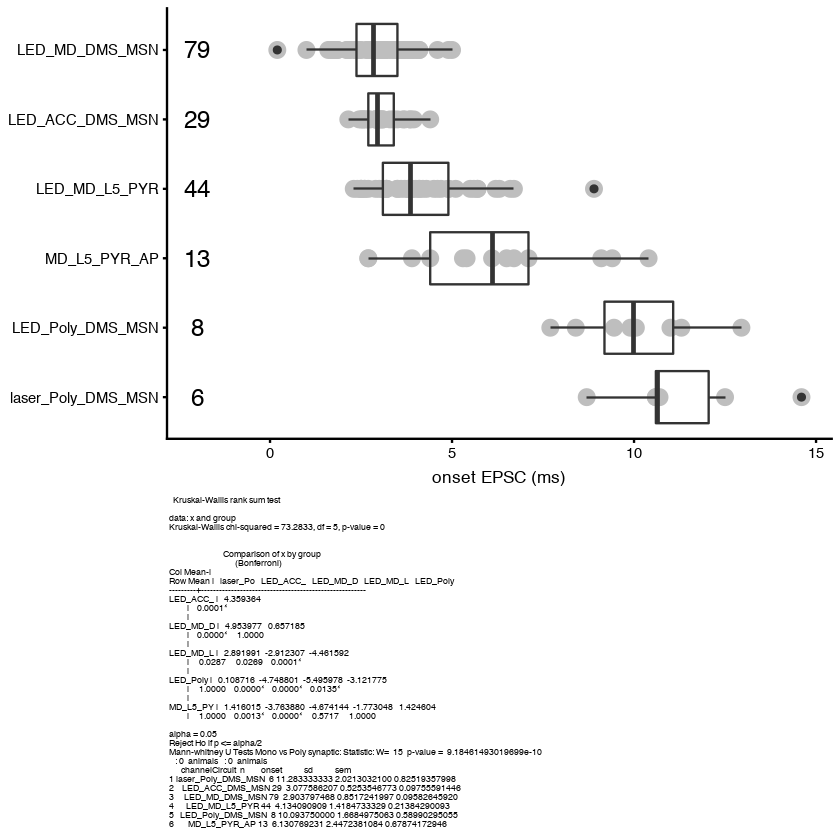

In [30]:
################################################################################################################################
##    Figure 7 - figure supplement 1a
####################################################################################################################################
graphTitle = 'Figure 7 - figure supplement 1a'
# Subset: all subgroups of synaptic contact within the thalamo-cortico-striatal circuit.
tempSDF = subset(cdf, genoType != "MORKOho" & genoType != "MORWTho"  & stimSource == "Poly") #& genoType != "vGlut2cre"
tempSDF1 = subset(tempSDF, cellID == 'will20170405c001' & conditionName == 'BIC');
tempSDF2 = subset(tempSDF, cellID == 'will20170309c007' & conditionName == 'BASEDPDPE')
tempSDF3 = subset(tempSDF, cellID == 'will20170922c002' & conditionName == 'BASE')
tempSDF4 = subset(tempSDF, cellID == 'will20171107c006' & conditionName == 'SR')
tempSDF5 = subset(tempSDF, cellID == 'will20170308c000' & conditionName == 'DPDPE')
tempSDF6 = subset(tempSDF, cellID == 'will20170620c003' & conditionName == 'DPDPE')
tempSDF7 = subset(tempSDF, cellID == 'will20170620c007' & conditionName == 'DPDPENTD')
tempSDF8 = subset(tempSDF, stimChannel == 'laser')
tempSDF = rbind(tempSDF1,tempSDF2,tempSDF3,tempSDF4,tempSDF5,tempSDF6,tempSDF7,tempSDF8)
tempSDF$channelCircuit=paste(tempSDF$stimChannel,tempSDF$circuit,sep='_')
tempSDF$channelCircuit= gsub("Poly_Poly_DMS_MSN","LED_Poly_DMS_MSN",tempSDF$channelCircuit)

tempSDFMDACC = subset(cdf, genoType != "MORKOho" & genoType != "MORWTho"  & stimSource == "MD" & circuit=="MD_L5_PYR" & signal =="EPSC")
tempSDFMDACC = tempSDFMDACC[grep("BASE",tempSDFMDACC$conditionName, perl=TRUE, ignore.case=TRUE),]
tempSDFMDACC$channelCircuit=paste(tempSDFMDACC$stimSource,tempSDFMDACC$circuit,sep='_')
tempSDFMDACC$channelCircuit= gsub("MD_MD_L5_PYR","LED_MD_L5_PYR",tempSDFMDACC$channelCircuit)

tempSDFACCDMS = subset(cdf, genoType != "MORKOho" & genoType != "MORWTho"  & stimSource == "ACC" & circuit=="ACC_DMS_MSN" & signal =="EPSC")
tempSDFACCDMS = tempSDFACCDMS[grep("BASE",tempSDFACCDMS$conditionName, perl=TRUE, ignore.case=TRUE),]
tempSDFACCDMS$channelCircuit=paste(tempSDFACCDMS$stimSource,tempSDFACCDMS$circuit,sep='_')
tempSDFACCDMS$channelCircuit= gsub("ACC_ACC_DMS_MSN","LED_ACC_DMS_MSN",tempSDFACCDMS$channelCircuit)

tempSDFMDDMS = subset(cdf, genoType != "MORKOho" & genoType != "MORWTho"  & stimSource == "MD" & circuit=="MD_DMS_MSN" & signal =="EPSC")
tempSDFMDDMS = tempSDFMDDMS[grep("BASE",tempSDFMDDMS$conditionName, perl=TRUE, ignore.case=TRUE),]
tempSDFMDDMS$channelCircuit=paste(tempSDFMDDMS$stimSource,tempSDFMDDMS$circuit,sep='_')
tempSDFMDDMS$channelCircuit= gsub("MD_MD_DMS_MSN","LED_MD_DMS_MSN",tempSDFMDDMS$channelCircuit)

tempSDF = rbind(tempSDF,tempSDFMDACC,tempSDFMDDMS,tempSDFACCDMS)
tempSDF$synapse = tempSDF$stimSource;
tempSDF$synapse = gsub("MD","mono",tempSDF$synapse)
tempSDF$synapse = gsub("ACC","mono",tempSDF$synapse)
tempSDF$chargeOAmplitude = tempSDF$area/tempSDF$amplitude
tempSDF$test1DrugName = NULL
tempSDF =rbind(tempSDF,apdf)

synapseWilcox = wilcox.test(tempSDF$onset[grep("MONO",tempSDF$synapse,perl=TRUE, ignore.case=TRUE)],tempSDF$onset[grep("POLY",tempSDF$synapse,perl=TRUE, ignore.case=TRUE)], paired=FALSE)
synapseWilcoxFlip = wilcox.test(tempSDF$onset[grep("POLY",tempSDF$synapse,perl=TRUE, ignore.case=TRUE)],tempSDF$onset[grep("MONO",tempSDF$synapse,perl=TRUE, ignore.case=TRUE)], paired=FALSE)
synapseWilcox$statistic = min(c(synapseWilcox$statistic,synapseWilcoxFlip$statistic))
synapseAllDunn = capture.output(dunn.test(tempSDF$onset,tempSDF$channelCircuit, kw = TRUE, method = 'bonferroni'))


reportString = paste(synapseAllDunn)
reportString3 = ''
for (ii in 1:length(levels(data_summary$channelCircuit))){
  animalDf = subset(tempSDF, channelCircuit == data_summary$channelCircuit[ii])
  animalN = length(unique(animalDf$animalID))
  reportString3 = paste(reportString3,data_summary$channelCircuit[ii],' :',animalN,' animals')
}
animalDf = subset(sDf, variable == 'agonistEffect' & agonistName == 'DPDPE' & is.finite(sDf$value))
agonistAnimal = length(unique(animalDf$animalID))
animalDf = subset(sDf, variable == 'antagonistEffect' & agonistName == 'DPDPE' & is.finite(sDf$value))
antagonistAnimal = length(unique(animalDf$animalID))
reportString2 = paste(reportString,'\n Number animals agonist: ',agonistAnimal,'\n Number animals antagonist: ', antagonistAnimal)
data_summary = data_meanSDSEM(tempSDF, varname = "onset", groupnames = "channelCircuit")
data_summary$channelCircuit = factor(data_summary$channelCircuit, levels=c("laser_Poly_DMS_MSN", "LED_Poly_DMS_MSN","MD_L5_PYR_AP", "LED_MD_L5_PYR", "LED_ACC_DMS_MSN", "LED_MD_DMS_MSN"))
tempSDF$channelCircuit = factor(tempSDF$channelCircuit, levels=c("laser_Poly_DMS_MSN", "LED_Poly_DMS_MSN","MD_L5_PYR_AP", "LED_MD_L5_PYR", "LED_ACC_DMS_MSN", "LED_MD_DMS_MSN"))
factor(data_summary)
levels(data_summary$channelCircuit)
sumOut = capture.output(data_summary)
sumRepOut = sumOut[1]
for(u in 2:length(sumOut)){
  sumRepOut = paste(sumRepOut,'\n', sumOut[u])
}
reportString = '';
for (ii in 1:length(synapseAllDunn)){
  reportString = paste(reportString,synapseAllDunn[ii],'\n', sep=' ')
}
reportString2 = paste('Mann-whitney U Tests Mono vs Poly synaptic: Statistic: W= ',synapseWilcox$statistic,' p-value = ',synapseWilcox$p.value)

ggplot(tempSDF, aes(x = channelCircuit , y = onset))+
  geom_point(data = tempSDF, aes(x = channelCircuit , y = onset), fill = "gray", colour = "gray",size = 4)+
  geom_boxplot(varwidth = FALSE, notch = FALSE, fill = NA, )+
  theme_cowplot(font_size =10)+
  stat_summary(data =tempSDF, fun.data = give.n, geom = "text",fun.y = median, position = position_dodge(width = 0.75), size = 5)+
  labs(ylab('onset EPSC (ms)'))+
  labs(xlab(NULL))+
  labs(caption = paste(reportString,reportString2,'\n', reportString3,'\n',sumRepOut), hjust = 0)+
  theme(plot.caption = element_text(size = 5, hjust = 0))+
  theme(text=element_text(size=10))+
  coord_flip()

## Figure 7 - figure supplement 1b

Warning message:
“Removed 1 rows containing non-finite values (stat_summary).”Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_path).”

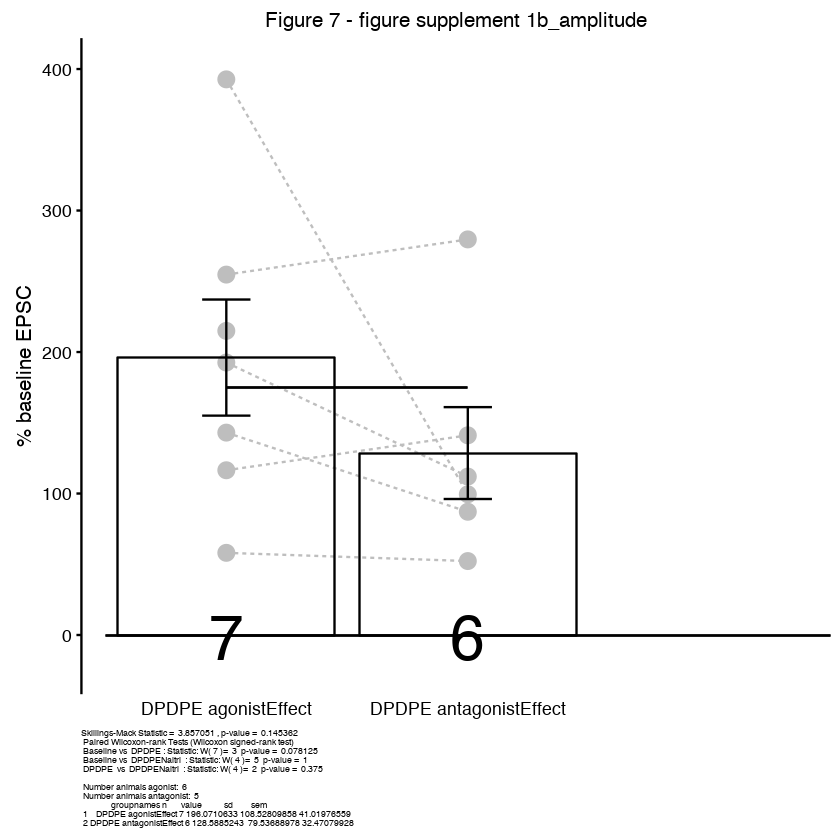

In [31]:
####################################################################################################
#     Figure 7 - figure supplement 1b
####################################################################################################
# Subset: opto stim in ACC, recorded EPSC, from MSNs with DPDPE
tempSDF = subset(df, genoType != "MORKOho" & genoType != "MORWTho" & genoType != "vGlut2cre" & stimSource == "Poly")
tempSDF = subset(tempSDF, signal == "EPSC" & agonistName == "DPDPE")

#Important for good functioning of the script: No need to change:
cols = colnames(tempSDF)
tempSDF = melt(tempSDF, id.vars = cols[1:19],measure.vars = cols[20:21])

# give the tempSDF a specific name, needs to be changed for every new subset
sDf = subset(tempSDF, parameter == 'amplitude' )
sDf$value[sDf$antagonistName =="DPDPEICI" & sDf$variable =="antagonistEffect" ] = NA
sDf$value[sDf$antagonistName =="DPDPENALOX" & sDf$variable =="antagonistEffect" ] = NA
xLabel = c("DPDPE","DPDPENaltri")
antagonistSelect = c("DPDPENALTRI")
graphTitle = c("Figure 7 - figure supplement 1b")

# prepare data into matrix for Skillings-Mack test.
ssDf = subset(sDf, variable == "agonistEffect" | variable == "antagonistEffect")
ssDf = subset(ssDf, is.finite(baseValue)& is.finite(agonistValue))
# # to avoid problems with sign reversal during agonist/antagonist treatment all conditions that show a different sign from baseValue are set to 0.0001
# # after that the SMmatrix can be transformed to absolute values
for (u in 1:nrow(ssDf)){
  if (ssDf$baseValue[u]<0){
    if (is.finite(ssDf$agonistValue[u])){
      if (ssDf$agonistValue[u]>0){
        ssDf$agonistValue[u]=-0.0001
      }
    }
    if (is.finite(ssDf$antagonistValue[u])){
      if (ssDf$antagonistValue[u]>0){
        ssDf$antagonistValue[u]=-0.0001
      }
    }
  }
  if (ssDf$baseValue[u]>0){
    if (is.finite(ssDf$agonistValue[u])){
      if (ssDf$agonistValue[u]<0){
        ssDf$agonistValue[u]=0.0001
      }
    }
    if (is.finite(ssDf$antagonistValue[u])){
      if (ssDf$antagonistValue[u]<0){
        ssDf$antagonistValue[u]=0.0001
      }
    }
  }
  if (is.finite(ssDf$antagonistName[u])){
    if (ssDf$antagonistName[u] !=antagonistSelect[1]){
      ssDf$antagonistValue[u] = NA
    }
  }
}
ssDf$baseValue = abs(ssDf$baseValue)
ssDf$agonistValue =abs(ssDf$agonistValue)
ssDf$antagonistValue = abs(ssDf$antagonistValue)

# DPDPE
##########
SMlen = length(unique(ssDf$cellID[ssDf$agonistName == 'DPDPE']))
SMmatrix = c(ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen], ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen], ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen])
Gs = c(rep('baseline',SMlen),rep('agonist',SMlen),rep('antagonist',SMlen))
Bs = rep(1:SMlen,3)
SMresult = capture.output(Ski.Mack(SMmatrix,groups=Gs, blocks=Bs))
BAgWilcox = wilcox.test(ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen],ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen],paired = TRUE)
BAgWilcoxFlip = wilcox.test(ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen],ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen],paired = TRUE)
BAgWilcox$statistic = min(c(BAgWilcox$statistic, BAgWilcoxFlip$statistic))
diff = c(ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen] - ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen])
BAgWilcox$n = length(na.omit(diff[diff !=0]))

BAnWilcox = wilcox.test(ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen],ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen], paired = TRUE)
BAnWilcoxFlip = wilcox.test(ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen],ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen],paired = TRUE)
BAnWilcox$statistic = min(c(BAnWilcox$statistic, BAnWilcoxFlip$statistic))
diff = c(ssDf$baseValue[ssDf$agonistName == 'DPDPE'][1:SMlen] - ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen])
BAnWilcox$n = length(na.omit(diff[diff !=0]))

AgAnWilcox= wilcox.test(ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen], ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen], paired = TRUE)
AgAnWilcoxFlip = wilcox.test(ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen],ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen],paired = TRUE)
AgAnWilcox$statistic = min(c(AgAnWilcox$statistic, AgAnWilcoxFlip$statistic))
diff = c(ssDf$agonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen] - ssDf$antagonistValue[ssDf$agonistName == 'DPDPE'][1:SMlen])
AgAnWilcox$n = length(na.omit(diff[diff !=0]))

BAgAnno = pvalAnno(BAgWilcox$p.value,1)
BAnAnno = pvalAnno(BAnWilcox$p.value,1)
AgAnAnno =  pvalAnno(AgAnWilcox$p.value,1)
reportString = paste(SMresult[2],'\n','Paired Wilcoxon-rank Tests (Wilcoxon signed-rank test) \n Baseline vs ',xLabel[1], ': Statistic: W(',BAgWilcox$n,')= ',BAgWilcox$statistic,' p-value = ',signif(BAgWilcox$p.value),'\n Baseline vs ', xLabel[2],' : Statistic: W(',BAnWilcox$n,')= ',BAnWilcox$statistic,' p-value = ',signif(BAnWilcox$p.value),'\n',xLabel[1],' vs ', xLabel[2],' : Statistic: W(',AgAnWilcox$n,')= ',AgAnWilcox$statistic,' p-value = ',signif(AgAnWilcox$p.value),'\n')
animalDf = subset(sDf, variable == 'agonistEffect' & agonistName == 'DPDPE' & is.finite(sDf$value))
agonistAnimal = length(unique(animalDf$animalID))
animalDf = subset(sDf, variable == 'antagonistEffect' & agonistName == 'DPDPE' & is.finite(sDf$value))
antagonistAnimal = length(unique(animalDf$animalID))
reportString2 = paste(reportString,'\n Number animals agonist: ',agonistAnimal,'\n Number animals antagonist: ', antagonistAnimal)
sDf$groupnames = paste(sDf$agonistName, sDf$variable)
data_summary = data_meanSDSEM(sDf, varname = "value", groupnames = "groupnames")
sumOut = capture.output(data_summary)
sumRepOut = sumOut[1]
for(u in 2:length(sumOut)){
  sumRepOut = paste(sumRepOut,'\n', sumOut[u])
}

ggplot(data_summary, aes(x = groupnames , y = value))+
  geom_point(data = sDf, aes(x = groupnames , y = value), fill = "gray", colour = "gray",size = 4)+
  geom_line(data = sDf, aes(group = cellID ), lty = 2, colour = "gray")+
  geom_bar(stat = "identity", position = position_dodge(), colour = "black", fill = NA)+
  geom_errorbar(aes(ymin=value-sem, ymax=value+sem), width=.2, position=position_dodge(.9))+
  coord_cartesian(ylim = c(-20,400))+
  theme_cowplot(font_size = 12)+
  stat_summary(data =sDf, fun.data = give.n, geom = "text",fun.y = median, position = position_dodge(width = 0.75), size = (6.51/8)*16)+
  labs(ylab('% baseline EPSC'))+
  labs(xlab(NULL))+
  labs(title = paste(graphTitle,"amplitude",sep='_'))+
  labs(caption = paste(reportString2,'\n',sumRepOut))+
  theme(plot.caption = element_text(size = 5, hjust = 0))+
  theme(plot.title = element_text(size = 12))+
  geom_segment(aes(x=1, y=175, xend = 2, yend = 175))+
  geom_segment(aes(x=0.5, y=0, xend = 3.5, yend = 0))+
  theme(axis.line.x = element_line(linetype='blank'), axis.ticks.x = element_blank())+
  theme(text=element_text(size=12))

# Rebuttal Figure 1c

In [32]:
####################################################################################################
#     Rebuttal figure 1c
####################################################################################################
# analysis of data and perform Test for Significance on EPSC
# amplitude across conditions
# Requires installation of packages: 'Skillings.Mack'
library(Skillings.Mack)
library(ggplot2)
df = read.csv('data/data_rebuttal_fig1.csv')
# subset for all DPDPE experiments with a baseline value
df_DPDPE = df[rep(!is.nan(df$effect_amplitude[grep('baseNaltrindole', df$conditionDPDPE)]),3),c('effect_amplitude', 'conditionDPDPE','cellDPDPE','expDPDPE')]
print('Naltrindole-DPDPE effect on baseline EPSC Skillings-Mack analysis')
Ski.Mack(df_DPDPE$effect_amplitude,df_DPDPE$conditionDPDPE,df_DPDPE$cellDPDPE)
print('Paired Wilcoxon signed rank test baseline vs Naltrindole')
# define here the two groups to compare
first_group = df_DPDPE$effect_amplitude[df_DPDPE$conditionDPDPE=='baseNaltrindole']
second_group = df_DPDPE$effect_amplitude[df_DPDPE$conditionDPDPE=='Naltrindole']
# Below is required to calculate n and statistic in a sequence independent way
# (first vs second group and second vs first group)
wilcox_antero = wilcox.test(first_group, second_group, paired = TRUE)
wilcox_retro = wilcox.test(second_group, first_group, paired = TRUE)
statistic = min(c(wilcox_antero$statistic, wilcox_retro$statistic))
diff = c(first_group-second_group)
n = length(na.omit(diff[diff != 0]))
print(paste('W(', n, ') = ', statistic, '. p = ', wilcox_antero$p.value))
print('Paired Wilcoxon signed rank test Naltrindole vs DPDPENaltrindole')
# define here the two groups to compare
first_group = df_DPDPE$effect_amplitude[df_DPDPE$conditionDPDPE=='Naltrindole']
second_group = df_DPDPE$effect_amplitude[df_DPDPE$conditionDPDPE=='DPDPENaltrindole']
# Below is required to calculate n and statistic in a sequence independent way
# (first vs second group and second vs first group)
wilcox_antero = wilcox.test(first_group, second_group, paired = TRUE)
wilcox_retro = wilcox.test(second_group, first_group, paired = TRUE)
statistic = min(c(wilcox_antero$statistic, wilcox_retro$statistic))
diff = c(first_group-second_group)
n = length(na.omit(diff[diff != 0]))
print(paste('W(', n, ') = ', statistic, '. p = ', wilcox_antero$p.value))

[1] "Naltrindole-DPDPE effect on baseline EPSC Skillings-Mack analysis"

Skillings-Mack Statistic =  3.714286 , p-value =  0.156118 
Note: the p-value is based on the chi-squared distribution with d.f. =  2 

$Nblocks
[1] 7

$Ntreatments
[1] 3

$rawdata
            [,1]        [,2]        [,3]        [,4]        [,5]        [,6]
[1,] 1288.147967 570.3919281 550.9480322 455.4172314 690.8605557 569.1642694
[2,] 1232.114758 490.2516592 382.6019742 686.4860459 621.2439124 450.3674759
[3,] 1330.044652 453.3139970 209.8444380 565.3576579 675.4080718 313.0839955
             [,7]
[1,] 1193.1270871
[2,]  785.0636979
[3,]  752.8596021

$rankdata
     [,1] [,2] [,3] [,4] [,5] [,6] [,7]
[1,]    2    3    3    1    3    3    3
[2,]    1    2    2    3    1    2    2
[3,]    3    1    1    2    2    1    1

$varCovarMatrix
     [,1] [,2] [,3]
[1,]   14   -7   -7
[2,]   -7   14   -7
[3,]   -7   -7   14

$adjustedSum
           [,1]         [,2]         [,3]
[1,] 6.92820323 -1.732050808 -5.196152423


# Rebuttal figure 2

In [33]:
# Rebuttal figure 2 Analysis of data and perform plotting for DAMGO effect on
# thalamostriatal projections, to check whether there is a potential
# heterogeneity in the data that would suggest that inputs to D1 and D2 MSNs in
# the striatum may be modulated differently.
# import packages
library(ggplot2)
library(reshape2)
library(cowplot)
require(cowplot)
library(tidyverse)  # data manipulation
library(cluster)    # clustering algorithms
library(factoextra) # clustering visualization
library(dendextend) # for comparing two dendrograms
library(heatmap.plus) # clustering visualization
library(colorspace) # colors
library(RColorBrewer)
library(colorRamps)
library(gplots)
library(plyr)
library(Skillings.Mack)

df=read.csv('data/effectDataset.csv')
df$X = NULL
msn_df=subset(df, cellType=='MSN' & drugGroup==2)
setHook(packageEvent("grDevices", "onLoad"),
function(...) grDevices::X11.options(type='cairo'))
options(device='x11')
# subset data for thalamostriatal projections only (including MD and AM)
thal_df = subset(msn_df, (stimSource=='MD' | stimSource=='AM') & cellID != 'will20180705_734c011') 

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  1.4.2     ✔ purrr   0.2.5
✔ tidyr   0.8.2     ✔ dplyr   0.7.8
✔ readr   1.1.1     ✔ stringr 1.3.1
✔ tibble  1.4.2     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::arrange()    masks plyr::arrange()
✖ readr::col_factor() masks scales::col_factor()
✖ purrr::compact()    masks plyr::compact()
✖ dplyr::count()      masks plyr::count()
✖ purrr::discard()    masks scales::discard()
✖ tidyr::expand()     masks Matrix::expand()
✖ dplyr::failwith()   masks plyr::failwith()
✖ dplyr::filter()     masks stats::filter()
✖ cowplot::ggsave()   masks ggplot2::ggsave()
✖ dplyr::id()         masks plyr::id()
✖ dplyr::lag()        masks stats::lag()
✖ dplyr::mutate()     masks plyr::mutate()
✖ dplyr::rename()     masks plyr::rename()
✖ dplyr::select()     masks MASS::select()
✖ dplyr::summarise()  masks plyr::summarise()
✖ dplyr::summarize()  masks plyr::

## Rebuttal figure 2a

Warning message:
“Removed 1 rows containing non-finite values (stat_bin).”

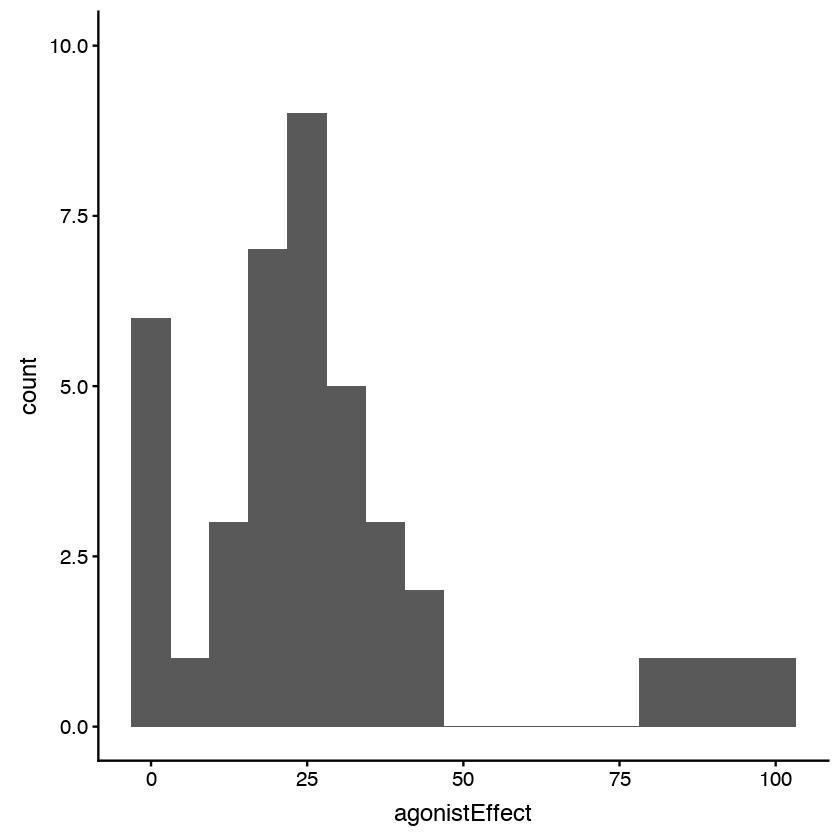

In [34]:
####################################################################################################
#     Rebuttal figure 2a
####################################################################################################
# plot distribution of DAMGO effect on thalamostriatal 
# projections.

ggplot(data=subset(thal_df, parameter=='amplitude'), aes(agonistEffect)) +
    geom_histogram(binwidth=25/4)+
    ylim(0,10)

In [35]:
print('damgoEffect normality test')
shapiro.test(subset(thal_df, parameter=='amplitude')$agonistEffect)

[1] "damgoEffect normality test"



	Shapiro-Wilk normality test

data:  subset(thal_df, parameter == "amplitude")$agonistEffect
W = 0.82149112, p-value = 1.962699e-05


## Rebuttal figure 2b

In [36]:
####################################################################################################
#     Rebuttal figure 2b
####################################################################################################
# First re-organize the df to allow for subsetting 
sthal_df = thal_df[,c(1:12, 20, 15)]
tthal_df <- subset(sthal_df, parameter=='amplitude')
colnames(tthal_df)[colnames(tthal_df)=='baseValue'] <- 'amplitude'
colnames(tthal_df)[colnames(tthal_df)=='agonistEffect'] <- 'damgoEffect'
tthal_df$parameter <- NULL
tthal_df$onset <- subset(sthal_df, parameter=='onset')$baseValue
tthal_df$risetime <- subset(sthal_df, parameter=='risetime')$baseValue
tthal_df$slope <- subset(sthal_df, parameter=='slope')$baseValue
tthal_df$onset2peakTime <- subset(sthal_df, parameter=='onset2peakTime')$baseValue
tthal_df$halfwidth <- subset(sthal_df, parameter=='halfwidth')$baseValue
tthal_df$decay <- subset(sthal_df, parameter=='decay')$baseValue
tthal_df$area <- subset(sthal_df, parameter=='area')$baseValue
tthal_df$chargeOAmplitude <- subset(sthal_df, parameter=='chargeOAmplitude')$baseValue
# fill out NA for onset of will20180705_732c002 with median of onset
tthal_df[tthal_df$cellID == 'will20180705_732c002',]$onset = median(tthal_df$onset, na.rm=TRUE)
rownames(tthal_df) = 1:nrow(tthal_df)
tthal_df_ref = tthal_df
tthal_df = tthal_df[,-12]

Warning message:
“Removed 2 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 2 rows containing missing values (geom_point).”Warning message in grid.Call.graphics(C_polygon, x$x, x$y, index):
“semi-transparency is not supported on this device: reported only once per page”


Call:
lm(formula = risetime ~ damgoEffect, data = tthal_df_ref)

Residuals:
        Min          1Q      Median          3Q         Max 
-0.78276215 -0.44111118 -0.06654981  0.28960441  1.83244029 

Coefficients:
               Estimate  Std. Error t value   Pr(>|t|)    
(Intercept) 1.132762132 0.143774537 7.87874 1.6452e-09 ***
damgoEffect 0.003210778 0.003902538 0.82274    0.41579    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5924341 on 38 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.01750148,	Adjusted R-squared:  -0.008353749 
F-statistic: 0.6769029 on 1 and 38 DF,  p-value: 0.4157885


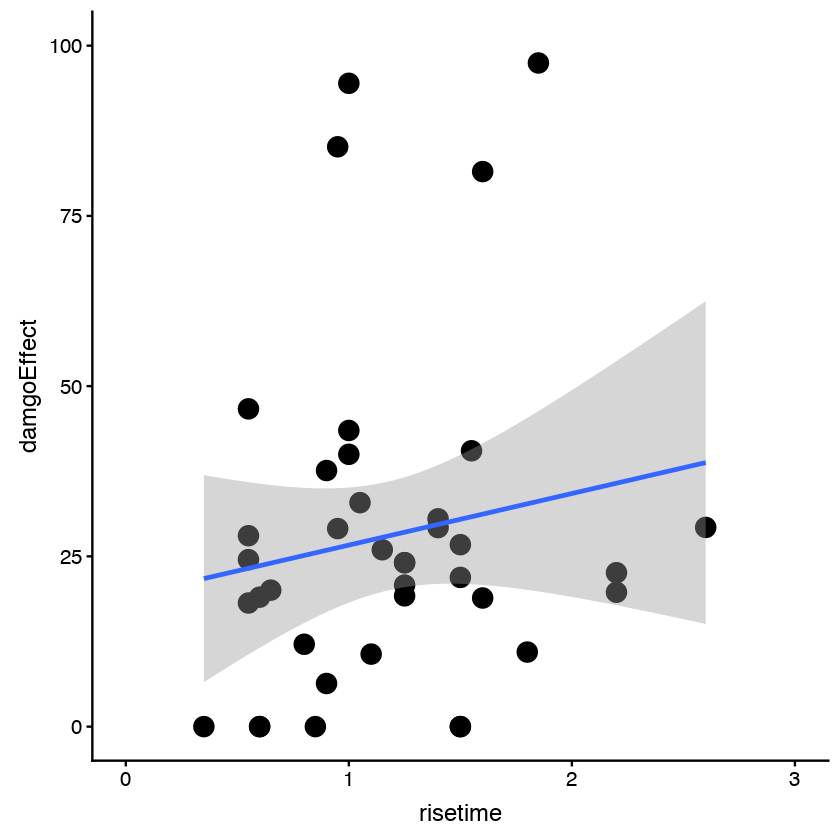

In [37]:
# Rebuttal figure 2b, plot distribution of baseline EPSC risetime vs DAMGO 
# effect for thalamostriatal inputs. Perform linear regression to check for 
# correlation between effect of DAMGO and risetime of the baseline EPSC.
ggplot(data=tthal_df_ref, aes(risetime, damgoEffect))+
    geom_point(size=5)+
    geom_smooth(method=lm, se=TRUE)+
    ylim(0,100)+
    xlim(0,3)
model = lm(risetime ~ damgoEffect, data=tthal_df_ref)
summary(model)

## Rebuttal figure 2c-d

In [38]:
####################################################################################################
#     Rebuttal figure 2c and d
####################################################################################################
# Define two subpopulations based on the baseline EPSC
# parameters. Based on those two subpopulations, test whether DAMGO effect on
# baseline is significantly different between the two populations.
# Generate a matrix with all parameters and make sure that no constant or zero
# columns are present
input_thal = tthal_df[12:ncol(tthal_df)]
input_thal = na.omit(input_thal)
which(apply(input_thal, 2, var)==0) # some variables have a constant or zero column, those need to be removed
input_thal = input_thal[, apply(input_thal, 2, var)!=0]
input_thal = scale(input_thal, center=TRUE, scale=TRUE) # center to the mean value and divide by standard deviation
# generate distance matrixes for the cells and parameters:
d_HCA_thal_param = get_dist(t(input_thal), method="pearson")
d_HCA_thal_cell = get_dist((input_thal), method="euclidean")
# Check that for both matrixes which clustering methods produces the strongest
# clusters
m <- c( "average", "single", "complete", "ward")
names(m) <- c( "average", "single", "complete", "ward")
ac <- function(x) {
  agnes(d_HCA_thal_cell, method = x)$ac
}
map_dbl(m, ac)
m <- c( "average", "single", "complete", "ward")
names(m) <- c( "average", "single", "complete", "ward")
ac <- function(x) {
  agnes(d_HCA_thal_param, method = x)$ac
}
map_dbl(m, ac)

named integer(0)

average       single     complete         ward 
0.7384082430 0.5975306806 0.8153569909 0.8873608968

average       single     complete         ward 
0.8023507264 0.7186418877 0.8606490357 0.8861432249

[1]  1 18 36 16 20 33 29 30  4  5 17  8 19 27 28

[1] "amplitude"        "area"             "slope"            "onset"           
[5] "risetime"         "onset2peakTime"   "halfwidth"        "chargeOAmplitude"
[9] "decay"

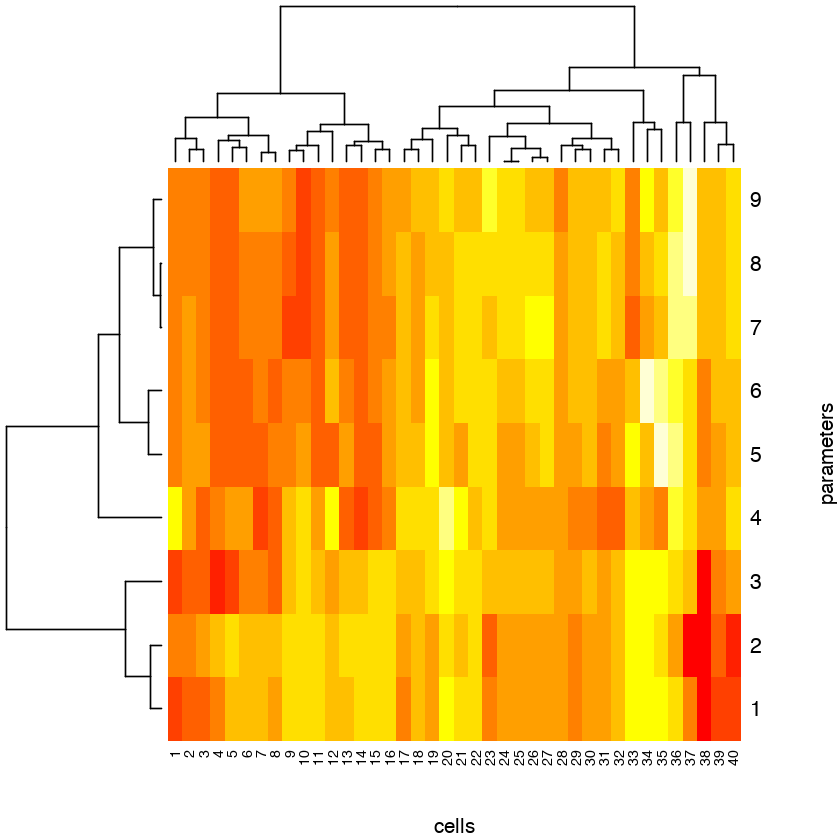

In [39]:
# Based on the comparison of methods it turns out that Ward provides the strongest
# clusters for both cell and parameter clustering. So continue with Ward.
HCA_thal_cell = agnes(d_HCA_thal_cell, method = "ward")
HCA_thal_param = agnes(d_HCA_thal_param, method = "ward")
heatmap(t(input_thal), Colv=as.dendrogram(HCA_thal_cell), Rowv=as.dendrogram(HCA_thal_param), scale='none', labRow = TRUE, labCol = TRUE, xlab="cells", ylab="parameters")
HCA_thal_cell$order[1:15]
HCA_thal_param$order.lab

Warning message:
“Removed 1 rows containing non-finite values (stat_bin).”Warning message in grid.Call.graphics(C_rect, x$x, x$y, x$width, x$height, resolveHJust(x$just, :
“semi-transparency is not supported on this device: reported only once per page”

[1] "Warning, if alpha in the above plot is not allowed, this will stall the plotting and subsequent stats"
[1] "please remove the alpha=0.5 from the above ggplot section"


Warning message in wilcox.test.default(x = thal_clust1, y = thal_clust2, paired = FALSE):
“cannot compute exact p-value with ties”


	Wilcoxon rank sum test with continuity correction

data:  thal_clust1 and thal_clust2
W = 181, p-value = 0.9884833
alternative hypothesis: true location shift is not equal to 0


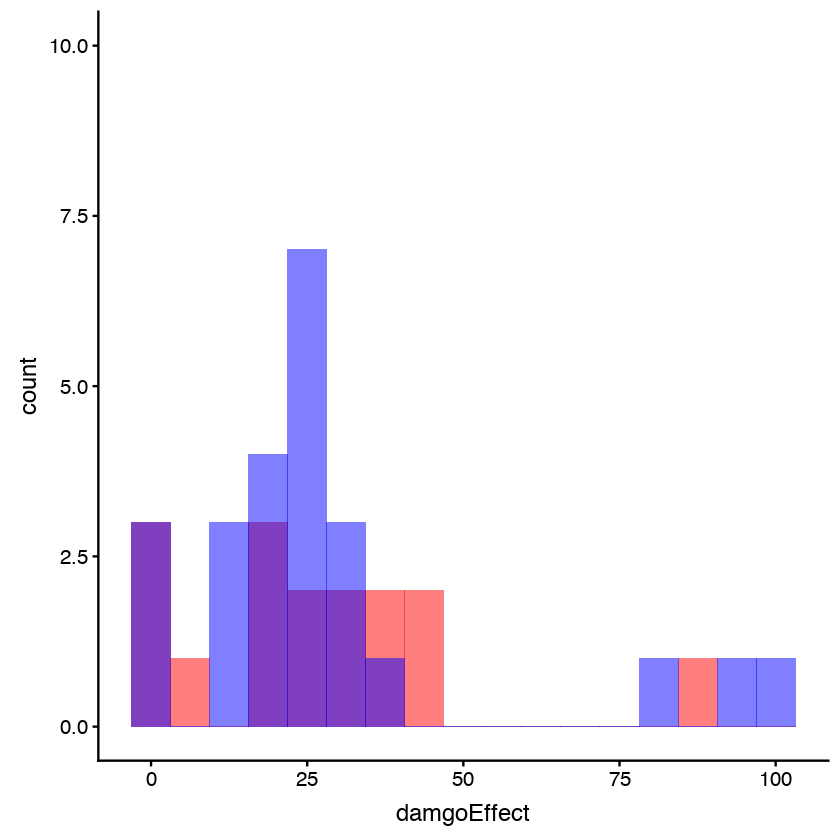

In [40]:
# Plot and test whether the two putative subpopulations have a difference in DAMGO effect on Baseline
tthal_df_ref$cluster = rep(1,nrow(tthal_df_ref))
clust1 = HCA_thal_cell$order[1:16]
clust2 = HCA_thal_cell$order[17:nrow(input_thal)]
tthal_df_ref[clust1,]$cluster = 1
tthal_df_ref[clust2,]$cluster = 2
ggplot(tthal_df_ref, aes(damgoEffect)) +
    geom_histogram(data=subset(tthal_df_ref,cluster==1), alpha=0.5, fill='red', binwidth=25/4)+
    geom_histogram(data=subset(tthal_df_ref,cluster==2), alpha=0.5, fill='blue',  binwidth=25/4)+
    ylim(0,10)
print('Warning, if alpha in the above plot is not allowed, this will stall the plotting and subsequent stats')
print('please remove the alpha=0.5 from the above ggplot section')
clust1 = HCA_thal_cell$order[1:16]
clust2 = HCA_thal_cell$order[17:nrow(input_thal)]
thal_clust1 = tthal_df_ref$damgoEffect[clust1]
thal_clust2 = tthal_df_ref$damgoEffect[clust2]
wilcox.test(x=thal_clust1,
            y=thal_clust2,
            paired=FALSE)